# End-to-End pipeline 


###1. 물리적 변수의 성격우리가 풀고 있는 지배 방정식:

$-\nabla \cdot (a(x, y) \nabla u(x, y)) = f(x, y), \quad (x, y) \in \Omega$


$\hat{u} = \mathcal{N}(x, y; \theta)$

$\mathbf{v} = -a \nabla u$

$\mathbf{v} = (v_x, v_y) = \left( -a(x,y) \frac{\partial u}{\partial x}, \quad -a(x,y) \frac{\partial u}{\partial y} \right) $

Using device: cuda


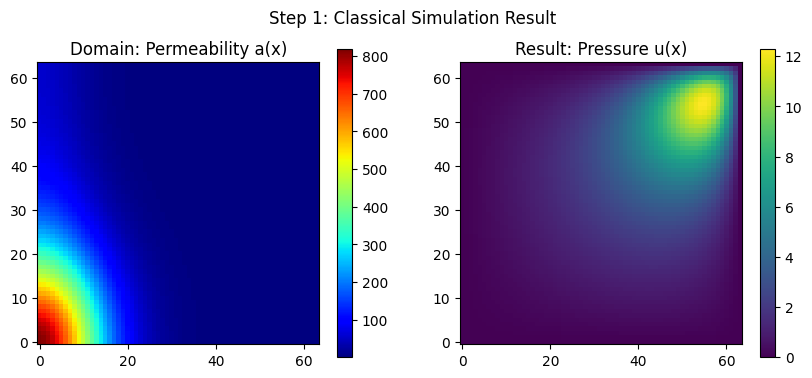

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.ndimage
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 설정
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# [Step 1] Classical FDM Solver (The Simulator)
# ----------------------------------------------------------------
class DarcySolver:
    def __init__(self, N=64):
        self.N = N
        self.h = 1.0 / (N - 1)
        self.x = np.linspace(0, 1, N)
        self.y = np.linspace(0, 1, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)

    # DarcySolver 클래스 내부 수정
    def generate_random_permeability(self, alpha=3.0, beta=4.0): # beta를 4.0 이상으로!
        xi = np.random.randn(self.N, self.N)
        # alpha값도 랜덤으로 주면 다양한 패턴 크기 학습 가능
        real_alpha = np.random.uniform(2.0, 4.0) 
        sigma = self.N / real_alpha
        a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=sigma)
        
        # 정규화 후 스케일링 (Contrast 극대화)
        a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
        a = np.exp(beta * a_smooth) 
        return a

    def solve(self, a_field):
        """
        Finite Difference Method (5-point stencil)로 방정식 풀이
        -div(a * grad u) = 1
        """
        N = self.N
        h = self.h
        num_unknowns = N * N
        idx = lambda i, j: i * N + j
        
        row, col, data = [], [], []
        rhs = np.ones(num_unknowns) * h**2 # f=1
        
        for i in range(N):
            for j in range(N):
                curr = idx(i, j)
                
                # 경계 조건 (Dirichlet u=0)
                if i == 0 or i == N-1 or j == 0 or j == N-1:
                    row.append(curr); col.append(curr); data.append(1.0)
                    rhs[curr] = 0.0
                    continue
                
                # 내부 점 (Harmonic average approximation)
                # 계수 계산 (중심점 기준 상하좌우)
                a_c = a_field[i, j]
                
                # Coefficients (Simplified)
                # 실제 수치해석에서는 a_{i+1/2} 등을 써야 하지만 교육용으로 단순화
                row.append(curr); col.append(curr); data.append(4 * a_c)
                row.append(curr); col.append(idx(i-1, j)); data.append(-a_c)
                row.append(curr); col.append(idx(i+1, j)); data.append(-a_c)
                row.append(curr); col.append(idx(i, j-1)); data.append(-a_c)
                row.append(curr); col.append(idx(i, j+1)); data.append(-a_c)
                
        # Sparse Matrix Solver
        A = sp.coo_matrix((data, (row, col)), shape=(num_unknowns, num_unknowns)).tocsc()
        u = spla.spsolve(A, rhs)
        return u.reshape(N, N)

# ----------------------------------------------------------------
# 시각화 테스트 (Domain & Result)
# ----------------------------------------------------------------
solver = DarcySolver(N=64)
a_sample = solver.generate_random_permeability()
u_sample = solver.solve(a_sample)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Domain: Permeability a(x)")
plt.imshow(a_sample, origin='lower', cmap='jet')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Result: Pressure u(x)")
plt.imshow(u_sample, origin='lower', cmap='viridis')
plt.colorbar()
plt.suptitle("Step 1: Classical Simulation Result")
plt.show()

# data preparation 

🚀 Generating 2000 samples...
   ... 50/2000 completed
   ... 100/2000 completed
   ... 150/2000 completed
   ... 200/2000 completed
   ... 250/2000 completed
   ... 300/2000 completed
   ... 350/2000 completed
   ... 400/2000 completed
   ... 450/2000 completed
   ... 500/2000 completed
   ... 550/2000 completed
   ... 600/2000 completed
   ... 650/2000 completed
   ... 700/2000 completed
   ... 750/2000 completed
   ... 800/2000 completed
   ... 850/2000 completed
   ... 900/2000 completed
   ... 950/2000 completed
   ... 1000/2000 completed
   ... 1050/2000 completed
   ... 1100/2000 completed
   ... 1150/2000 completed
   ... 1200/2000 completed
   ... 1250/2000 completed
   ... 1300/2000 completed
   ... 1350/2000 completed
   ... 1400/2000 completed
   ... 1450/2000 completed
   ... 1500/2000 completed
   ... 1550/2000 completed
   ... 1600/2000 completed
   ... 1650/2000 completed
   ... 1700/2000 completed
   ... 1750/2000 completed
   ... 1800/2000 completed
   ... 1850/2000 co

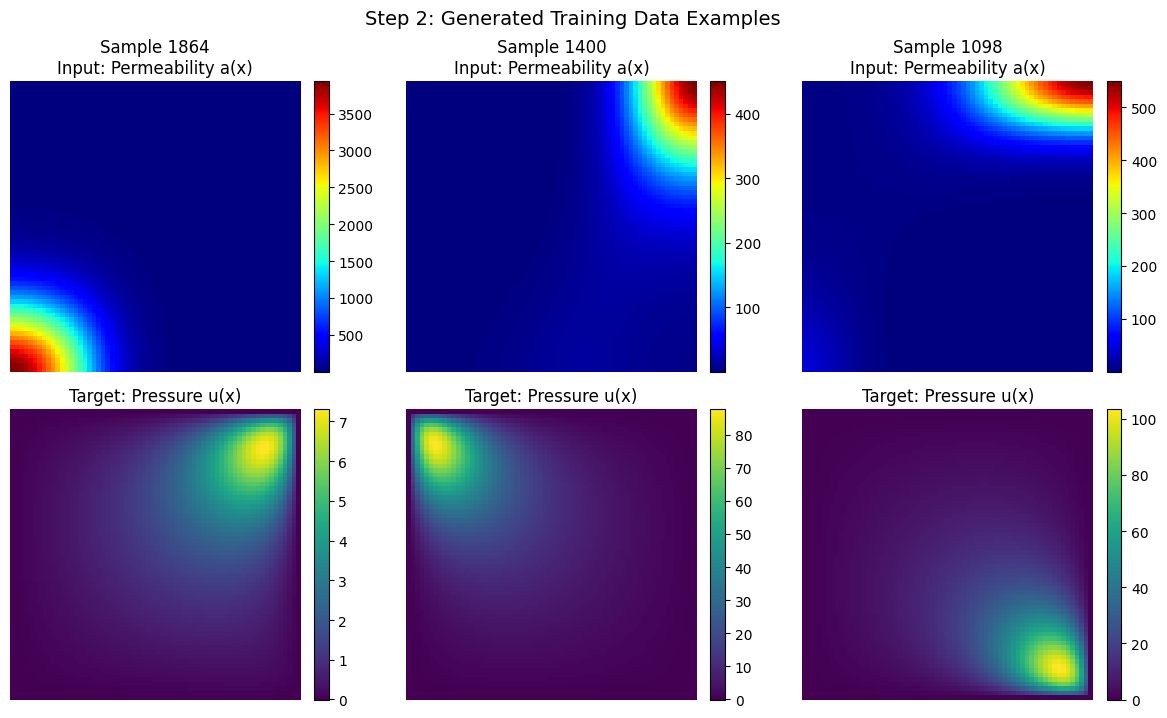

In [2]:
# ----------------------------------------------------------------
# [Step 2] Data Generation for AI Training
# ----------------------------------------------------------------

def generate_dataset(num_samples, N=64):
    """
    DarcySolver를 사용하여 (입력 a, 정답 u) 쌍의 데이터셋을 생성합니다.
    """
    solver = DarcySolver(N)
    data_a = []
    data_u = []
    
    print(f"🚀 Generating {num_samples} samples...")
    for i in range(num_samples):
        # 1. 랜덤 투과율 필드 생성 (Step 1에서 수정된 고대비 로직 사용됨)
        a = solver.generate_random_permeability()
        
        # 2. 시뮬레이터(Solver)로 정답 압력장 계산
        u = solver.solve(a)
        
        data_a.append(a)
        data_u.append(u)
        
        # 진행 상황 표시 (선택 사항)
        if (i + 1) % 50 == 0:
            print(f"   ... {i + 1}/{num_samples} completed")
        
    # AI 모델 입력 형태인 (Batch, Channel, Height, Width)로 변환
    # Channel = 1
    return np.array(data_a)[:, np.newaxis, :, :], np.array(data_u)[:, np.newaxis, :, :]

# 1. 데이터셋 생성 실행
# 학습용 200개, 테스트용 20개 (시간이 걸릴 수 있습니다)
train_a, train_u = generate_dataset(2000, N=64)
test_a, test_u = generate_dataset(20, N=64)

# 2. PyTorch Tensor로 변환 및 DataLoader 생성
# [수정됨] 이전에 에러가 났던 부분입니다. 
# numpy array를 torch.tensor로 변환하면서 dtype을 지정합니다.
x_train_tensor = torch.tensor(train_a, dtype=torch.float32)
y_train_tensor = torch.tensor(train_u, dtype=torch.float32)

x_test_tensor = torch.tensor(test_a, dtype=torch.float32)
y_test_tensor = torch.tensor(test_u, dtype=torch.float32)

# DataLoader 생성
train_loader = DataLoader(
    TensorDataset(x_train_tensor, y_train_tensor),
    batch_size=16, 
    shuffle=True
)

print("\n✅ Data Generation & Loading Complete!")
print(f"   Train Data Shape: {x_train_tensor.shape}")
print(f"   Test Data Shape:  {x_test_tensor.shape}")

# ----------------------------------------------------------------
# 데이터 다양성 시각화 (생성된 데이터 확인)
# ----------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 7))

# 랜덤하게 3개 샘플만 뽑아서 시각화
indices = np.random.choice(len(train_a), 3, replace=False)

for i, idx in enumerate(indices):
    # Input: Permeability
    im1 = axes[0, i].imshow(train_a[idx, 0], origin='lower', cmap='jet')
    axes[0, i].set_title(f"Sample {idx}\nInput: Permeability a(x)")
    axes[0, i].axis('off')
    plt.colorbar(im1, ax=axes[0, i], fraction=0.046, pad=0.04)
    
    # Output: Pressure
    im2 = axes[1, i].imshow(train_u[idx, 0], origin='lower', cmap='viridis')
    axes[1, i].set_title(f"Target: Pressure u(x)")
    axes[1, i].axis('off')
    plt.colorbar(im2, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("Step 2: Generated Training Data Examples", y=1.02, fontsize=14)
plt.show()

Using device: cuda
🚀 Training FNO Model (Samples: 2000)...
Epoch 10/200: MSE Loss: 877.145004
Epoch 20/200: MSE Loss: 703.655420
Epoch 30/200: MSE Loss: 288.922499
Epoch 40/200: MSE Loss: 211.639745
Epoch 50/200: MSE Loss: 158.880309
Epoch 60/200: MSE Loss: 158.551959
Epoch 70/200: MSE Loss: 108.938075
Epoch 80/200: MSE Loss: 96.785268
Epoch 90/200: MSE Loss: 89.060499
Epoch 100/200: MSE Loss: 88.880781
Epoch 110/200: MSE Loss: 80.439846
Epoch 120/200: MSE Loss: 76.468362
Epoch 130/200: MSE Loss: 74.818026
Epoch 140/200: MSE Loss: 72.247580
Epoch 150/200: MSE Loss: 70.486115
Epoch 160/200: MSE Loss: 68.937567
Epoch 170/200: MSE Loss: 67.732762
Epoch 180/200: MSE Loss: 66.723018
Epoch 190/200: MSE Loss: 66.003008
Epoch 200/200: MSE Loss: 65.409681
✅ Training Complete!
--------------------------------------------------
📊 Evaluation Result (Sample 0)
   MSE Error: 17.520918
   Relative L2 Error: 0.521956 (낮을수록 좋음, < 0.05 우수)
--------------------------------------------------


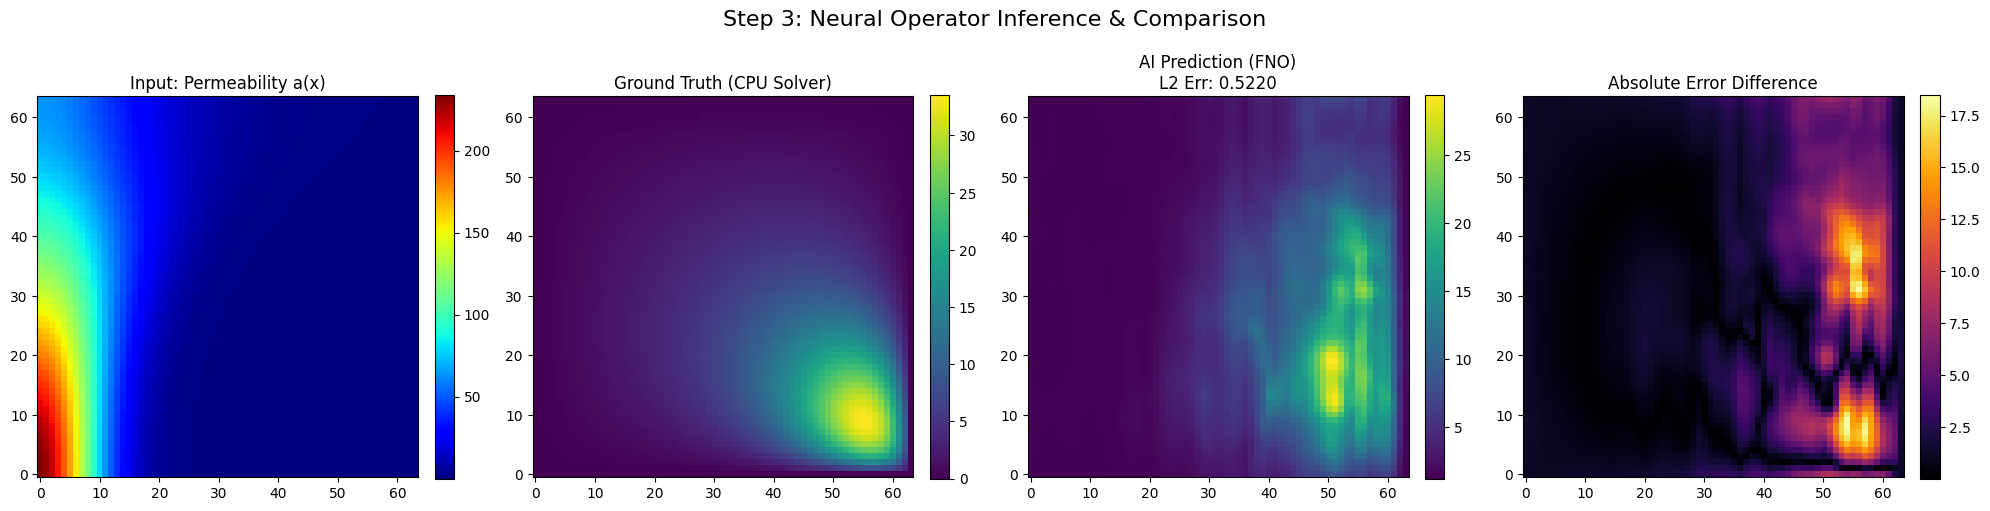

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# [Model Architecture] Fourier Neural Operator (FNO)
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Fourier Mode 개수 (X축)
        self.modes2 = modes2 # Fourier Mode 개수 (Y축)

        self.scale = (1 / (in_channels * out_channels))
        # 복소수 가중치 (Complex Weights)
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # (Batch, In, x, y), (In, Out, x, y) -> (Batch, Out, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        
        # 1. Fourier Transform (Real -> Complex)
        x_ft = torch.fft.rfft2(x)

        # 2. 주파수 영역에서 가중치 곱셈 (저주파 영역만 필터링)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # 3. Inverse Fourier Transform (Complex -> Real)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width

        # 입력: (a, x, y) 좌표 정보 포함 -> 3채널
        self.fc0 = nn.Linear(3, self.width) 

        # 4개의 Fourier Layer
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        
        # Skip Connection용 1x1 Conv
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        # Output Projector
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1) # Output Channel = 1 (Pressure u)

    def forward(self, x):
        # x: (Batch, 1, 64, 64) -> Permeability
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1) # (Batch, 3, 64, 64)
        
        x = x.permute(0, 2, 3, 1) # (Batch, 64, 64, 3)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2) # (Batch, Width, 64, 64)

        # Layer 1
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)

        # Layer 2
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)
        
        # Layer 3
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)

        # Layer 4
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        
        # Output Projection
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

# ----------------------------------------------------------------
# [Training] 학습 루프
# ----------------------------------------------------------------
# 하이퍼파라미터
EPOCHS = 200
LEARNING_RATE = 0.001
MODES = 12 # 주파수 모드 개수 (높을수록 고주파 디테일 학습)
WIDTH = 32 # 채널 수

model = FNO2d(modes=MODES, width=WIDTH).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5) # 학습률 감소
criterion = nn.MSELoss()

print(f"🚀 Training FNO Model (Samples: {len(train_loader.dataset)})...")

loss_history = []
for epoch in range(EPOCHS):
    model.train()
    train_mse = 0.0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        train_mse += loss.item() * x_batch.size(0)
        
    scheduler.step()
    train_mse /= len(train_loader.dataset)
    loss_history.append(train_mse)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}: MSE Loss: {train_mse:.6f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# [Comparison] Inference & Visualization
# ----------------------------------------------------------------
model.eval()

# 테스트셋 중 하나 선택
test_idx = 0 
x_in = x_test_tensor[test_idx:test_idx+1].to(device) # (1, 1, 64, 64)
y_gt = y_test_tensor[test_idx:test_idx+1].to(device) # Ground Truth

# AI 추론 (Inference)
with torch.no_grad():
    y_pred = model(x_in)

# GPU -> CPU -> Numpy 변환
x_plot = x_in.cpu().numpy()[0, 0]
y_gt_plot = y_gt.cpu().numpy()[0, 0]
y_pred_plot = y_pred.cpu().numpy()[0, 0]
error_plot = np.abs(y_gt_plot - y_pred_plot)

# 정확도 계산
mse_error = np.mean(error_plot**2)
rel_l2_error = np.linalg.norm(error_plot) / np.linalg.norm(y_gt_plot)

print("-" * 50)
print(f"📊 Evaluation Result (Sample {test_idx})")
print(f"   MSE Error: {mse_error:.6f}")
print(f"   Relative L2 Error: {rel_l2_error:.6f} (낮을수록 좋음, < 0.05 우수)")
print("-" * 50)

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1. Input (a)
im1 = axes[0].imshow(x_plot, origin='lower', cmap='jet')
axes[0].set_title("Input: Permeability a(x)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# 2. Ground Truth (u)
im2 = axes[1].imshow(y_gt_plot, origin='lower', cmap='viridis')
axes[1].set_title("Ground Truth (CPU Solver)")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# 3. AI Prediction (u_hat)
im3 = axes[2].imshow(y_pred_plot, origin='lower', cmap='viridis')
axes[2].set_title(f"AI Prediction (FNO)\nL2 Err: {rel_l2_error:.4f}")
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

# 4. Error Map (|u - u_hat|)
im4 = axes[3].imshow(error_plot, origin='lower', cmap='inferno')
axes[3].set_title("Absolute Error Difference")
plt.colorbar(im4, ax=axes[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("Step 3: Neural Operator Inference & Comparison", y=1.05, fontsize=16)
plt.show()

# trail failed!!!

# try2 normalize

Using device: cuda
🚀 Training FNO with Normalization (Samples: 2000)...
Epoch 10/200: Norm MSE Loss: 0.991556
Epoch 20/200: Norm MSE Loss: 0.977174
Epoch 30/200: Norm MSE Loss: 0.959408
Epoch 40/200: Norm MSE Loss: 0.910494
Epoch 50/200: Norm MSE Loss: 0.810915
Epoch 60/200: Norm MSE Loss: 0.679270
Epoch 70/200: Norm MSE Loss: 0.550924
Epoch 80/200: Norm MSE Loss: 0.478463
Epoch 90/200: Norm MSE Loss: 0.444035
Epoch 100/200: Norm MSE Loss: 0.424090
Epoch 110/200: Norm MSE Loss: 0.408715
Epoch 120/200: Norm MSE Loss: 0.400710
Epoch 130/200: Norm MSE Loss: 0.393812
Epoch 140/200: Norm MSE Loss: 0.390181
Epoch 150/200: Norm MSE Loss: 0.386035
Epoch 160/200: Norm MSE Loss: 0.384197
Epoch 170/200: Norm MSE Loss: 0.382548
Epoch 180/200: Norm MSE Loss: 0.381427
Epoch 190/200: Norm MSE Loss: 0.380604
Epoch 200/200: Norm MSE Loss: 0.380111
✅ Training Complete!
--------------------------------------------------
📊 Evaluation Result (Sample 0)
   MSE Error: 144.615173
   Relative L2 Error: 1.49955

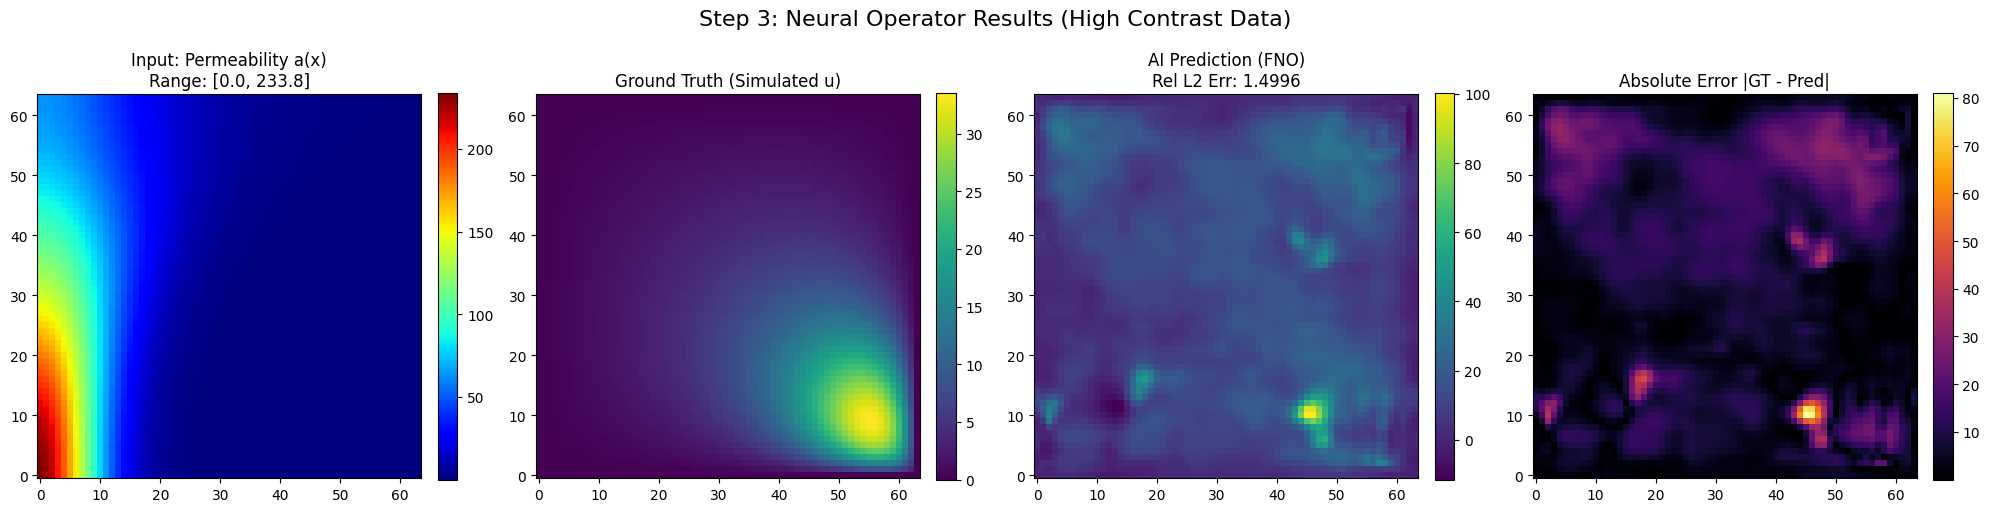

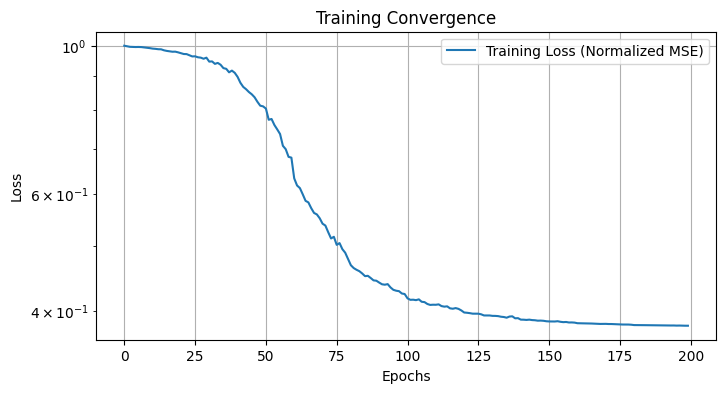

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# 1. Utilities: Data Normalizer (필수)
# ----------------------------------------------------------------
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=1e-5):
        super(UnitGaussianNormalizer, self).__init__()
        # 데이터의 평균과 표준편차를 계산하여 저장
        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        # 정규화 (x - mean) / std
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x):
        # 역변환 (x * std) + mean -> 원래 스케일로 복원
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()
        return self

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()
        return self

# ----------------------------------------------------------------
# 2. Model Architecture: Fourier Neural Operator (FNO)
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Fourier Mode (X축 저주파 개수)
        self.modes2 = modes2 # Fourier Mode (Y축 저주파 개수)

        self.scale = (1 / (in_channels * out_channels))
        # 복소수 가중치 초기화
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # 복소수 행렬 곱셈: (Batch, In, x, y) x (In, Out, x, y) -> (Batch, Out, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        
        # 1. Fourier Transform (Real -> Complex)
        x_ft = torch.fft.rfft2(x)

        # 2. 주파수 영역 곱셈 (필터링)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # 3. Inverse Fourier Transform (Complex -> Real)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width

        # 입력 채널 3 (a, grid_x, grid_y) -> Hidden Width
        self.fc0 = nn.Linear(3, self.width) 

        # 4개의 Fourier Layer
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        
        # Skip Connection (ResNet 구조)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        # Output Projection
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1) # Output: Pressure u

    def forward(self, x):
        # x: (Batch, 1, 64, 64) -> Permeability a
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1) # (Batch, 3, 64, 64)
        
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        # Layer 1
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)

        # Layer 2
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)
        
        # Layer 3
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)

        # Layer 4
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        
        # Final Layer
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

# ----------------------------------------------------------------
# 3. Data Preparation with Normalization
# ----------------------------------------------------------------
# Step 2에서 생성된 텐서가 있다고 가정 (x_train_tensor, y_train_tensor)
# 데이터 정규화 (학습 수렴을 위해 필수)
x_normalizer = UnitGaussianNormalizer(x_train_tensor)
y_normalizer = UnitGaussianNormalizer(y_train_tensor)

x_train_norm = x_normalizer.encode(x_train_tensor)
y_train_norm = y_normalizer.encode(y_train_tensor)
x_test_norm = x_normalizer.encode(x_test_tensor)
y_test_norm = y_normalizer.encode(y_test_tensor)

# 정규화된 데이터로 DataLoader 생성
train_loader = DataLoader(
    TensorDataset(x_train_norm, y_train_norm),
    batch_size=32, 
    shuffle=True
)

# Inference 시 GPU 사용을 위해 Normalizer 이동
x_normalizer.cuda()
y_normalizer.cuda()

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
EPOCHS = 200 # 필요시 더 늘릴 수 있음
LEARNING_RATE = 0.001
MODES = 12
WIDTH = 32

model = FNO2d(modes=MODES, width=WIDTH).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.MSELoss()

print(f"🚀 Training FNO with Normalization (Samples: {len(x_train_tensor)})...")

loss_history = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out = model(x_batch)
        
        # 정규화된 공간에서의 MSE Loss
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x_batch.size(0)
    
    scheduler.step()
    train_loss /= len(train_loader.dataset)
    loss_history.append(train_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}: Norm MSE Loss: {train_loss:.6f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# 5. Inference & Comparison Visualization
# ----------------------------------------------------------------
model.eval()

# 테스트 샘플 하나 선택
test_idx = 0
x_in = x_test_tensor[test_idx:test_idx+1].to(device) # Original Scale Input
y_gt = y_test_tensor[test_idx:test_idx+1].to(device) # Original Scale Ground Truth

with torch.no_grad():
    # 1. 입력 정규화
    x_in_norm = x_normalizer.encode(x_in)
    # 2. 모델 예측 (Normalized Output)
    y_pred_norm = model(x_in_norm)
    # 3. 출력 복원 (Denormalization) -> 원래 물리량 스케일로 변환
    y_pred = y_normalizer.decode(y_pred_norm)

# CPU로 가져오기 (시각화용)
x_plot = x_in.cpu().numpy()[0, 0]
y_gt_plot = y_gt.cpu().numpy()[0, 0]
y_pred_plot = y_pred.cpu().numpy()[0, 0]
error_plot = np.abs(y_gt_plot - y_pred_plot)

# 오차 계산
mse_val = np.mean((y_gt_plot - y_pred_plot)**2)
rel_l2 = np.linalg.norm(y_gt_plot - y_pred_plot) / np.linalg.norm(y_gt_plot)

print("-" * 50)
print(f"📊 Evaluation Result (Sample {test_idx})")
print(f"   MSE Error: {mse_val:.6f}")
print(f"   Relative L2 Error: {rel_l2:.6f}")
print("-" * 50)

# 결과 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Input Permeability
im1 = axes[0].imshow(x_plot, origin='lower', cmap='jet')
axes[0].set_title(f"Input: Permeability a(x)\nRange: [{x_plot.min():.1f}, {x_plot.max():.1f}]")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Ground Truth
im2 = axes[1].imshow(y_gt_plot, origin='lower', cmap='viridis')
axes[1].set_title("Ground Truth (Simulated u)")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Prediction
im3 = axes[2].imshow(y_pred_plot, origin='lower', cmap='viridis')
axes[2].set_title(f"AI Prediction (FNO)\nRel L2 Err: {rel_l2:.4f}")
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

# Error Map
im4 = axes[3].imshow(error_plot, origin='lower', cmap='inferno')
axes[3].set_title("Absolute Error |GT - Pred|")
plt.colorbar(im4, ax=axes[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle("Step 3: Neural Operator Results (High Contrast Data)", y=1.05, fontsize=16)
plt.show()

# Loss History Graph
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss (Normalized MSE)')
plt.yscale('log')
plt.title("Training Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#  try3 log normalize 

Using device: cuda
preprocessing data...
🚀 Training FNO (Log-Scaled Input, Width=64)...
Epoch 20/200: Norm MSE Loss: 0.314603
Epoch 40/200: Norm MSE Loss: 0.493157
Epoch 60/200: Norm MSE Loss: 0.347369
Epoch 80/200: Norm MSE Loss: 0.129433
Epoch 100/200: Norm MSE Loss: 0.103603
Epoch 120/200: Norm MSE Loss: 0.004717
Epoch 140/200: Norm MSE Loss: 0.009752
Epoch 160/200: Norm MSE Loss: 0.001801
Epoch 180/200: Norm MSE Loss: 0.001511
Epoch 200/200: Norm MSE Loss: 0.001442
✅ Training Complete!
--------------------------------------------------
📊 New Evaluation Result
   Relative L2 Error: 0.088164
--------------------------------------------------


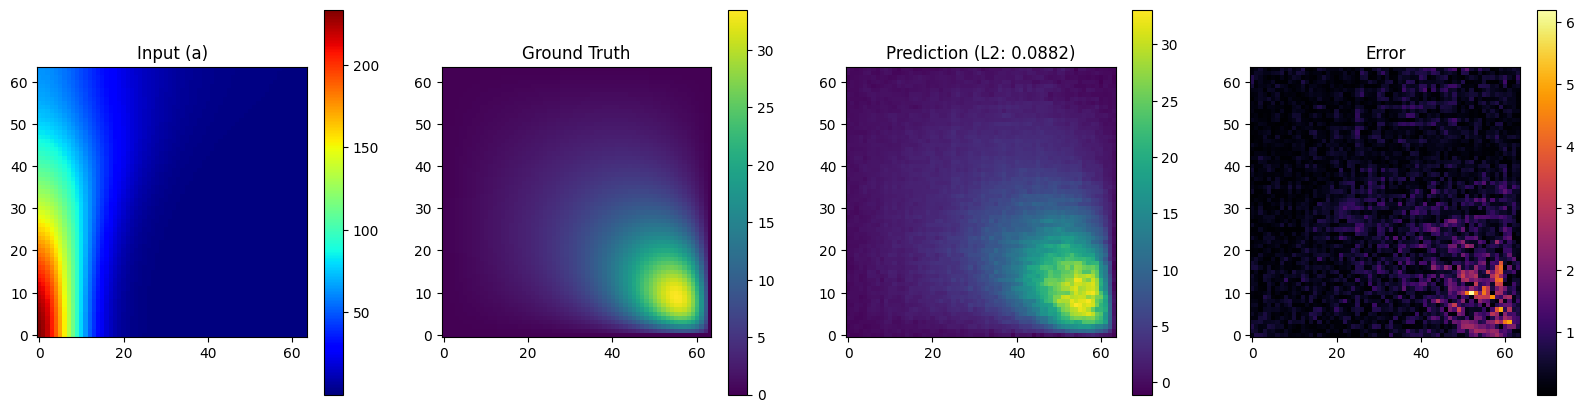

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# 1. Normalizer (기존 유지)
# ----------------------------------------------------------------
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=1e-5):
        super(UnitGaussianNormalizer, self).__init__()
        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return (x * (self.std + self.eps)) + self.mean

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()
        return self

# ----------------------------------------------------------------
# 2. FNO Model (동일하지만 Width 증가 권장)
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width) 
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv0(x) + self.w0(x); x = torch.nn.functional.gelu(x)
        x = self.conv1(x) + self.w1(x); x = torch.nn.functional.gelu(x)
        x = self.conv2(x) + self.w2(x); x = torch.nn.functional.gelu(x)
        x = self.conv3(x) + self.w3(x)
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

# ----------------------------------------------------------------
# 3. Data Preparation with LOG-SCALING
# ----------------------------------------------------------------
# Step 2의 데이터가 있다고 가정합니다.
print("preprocessing data...")

# [핵심 변경 1] 입력 데이터 a에 Log를 취합니다.
# a는 항상 양수이므로 안전하게 log 가능
x_train_log = torch.log(x_train_tensor)
x_test_log = torch.log(x_test_tensor)

# [핵심 변경 2] Log 취한 값을 Normalization 합니다.
x_normalizer = UnitGaussianNormalizer(x_train_log)
y_normalizer = UnitGaussianNormalizer(y_train_tensor) # 출력 u는 그대로 정규화

x_train_norm = x_normalizer.encode(x_train_log)
y_train_norm = y_normalizer.encode(y_train_tensor)

# DataLoader 생성
train_loader = DataLoader(
    TensorDataset(x_train_norm, y_train_norm),
    batch_size=32, 
    shuffle=True
)

x_normalizer.cuda()
y_normalizer.cuda()

# ----------------------------------------------------------------
# 4. Training Loop (Capacity Increased)
# ----------------------------------------------------------------
EPOCHS = 200       # 에포크 증가
LEARNING_RATE = 0.001
MODES = 16         # 모드 증가 (12 -> 16)
WIDTH = 64         # 채널 폭 증가 (32 -> 64)

model = FNO2d(modes=MODES, width=WIDTH).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS) # 스케줄러 변경
criterion = nn.MSELoss()

print(f"🚀 Training FNO (Log-Scaled Input, Width={WIDTH})...")

loss_history = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item() * x_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    loss_history.append(train_loss)
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}: Norm MSE Loss: {train_loss:.6f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# 5. Inference & Evaluation
# ----------------------------------------------------------------
model.eval()
test_idx = 0

# 테스트 데이터 준비 (Log Scaling 적용 필수!)
x_in = x_test_tensor[test_idx:test_idx+1].to(device)
y_gt = y_test_tensor[test_idx:test_idx+1].to(device)

with torch.no_grad():
    # 1. 입력 전처리: Log -> Normalize
    x_in_log = torch.log(x_in)
    x_in_norm = x_normalizer.encode(x_in_log)
    
    # 2. 추론
    y_pred_norm = model(x_in_norm)
    
    # 3. 복원
    y_pred = y_normalizer.decode(y_pred_norm)

# CPU 변환
x_plot = x_in.cpu().numpy()[0, 0]
y_gt_plot = y_gt.cpu().numpy()[0, 0]
y_pred_plot = y_pred.cpu().numpy()[0, 0]
error_plot = np.abs(y_gt_plot - y_pred_plot)

# 오차 계산
rel_l2 = np.linalg.norm(y_gt_plot - y_pred_plot) / np.linalg.norm(y_gt_plot)

print("-" * 50)
print(f"📊 New Evaluation Result")
print(f"   Relative L2 Error: {rel_l2:.6f}")
print("-" * 50)

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
im1 = axes[0].imshow(x_plot, origin='lower', cmap='jet')
axes[0].set_title("Input (a)")
plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(y_gt_plot, origin='lower', cmap='viridis')
axes[1].set_title("Ground Truth")
plt.colorbar(im2, ax=axes[1])
im3 = axes[2].imshow(y_pred_plot, origin='lower', cmap='viridis')
axes[2].set_title(f"Prediction (L2: {rel_l2:.4f})")
plt.colorbar(im3, ax=axes[2])
im4 = axes[3].imshow(error_plot, origin='lower', cmap='inferno')
axes[3].set_title("Error")
plt.colorbar(im4, ax=axes[3])
plt.show()

In [ ]:
# increase iteration

Using device: cuda
preprocessing data...
🚀 Training FNO (Log-Scaled Input, Width=64)...
Epoch 20/2000: Norm MSE Loss: 0.541127
Epoch 40/2000: Norm MSE Loss: 0.246558
Epoch 60/2000: Norm MSE Loss: 0.102369
Epoch 80/2000: Norm MSE Loss: 0.059528
Epoch 100/2000: Norm MSE Loss: 0.046404
Epoch 120/2000: Norm MSE Loss: 0.083905
Epoch 140/2000: Norm MSE Loss: 0.080122
Epoch 160/2000: Norm MSE Loss: 0.394971
Epoch 180/2000: Norm MSE Loss: 0.020850
Epoch 200/2000: Norm MSE Loss: 0.614388
Epoch 220/2000: Norm MSE Loss: 0.047898
Epoch 240/2000: Norm MSE Loss: 0.009591
Epoch 260/2000: Norm MSE Loss: 0.008651
Epoch 280/2000: Norm MSE Loss: 0.073385
Epoch 300/2000: Norm MSE Loss: 0.047503
Epoch 320/2000: Norm MSE Loss: 0.050005
Epoch 340/2000: Norm MSE Loss: 0.021335
Epoch 360/2000: Norm MSE Loss: 0.022658
Epoch 380/2000: Norm MSE Loss: 0.007752
Epoch 400/2000: Norm MSE Loss: 0.195675
Epoch 420/2000: Norm MSE Loss: 0.072526
Epoch 440/2000: Norm MSE Loss: 0.039581
Epoch 460/2000: Norm MSE Loss: 0.040

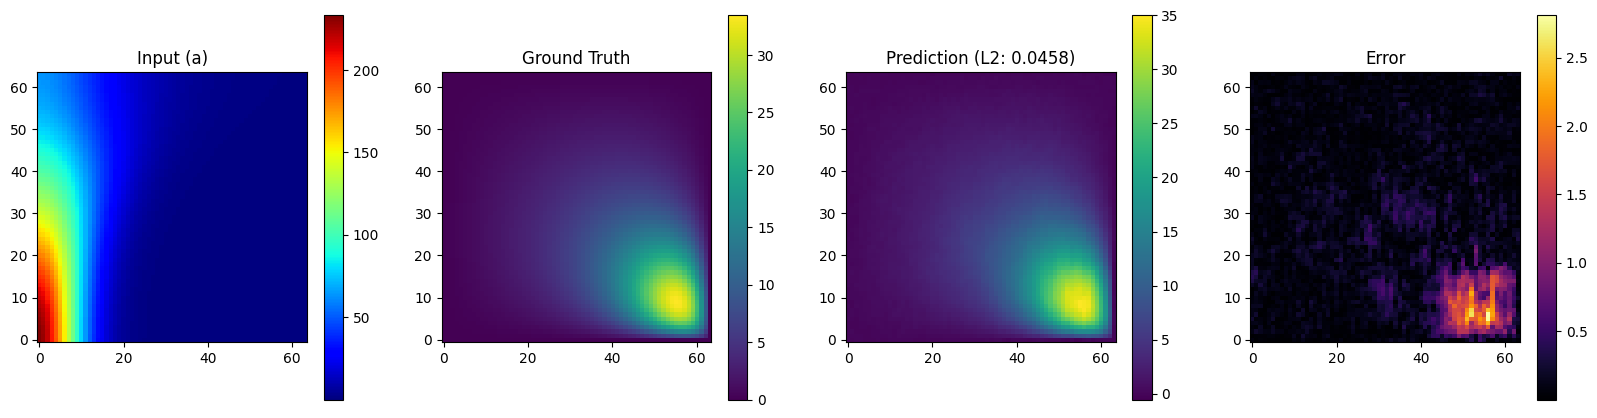

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# 1. Normalizer (기존 유지)
# ----------------------------------------------------------------
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=1e-5):
        super(UnitGaussianNormalizer, self).__init__()
        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return (x * (self.std + self.eps)) + self.mean

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()
        return self

# ----------------------------------------------------------------
# 2. FNO Model (동일하지만 Width 증가 권장)
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width) 
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv0(x) + self.w0(x); x = torch.nn.functional.gelu(x)
        x = self.conv1(x) + self.w1(x); x = torch.nn.functional.gelu(x)
        x = self.conv2(x) + self.w2(x); x = torch.nn.functional.gelu(x)
        x = self.conv3(x) + self.w3(x)
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

# ----------------------------------------------------------------
# 3. Data Preparation with LOG-SCALING
# ----------------------------------------------------------------
# Step 2의 데이터가 있다고 가정합니다.
print("preprocessing data...")

# [핵심 변경 1] 입력 데이터 a에 Log를 취합니다.
# a는 항상 양수이므로 안전하게 log 가능
x_train_log = torch.log(x_train_tensor)
x_test_log = torch.log(x_test_tensor)

# [핵심 변경 2] Log 취한 값을 Normalization 합니다.
x_normalizer = UnitGaussianNormalizer(x_train_log)
y_normalizer = UnitGaussianNormalizer(y_train_tensor) # 출력 u는 그대로 정규화

x_train_norm = x_normalizer.encode(x_train_log)
y_train_norm = y_normalizer.encode(y_train_tensor)

# DataLoader 생성
train_loader = DataLoader(
    TensorDataset(x_train_norm, y_train_norm),
    batch_size=32, 
    shuffle=True
)

x_normalizer.cuda()
y_normalizer.cuda()

# ----------------------------------------------------------------
# 4. Training Loop (Capacity Increased)
# ----------------------------------------------------------------
EPOCHS = 2000       # 에포크 증가
LEARNING_RATE = 0.001
MODES = 16         # 모드 증가 (12 -> 16)
WIDTH = 64         # 채널 폭 증가 (32 -> 64)

model = FNO2d(modes=MODES, width=WIDTH).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS) # 스케줄러 변경
criterion = nn.MSELoss()

print(f"🚀 Training FNO (Log-Scaled Input, Width={WIDTH})...")

loss_history = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item() * x_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    loss_history.append(train_loss)
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}: Norm MSE Loss: {train_loss:.6f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# 5. Inference & Evaluation
# ----------------------------------------------------------------
model.eval()
test_idx = 0

# 테스트 데이터 준비 (Log Scaling 적용 필수!)
x_in = x_test_tensor[test_idx:test_idx+1].to(device)
y_gt = y_test_tensor[test_idx:test_idx+1].to(device)

with torch.no_grad():
    # 1. 입력 전처리: Log -> Normalize
    x_in_log = torch.log(x_in)
    x_in_norm = x_normalizer.encode(x_in_log)
    
    # 2. 추론
    y_pred_norm = model(x_in_norm)
    
    # 3. 복원
    y_pred = y_normalizer.decode(y_pred_norm)

# CPU 변환
x_plot = x_in.cpu().numpy()[0, 0]
y_gt_plot = y_gt.cpu().numpy()[0, 0]
y_pred_plot = y_pred.cpu().numpy()[0, 0]
error_plot = np.abs(y_gt_plot - y_pred_plot)

# 오차 계산
rel_l2 = np.linalg.norm(y_gt_plot - y_pred_plot) / np.linalg.norm(y_gt_plot)

print("-" * 50)
print(f"📊 New Evaluation Result")
print(f"   Relative L2 Error: {rel_l2:.6f}")
print("-" * 50)

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
im1 = axes[0].imshow(x_plot, origin='lower', cmap='jet')
axes[0].set_title("Input (a)")
plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(y_gt_plot, origin='lower', cmap='viridis')
axes[1].set_title("Ground Truth")
plt.colorbar(im2, ax=axes[1])
im3 = axes[2].imshow(y_pred_plot, origin='lower', cmap='viridis')
axes[2].set_title(f"Prediction (L2: {rel_l2:.4f})")
plt.colorbar(im3, ax=axes[2])
im4 = axes[3].imshow(error_plot, origin='lower', cmap='inferno')
axes[3].set_title("Error")
plt.colorbar(im4, ax=axes[3])
plt.show()

# detail  increase  mode, width 

Using device: cuda
preprocessing data...
🚀 Training FNO (Log-Scaled Input, Width=128)...
Epoch 20/200: Norm MSE Loss: 0.211685
Epoch 40/200: Norm MSE Loss: 0.463240
Epoch 60/200: Norm MSE Loss: 0.058353
Epoch 80/200: Norm MSE Loss: 0.021670
Epoch 100/200: Norm MSE Loss: 0.184642
Epoch 120/200: Norm MSE Loss: 0.009202
Epoch 140/200: Norm MSE Loss: 0.015920
Epoch 160/200: Norm MSE Loss: 0.003377
Epoch 180/200: Norm MSE Loss: 0.002718
Epoch 200/200: Norm MSE Loss: 0.002581
✅ Training Complete!
--------------------------------------------------
📊 New Evaluation Result
   Relative L2 Error: 0.162173
--------------------------------------------------


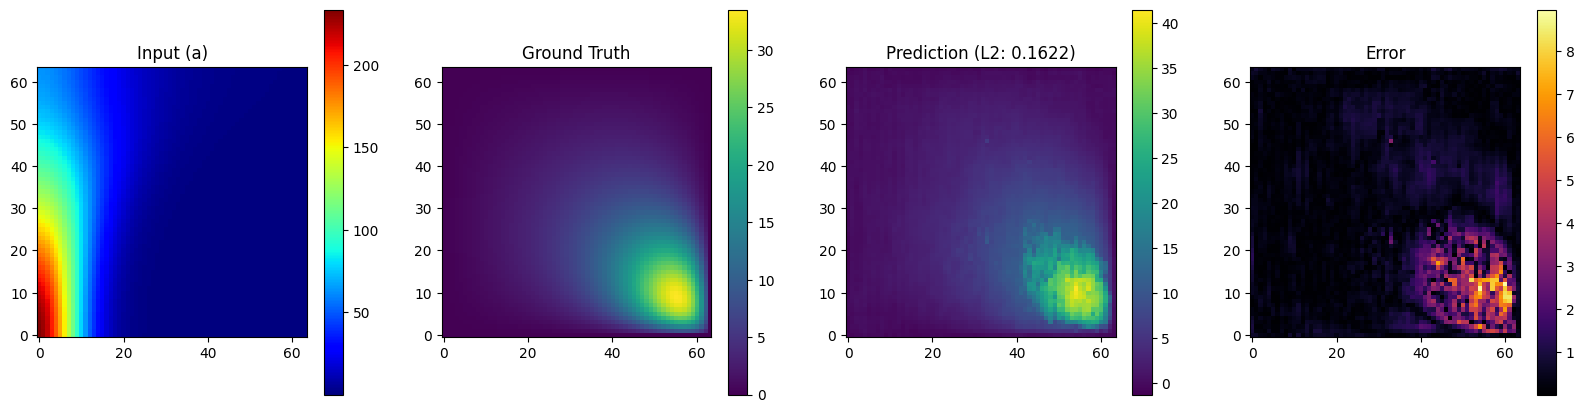

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# 1. Normalizer (기존 유지)
# ----------------------------------------------------------------
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=1e-5):
        super(UnitGaussianNormalizer, self).__init__()
        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return (x * (self.std + self.eps)) + self.mean

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()
        return self

# ----------------------------------------------------------------
# 2. FNO Model (동일하지만 Width 증가 권장)
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width) 
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv0(x) + self.w0(x); x = torch.nn.functional.gelu(x)
        x = self.conv1(x) + self.w1(x); x = torch.nn.functional.gelu(x)
        x = self.conv2(x) + self.w2(x); x = torch.nn.functional.gelu(x)
        x = self.conv3(x) + self.w3(x)
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

# ----------------------------------------------------------------
# 3. Data Preparation with LOG-SCALING
# ----------------------------------------------------------------
# Step 2의 데이터가 있다고 가정합니다.
print("preprocessing data...")

# [핵심 변경 1] 입력 데이터 a에 Log를 취합니다.
# a는 항상 양수이므로 안전하게 log 가능
x_train_log = torch.log(x_train_tensor)
x_test_log = torch.log(x_test_tensor)

# [핵심 변경 2] Log 취한 값을 Normalization 합니다.
x_normalizer = UnitGaussianNormalizer(x_train_log)
y_normalizer = UnitGaussianNormalizer(y_train_tensor) # 출력 u는 그대로 정규화

x_train_norm = x_normalizer.encode(x_train_log)
y_train_norm = y_normalizer.encode(y_train_tensor)

# DataLoader 생성
train_loader = DataLoader(
    TensorDataset(x_train_norm, y_train_norm),
    batch_size=32, 
    shuffle=True
)

x_normalizer.cuda()
y_normalizer.cuda()

# ----------------------------------------------------------------
# 4. Training Loop (Capacity Increased)
# ----------------------------------------------------------------
EPOCHS = 200       # 에포크 증가
LEARNING_RATE = 0.001
MODES = 24         # 모드 증가 (12 -> 16)
WIDTH = 128         # 채널 폭 증가 (32 -> 64)

model = FNO2d(modes=MODES, width=WIDTH).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS) # 스케줄러 변경
criterion = nn.MSELoss()

print(f"🚀 Training FNO (Log-Scaled Input, Width={WIDTH})...")

loss_history = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item() * x_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    loss_history.append(train_loss)
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}: Norm MSE Loss: {train_loss:.6f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# 5. Inference & Evaluation
# ----------------------------------------------------------------
model.eval()
test_idx = 0

# 테스트 데이터 준비 (Log Scaling 적용 필수!)
x_in = x_test_tensor[test_idx:test_idx+1].to(device)
y_gt = y_test_tensor[test_idx:test_idx+1].to(device)

with torch.no_grad():
    # 1. 입력 전처리: Log -> Normalize
    x_in_log = torch.log(x_in)
    x_in_norm = x_normalizer.encode(x_in_log)
    
    # 2. 추론
    y_pred_norm = model(x_in_norm)
    
    # 3. 복원
    y_pred = y_normalizer.decode(y_pred_norm)

# CPU 변환
x_plot = x_in.cpu().numpy()[0, 0]
y_gt_plot = y_gt.cpu().numpy()[0, 0]
y_pred_plot = y_pred.cpu().numpy()[0, 0]
error_plot = np.abs(y_gt_plot - y_pred_plot)

# 오차 계산
rel_l2 = np.linalg.norm(y_gt_plot - y_pred_plot) / np.linalg.norm(y_gt_plot)

print("-" * 50)
print(f"📊 New Evaluation Result")
print(f"   Relative L2 Error: {rel_l2:.6f}")
print("-" * 50)

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
im1 = axes[0].imshow(x_plot, origin='lower', cmap='jet')
axes[0].set_title("Input (a)")
plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(y_gt_plot, origin='lower', cmap='viridis')
axes[1].set_title("Ground Truth")
plt.colorbar(im2, ax=axes[1])
im3 = axes[2].imshow(y_pred_plot, origin='lower', cmap='viridis')
axes[2].set_title(f"Prediction (L2: {rel_l2:.4f})")
plt.colorbar(im3, ax=axes[2])
im4 = axes[3].imshow(error_plot, origin='lower', cmap='inferno')
axes[3].set_title("Error")
plt.colorbar(im4, ax=axes[3])
plt.show()

# try3 patch driven

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import gc # 가비지 컬렉션 (메모리 정리용)

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# 1. Patch Processor (텐서 차원 조작)
# ----------------------------------------------------------------
class PatchProcessor:
    def __init__(self, grid_size):
        self.grid_size = grid_size
        
    def create_patches(self, x):
        B, C, H, W = x.shape
        p_h = H // self.grid_size
        p_w = W // self.grid_size
        x = x.view(B, C, self.grid_size, p_h, self.grid_size, p_w)
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.reshape(-1, C, p_h, p_w)
        return x

    def reconstruct_from_patches(self, patches, original_batch_size):
        total, C, p_h, p_w = patches.shape
        patches = patches.view(original_batch_size, self.grid_size, self.grid_size, C, p_h, p_w)
        patches = patches.permute(0, 3, 1, 4, 2, 5)
        H = self.grid_size * p_h
        W = self.grid_size * p_w
        return patches.reshape(original_batch_size, C, H, W)

# ----------------------------------------------------------------
# 2. Normalizer & FNO Model
# ----------------------------------------------------------------
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=1e-5):
        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps
    def encode(self, x): return (x - self.mean) / (self.std + self.eps)
    def decode(self, x): return (x * (self.std + self.eps)) + self.mean
    def cuda(self): self.mean = self.mean.cuda(); self.std = self.std.cuda(); return self

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels; self.out_channels = out_channels
        self.modes1 = modes1; self.modes2 = modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        eff_modes1 = min(self.modes1, out_ft.size(2))
        eff_modes2 = min(self.modes2, out_ft.size(3))
        
        out_ft[:, :, :eff_modes1, :eff_modes2] = self.compl_mul2d(x_ft[:, :, :eff_modes1, :eff_modes2], self.weights1[:, :, :eff_modes1, :eff_modes2])
        out_ft[:, :, -eff_modes1:, :eff_modes2] = self.compl_mul2d(x_ft[:, :, -eff_modes1:, :eff_modes2], self.weights2[:, :, :eff_modes1, :eff_modes2])
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes; self.modes2 = modes; self.width = width
        self.fc0 = nn.Linear(3, self.width) 
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv0(x) + self.w0(x); x = torch.nn.functional.gelu(x)
        x = self.conv1(x) + self.w1(x)
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

Using device: cuda


In [19]:
# 기존 데이터가 있으면 재사용, 없으면 생성
if 'x_train_tensor' not in locals():
    print("⚠️ 데이터를 생성합니다. (실제로는 앞선 Step 2 실행 권장)")
    # 임시 데이터 (실제 데이터가 있다면 이 부분은 스킵됩니다)
    x_train_tensor = torch.exp(torch.randn(1000, 1, 64, 64)) 
    y_train_tensor = torch.randn(1000, 1, 64, 64)
    x_test_tensor = torch.exp(torch.randn(20, 1, 64, 64))
    y_test_tensor = torch.randn(20, 1, 64, 64)

# GPU 메모리 절약을 위해 데이터는 CPU에 둡니다.
x_train_tensor = x_train_tensor.cpu()
y_train_tensor = y_train_tensor.cpu()
x_test_tensor = x_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()
print("✅ 데이터 준비 완료")

✅ 데이터 준비 완료



🧩 START: 4x4 Patch Experiment
   Preprocessing...
   Creating Patches...
   Original Samples: 2000
   Patched Samples: 32000 (x16)
   Patch Res: 16x16, Modes: 8
   Training...
   Epoch 10: Loss 0.61039
   Epoch 20: Loss 0.17182
   Epoch 30: Loss 0.26633
   Epoch 40: Loss 0.32892
   Epoch 50: Loss 0.13053
   Epoch 60: Loss 0.14810
   Epoch 70: Loss 0.10691
   Epoch 80: Loss 0.09087
   Epoch 90: Loss 0.08749
   Epoch 100: Loss 0.27426
   Epoch 110: Loss 0.19181
   Epoch 120: Loss 0.17092
   Epoch 130: Loss 0.15132
   Epoch 140: Loss 0.32949
   Epoch 150: Loss 0.06333
   Epoch 160: Loss 0.09245
   Epoch 170: Loss 0.06916
   Epoch 180: Loss 0.06580
   Epoch 190: Loss 0.09178
   Epoch 200: Loss 0.07030
   Inference & Visualize...


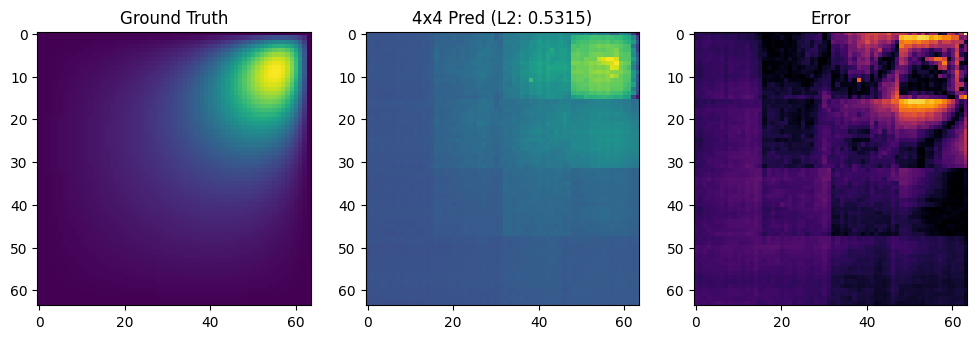

🗑️ 4x4 Experiment Memory Cleared.


In [20]:
# ----------------------------------------------------------------
# 실험 A: 4x4 Patch (Grid Size = 4)
# ----------------------------------------------------------------
def run_experiment_4x4():
    print(f"\n{'='*40}\n🧩 START: 4x4 Patch Experiment\n{'='*40}")
    
    GRID_SIZE = 4
    EPOCHS = 200
    BATCH_SIZE = 64
    
    # 1. 전처리 (Log -> Norm)
    print("   Preprocessing...")
    x_train_log = torch.log(x_train_tensor)
    x_norm = UnitGaussianNormalizer(x_train_log)
    y_norm = UnitGaussianNormalizer(y_train_tensor)
    
    x_train_n = x_norm.encode(x_train_log)
    y_train_n = y_norm.encode(y_train_tensor)
    
    # 2. 패치 생성
    print("   Creating Patches...")
    processor = PatchProcessor(GRID_SIZE)
    x_patch = processor.create_patches(x_train_n)
    y_patch = processor.create_patches(y_train_n)
    
    print(f"   Original Samples: {len(x_train_tensor)}")
    print(f"   Patched Samples: {len(x_patch)} (x16)")
    
    # 3. 모델 설정
    patch_res = 64 // GRID_SIZE
    modes = min(12, patch_res // 2)
    print(f"   Patch Res: {patch_res}x{patch_res}, Modes: {modes}")
    
    # 데이터 로더
    loader = DataLoader(TensorDataset(x_patch, y_patch), batch_size=BATCH_SIZE, shuffle=True)
    
    # 모델 생성 (GPU로 이동)
    model = FNO2d(modes=modes, width=64).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # 4. 학습
    print("   Training...")
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch+1) % 10 == 0:
            print(f"   Epoch {epoch+1}: Loss {total_loss/len(loader):.5f}")
            
    # 5. 추론 및 시각화
    print("   Inference & Visualize...")
    model.eval()
    
    # Normalizer GPU 이동 (추론용)
    x_norm.cuda()
    y_norm.cuda()
    
    idx = 0
    # 전체 이미지 -> Log -> Norm -> Patch -> Predict -> Reconstruct -> Denorm
    x_in_full = x_test_tensor[idx:idx+1].to(device)
    y_gt_full = y_test_tensor[idx:idx+1].to(device)
    
    with torch.no_grad():
        x_in_log = torch.log(x_in_full)
        x_in_n = x_norm.encode(x_in_log)
        x_in_patch = processor.create_patches(x_in_n)
        
        y_pred_patch_n = model(x_in_patch)
        
        y_pred_full_n = processor.reconstruct_from_patches(y_pred_patch_n, 1)
        y_pred_full = y_norm.decode(y_pred_full_n)
        
    # 결과 출력
    gt = y_gt_full.cpu().numpy()[0,0]
    pred = y_pred_full.cpu().numpy()[0,0]
    err = np.abs(gt - pred)
    l2 = np.linalg.norm(gt - pred) / np.linalg.norm(gt)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(gt, cmap='viridis'); axes[0].set_title("Ground Truth")
    axes[1].imshow(pred, cmap='viridis'); axes[1].set_title(f"4x4 Pred (L2: {l2:.4f})")
    axes[2].imshow(err, cmap='inferno'); axes[2].set_title("Error")
    plt.show()
    
    return model # 삭제를 위해 반환

# 실행
model_4x4 = run_experiment_4x4()

# ----------------------------------------------------------------
# 🧹 MEMORY CLEANUP (중요!)
# ----------------------------------------------------------------
del model_4x4
gc.collect()
torch.cuda.empty_cache()
print("🗑️ 4x4 Experiment Memory Cleared.")


🧩 START: 8x8 Patch Experiment
   Preprocessing...
   Creating Patches...
   Original Samples: 2000
   Patched Samples: 128000 (x64)
   Patch Res: 8x8, Modes: 4
   Training...
   Epoch 10: Loss 0.39086
   Epoch 20: Loss 0.19344
   Epoch 30: Loss 0.28371
   Epoch 40: Loss 0.18237
   Epoch 50: Loss 0.18556
   Epoch 60: Loss 0.14899
   Epoch 70: Loss 0.17180
   Epoch 80: Loss 0.17183
   Epoch 90: Loss 0.18436
   Epoch 100: Loss 0.13855
   Epoch 110: Loss 0.13117
   Epoch 120: Loss 0.11925
   Epoch 130: Loss 0.13850
   Epoch 140: Loss 0.13317
   Epoch 150: Loss 0.16627
   Epoch 160: Loss 0.14065
   Epoch 170: Loss 0.12454
   Epoch 180: Loss 0.11830
   Epoch 190: Loss 0.11737
   Epoch 200: Loss 0.12577
   Inference & Visualize...


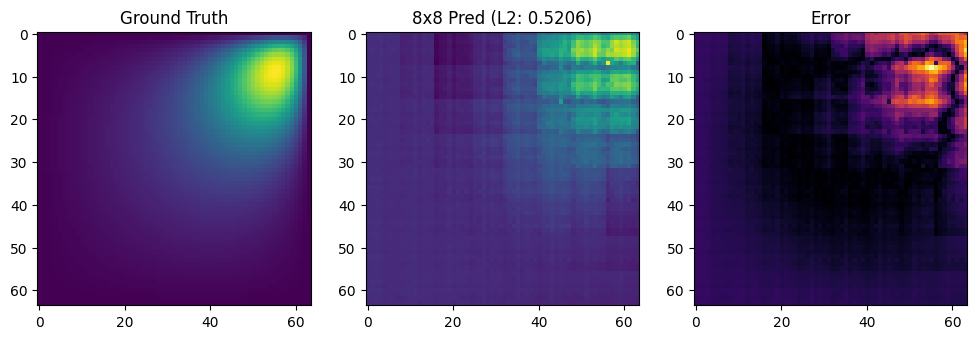

🗑️ 8x8 Experiment Memory Cleared.


In [22]:
# ----------------------------------------------------------------
# 실험 B: 8x8 Patch (Grid Size = 8)
# ----------------------------------------------------------------
def run_experiment_8x8():
    print(f"\n{'='*40}\n🧩 START: 8x8 Patch Experiment\n{'='*40}")
    
    GRID_SIZE = 8
    EPOCHS = 200
    BATCH_SIZE = 128 # 패치가 많아지므로 배치 사이즈 주의
    
    # 1. 전처리 (Log -> Norm)
    print("   Preprocessing...")
    x_train_log = torch.log(x_train_tensor)
    x_norm = UnitGaussianNormalizer(x_train_log)
    y_norm = UnitGaussianNormalizer(y_train_tensor)
    
    x_train_n = x_norm.encode(x_train_log)
    y_train_n = y_norm.encode(y_train_tensor)
    
    # 2. 패치 생성
    print("   Creating Patches...")
    processor = PatchProcessor(GRID_SIZE)
    x_patch = processor.create_patches(x_train_n)
    y_patch = processor.create_patches(y_train_n)
    
    print(f"   Original Samples: {len(x_train_tensor)}")
    print(f"   Patched Samples: {len(x_patch)} (x64)")
    
    # 3. 모델 설정
    patch_res = 64 // GRID_SIZE
    modes = min(12, patch_res // 2)
    print(f"   Patch Res: {patch_res}x{patch_res}, Modes: {modes}")
    
    # 데이터 로더
    loader = DataLoader(TensorDataset(x_patch, y_patch), batch_size=BATCH_SIZE, shuffle=True)
    
    # 모델 생성 (GPU로 이동)
    model = FNO2d(modes=modes, width=64).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # 4. 학습
    print("   Training...")
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch+1) % 10 == 0:
            print(f"   Epoch {epoch+1}: Loss {total_loss/len(loader):.5f}")
            
    # 5. 추론 및 시각화
    print("   Inference & Visualize...")
    model.eval()
    
    # Normalizer GPU 이동
    x_norm.cuda()
    y_norm.cuda()
    
    idx = 0
    x_in_full = x_test_tensor[idx:idx+1].to(device)
    y_gt_full = y_test_tensor[idx:idx+1].to(device)
    
    with torch.no_grad():
        x_in_log = torch.log(x_in_full)
        x_in_n = x_norm.encode(x_in_log)
        x_in_patch = processor.create_patches(x_in_n)
        
        y_pred_patch_n = model(x_in_patch)
        
        y_pred_full_n = processor.reconstruct_from_patches(y_pred_patch_n, 1)
        y_pred_full = y_norm.decode(y_pred_full_n)
        
    # 결과 출력
    gt = y_gt_full.cpu().numpy()[0,0]
    pred = y_pred_full.cpu().numpy()[0,0]
    err = np.abs(gt - pred)
    l2 = np.linalg.norm(gt - pred) / np.linalg.norm(gt)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(gt, cmap='viridis'); axes[0].set_title("Ground Truth")
    axes[1].imshow(pred, cmap='viridis'); axes[1].set_title(f"8x8 Pred (L2: {l2:.4f})")
    axes[2].imshow(err, cmap='inferno'); axes[2].set_title("Error")
    plt.show()
    
    return model

# 실행
model_8x8 = run_experiment_8x8()

# ----------------------------------------------------------------
# 🧹 MEMORY CLEANUP
# ----------------------------------------------------------------
del model_8x8
gc.collect()
torch.cuda.empty_cache()
print("🗑️ 8x8 Experiment Memory Cleared.")

# PINN



###1. 물리적 변수의 성격우리가 풀고 있는 지배 방정식:

$-\nabla \cdot (a(x, y) \nabla u(x, y)) = f(x, y), \quad (x, y) \in \Omega$


$\hat{u} = \mathcal{N}(x, y; \theta)$

$\mathbf{v} = -a \nabla u$

$\mathbf{v} = (v_x, v_y) = \left( -a(x,y) \frac{\partial u}{\partial x}, \quad -a(x,y) \frac{\partial u}{\partial y} \right) $

* 여기서 우리가 PINN을 통해 찾으려는 미지수 **u(x, y)**는 **유체의 압력(Pressure)** 또는 수두(Hydraulic Head)입니다.
* 압력은 방향이 없고 크기만 존재하는 **스칼라(Scalar)** 값입니다.
* 따라서 신경망은 좌표 $(x, y)$를 받아서 **단 하나의 값 u**를 뱉어내야 합니다.

###2. PINN 네트워크 구조* **Input (Dim=2):** 공간 좌표 x, y
* **Hidden Layers:** 데이터의 비선형성 학습
* **Output (Dim=1):** 해당 위치의 압력 u

###💡 참고: Output이 1이 아닌 경우도 있나요?네, 만약 문제를 다르게 정의한다면 달라질 수 있습니다.

**Mixed Formulation (혼합 정식화):**
압력(u)뿐만 아니라 **유속(Velocity, \mathbf{v})**까지 네트워크가 직접 예측하게 만드는 경우입니다.

* Darcy의 법칙에 따르면 유속은 벡터 $\mathbf{v} = (v_x, v_y)$입니다.
* 이때는 모델이 u, v_x, v_y를 모두 출력해야 하므로 **Output Dim = 3**이 됩니다.



Using device: cuda
🚀 PINN Training Start...
Epoch 500: Loss 1.036909 (Phy: 1.036891, BC: 0.000000)
Epoch 1000: Loss 0.907979 (Phy: 0.907975, BC: 0.000000)
Epoch 1500: Loss 0.897455 (Phy: 0.897451, BC: 0.000000)
Epoch 2000: Loss 0.892906 (Phy: 0.892901, BC: 0.000000)
Epoch 2500: Loss 0.887759 (Phy: 0.887751, BC: 0.000000)
Epoch 3000: Loss 0.893438 (Phy: 0.893432, BC: 0.000000)
Epoch 3500: Loss 0.887088 (Phy: 0.887079, BC: 0.000000)
Epoch 4000: Loss 0.890488 (Phy: 0.890482, BC: 0.000000)
Epoch 4500: Loss 0.882231 (Phy: 0.882222, BC: 0.000000)
Epoch 5000: Loss 0.871364 (Phy: 0.871350, BC: 0.000000)
Epoch 5500: Loss 0.876572 (Phy: 0.876560, BC: 0.000000)
Epoch 6000: Loss 0.860091 (Phy: 0.860069, BC: 0.000000)
Epoch 6500: Loss 0.853273 (Phy: 0.853250, BC: 0.000000)
Epoch 7000: Loss 0.832320 (Phy: 0.832272, BC: 0.000000)
Epoch 7500: Loss 0.822062 (Phy: 0.822003, BC: 0.000001)
Epoch 8000: Loss 0.826464 (Phy: 0.826376, BC: 0.000001)
Epoch 8500: Loss 0.799921 (Phy: 0.799821, BC: 0.000001)
Epoch

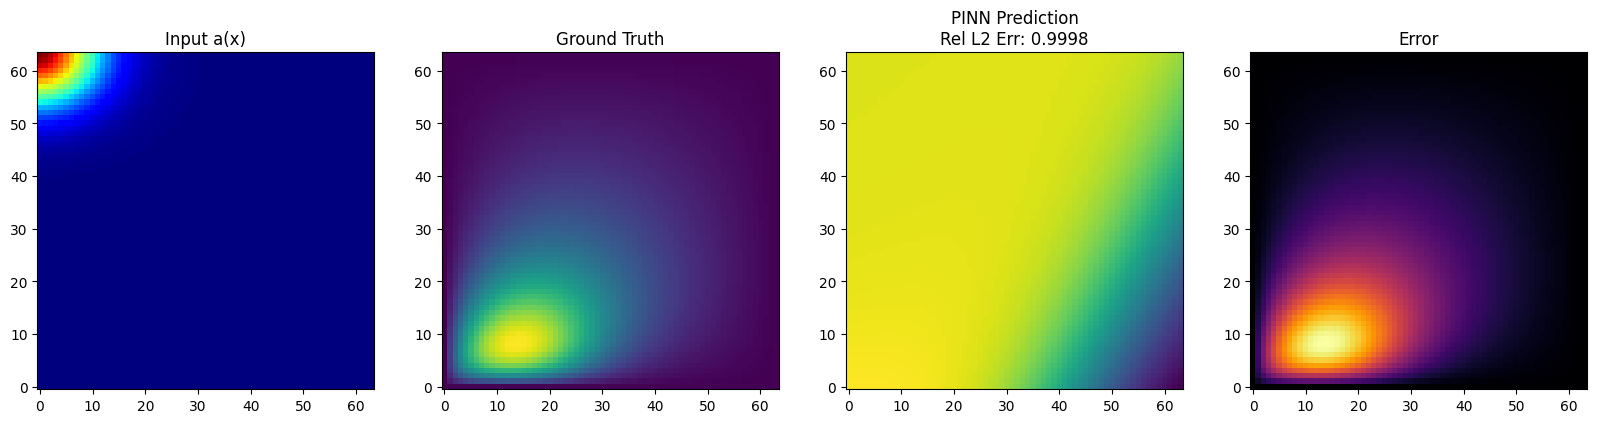

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# 1. 데이터 준비 (a, a_x, a_y 미리 계산)
# ----------------------------------------------------------------
def get_target_instance_with_grads(N=64):
    torch.manual_seed(42)
    
    # 1. Permeability a(x) 생성
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/3.0)
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    a_np = np.exp(4.0 * a_smooth) 
    
    # 2. Solver로 정답 u(x) 계산 (비교용)
    h = 1.0 / (N - 1)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)

    # [핵심 수정] 3. a의 기울기(Gradient) 미리 계산
    # np.gradient는 (axis=0(y), axis=1(x)) 순서로 반환함
    # 물리적 좌표 간격 h로 나누어주어야 실제 기울기가 됨
    grad_a = np.gradient(a_np, h) 
    ay_np = grad_a[0] # y방향 미분
    ax_np = grad_a[1] # x방향 미분
    
    return (torch.tensor(a_np, dtype=torch.float32), 
            torch.tensor(ax_np, dtype=torch.float32), 
            torch.tensor(ay_np, dtype=torch.float32), 
            torch.tensor(u_np, dtype=torch.float32))

# ----------------------------------------------------------------
# 2. PINN Model
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

# ----------------------------------------------------------------
# 3. Physics Loss (수정됨: Pre-computed Gradient 사용)
# ----------------------------------------------------------------
def compute_pde_loss(model, x, y, a_field, ax_field, ay_field):
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    # 1. Prediction
    u = model(x, y)
    
    # 2. First derivatives of u
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    # 3. Second derivatives of u
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 4. Interpolate a, ax, ay at (x,y)
    # Grid Sample 준비
    grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
    
    # a 값 샘플링
    a_val = torch.nn.functional.grid_sample(a_field.view(1, 1, 64, 64), grid, align_corners=True, mode='bilinear').view(-1, 1)
    # ax 값 샘플링 (미분 아님, 그냥 값 읽기)
    ax_val = torch.nn.functional.grid_sample(ax_field.view(1, 1, 64, 64), grid, align_corners=True, mode='bilinear').view(-1, 1)
    # ay 값 샘플링
    ay_val = torch.nn.functional.grid_sample(ay_field.view(1, 1, 64, 64), grid, align_corners=True, mode='bilinear').view(-1, 1)
    
    # 5. PDE Calculation
    # 식: div(a * grad u) = a*div(grad u) + grad a * grad u
    #                   = a*(u_xx + u_yy) + (ax*u_x + ay*u_y)
    # 목표: -div(...) = 1  => div(...) + 1 = 0
    
    divergence = a_val * (u_xx + u_yy) + (ax_val * u_x + ay_val * u_y)
    residual = -divergence - 1.0
    
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
# 데이터 준비
a_np, ax_np, ay_np, u_gt = get_target_instance_with_grads()
a_field = a_np.to(device)
ax_field = ax_np.to(device)
ay_field = ay_np.to(device)
u_gt = u_gt.to(device)

model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Collocation Points
N_col = 5000
x_col = torch.rand(N_col, 1).to(device)
y_col = torch.rand(N_col, 1).to(device)

# Boundary Points
N_b = 1000
x_b = torch.cat([torch.rand(N_b,1), torch.rand(N_b,1), torch.zeros(N_b,1), torch.ones(N_b,1)]).to(device)
y_b = torch.cat([torch.zeros(N_b,1), torch.ones(N_b,1), torch.rand(N_b,1), torch.rand(N_b,1)]).to(device)
u_b_target = torch.zeros_like(x_b)

print("🚀 PINN Training Start...")
loss_history = []
EPOCHS = 20000 

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    # Loss 계산 시 미리 계산된 ax, ay 필드도 함께 전달
    loss_phy = compute_pde_loss(model, x_col, y_col, a_field, ax_field, ay_field)
    
    u_b_pred = model(x_b, y_b)
    loss_bc = torch.mean((u_b_pred - u_b_target)**2)
    
    loss = loss_phy + 100.0 * loss_bc
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}: Loss {loss.item():.6f} (Phy: {loss_phy.item():.6f}, BC: {loss_bc.item():.6f})")

# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
x_grid = np.linspace(0, 1, 64)
y_grid = np.linspace(0, 1, 64)
X, Y = np.meshgrid(x_grid, y_grid)
x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_in, y_in).view(64, 64).cpu().numpy()

u_gt_plot = u_gt.cpu().numpy()
l2_err = np.linalg.norm(u_gt_plot - u_pred) / np.linalg.norm(u_gt_plot)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(a_np, origin='lower', cmap='jet'); axes[0].set_title("Input a(x)")
axes[1].imshow(u_gt_plot, origin='lower', cmap='viridis'); axes[1].set_title("Ground Truth")
axes[2].imshow(u_pred, origin='lower', cmap='viridis'); axes[2].set_title(f"PINN Prediction\nRel L2 Err: {l2_err:.4f}")
axes[3].imshow(np.abs(u_gt_plot - u_pred), origin='lower', cmap='inferno'); axes[3].set_title("Error")
plt.show()

Using device: cuda
🚀 Safe PINN Training Start...
Epoch 1000: Total 349.989624 (Phy: 349.989380, BC: 0.000000)
Epoch 2000: Total 4.154383 (Phy: 4.146254, BC: 0.000008)
Epoch 3000: Total 1.243402 (Phy: 1.242105, BC: 0.000001)
Epoch 4000: Total 1.076576 (Phy: 1.076042, BC: 0.000001)
Epoch 5000: Total 3.982529 (Phy: 3.825087, BC: 0.000157)
Epoch 6000: Total 0.942571 (Phy: 0.940779, BC: 0.000002)
Epoch 7000: Total 0.942445 (Phy: 0.926398, BC: 0.000016)
Epoch 8000: Total 0.930744 (Phy: 0.929407, BC: 0.000001)
Epoch 9000: Total 0.925861 (Phy: 0.925802, BC: 0.000000)
Epoch 10000: Total 0.903959 (Phy: 0.902353, BC: 0.000002)
Epoch 11000: Total 0.905105 (Phy: 0.905068, BC: 0.000000)
Epoch 12000: Total 0.925175 (Phy: 0.908019, BC: 0.000017)
Epoch 13000: Total 0.914321 (Phy: 0.908014, BC: 0.000006)
Epoch 14000: Total 0.904330 (Phy: 0.902030, BC: 0.000002)
Epoch 15000: Total 0.910355 (Phy: 0.910292, BC: 0.000000)
Epoch 16000: Total 0.909415 (Phy: 0.907828, BC: 0.000002)
Epoch 17000: Total 0.903905 

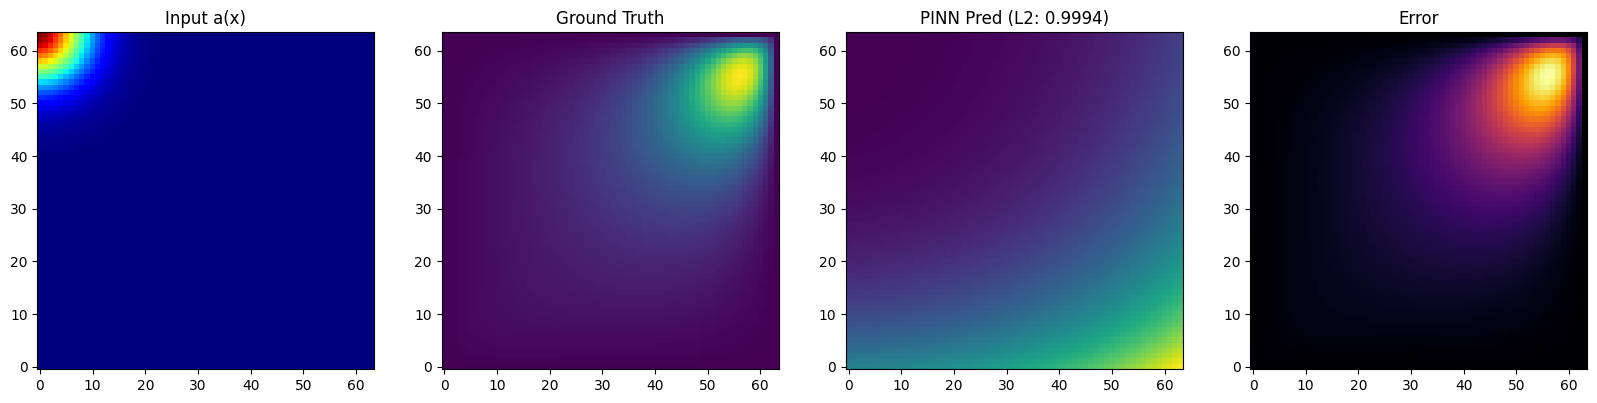

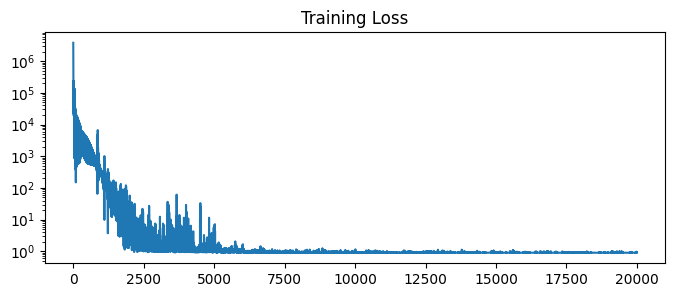

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# 1. 데이터 준비 (a, ax, ay 미리 계산)
# ----------------------------------------------------------------
def get_target_instance_safe(N=64):
    torch.manual_seed(42)
    
    # 1. Permeability a(x) 생성 (High Contrast: e^-4 ~ e^4)
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/3.0)
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    a_np = np.exp(4.0 * a_smooth) 
    
    # 2. Solver로 정답 u(x) 계산
    h = 1.0 / (N - 1)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)

    # 3. Gradient 계산
    grad_a = np.gradient(a_np, h) 
    ay_np = grad_a[0]
    ax_np = grad_a[1]
    
    return (torch.tensor(a_np, dtype=torch.float32), 
            torch.tensor(ax_np, dtype=torch.float32), 
            torch.tensor(ay_np, dtype=torch.float32), 
            torch.tensor(u_np, dtype=torch.float32))

# ----------------------------------------------------------------
# 2. PINN Model (기본 MLP)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

# ----------------------------------------------------------------
# 3. Safe Physics Loss (계수 분리)
# ----------------------------------------------------------------
def compute_loss_safe(model, x, y, a_field, ax_field, ay_field):
    # (1) 계수값 미리 추출 (Gradient Flow 차단 -> 에러 방지)
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        a_val = torch.nn.functional.grid_sample(a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ax_val = torch.nn.functional.grid_sample(ax_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ay_val = torch.nn.functional.grid_sample(ay_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
    
    # (2) 미분 추적 시작
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    u = model(x, y)
    
    # 1차 미분
    grads = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_x = grads
    grads = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_y = grads
    
    # 2차 미분
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # (3) PDE: -div(a grad u) = 1
    # - (a * laplacian_u + grad_a * grad_u) = 1
    # => a*(u_xx + u_yy) + ax*u_x + ay*u_y + 1 = 0
    
    residual = a_val * (u_xx + u_yy) + (ax_val * u_x + ay_val * u_y) + 1.0
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training
# ----------------------------------------------------------------
a_np, ax_np, ay_np, u_gt = get_target_instance_safe()
a_field = a_np.to(device)
ax_field = ax_np.to(device)
ay_field = ay_np.to(device)
u_gt = u_gt.to(device)

model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005) # LR을 조금 낮춤 (안정성)

# 학습용 좌표
N_col = 5000
x_col = torch.rand(N_col, 1).to(device)
y_col = torch.rand(N_col, 1).to(device)

# 경계용 좌표
N_b = 1000
x_b = torch.cat([torch.rand(N_b,1), torch.rand(N_b,1), torch.zeros(N_b,1), torch.ones(N_b,1)]).to(device)
y_b = torch.cat([torch.zeros(N_b,1), torch.ones(N_b,1), torch.rand(N_b,1), torch.rand(N_b,1)]).to(device)
u_b_target = torch.zeros_like(x_b)

print("🚀 Safe PINN Training Start...")
loss_history = []
EPOCHS = 20000 

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    # 1. Physics Loss
    loss_phy = compute_loss_safe(model, x_col, y_col, a_field, ax_field, ay_field)
    
    # 2. Boundary Loss
    u_b_pred = model(x_b, y_b)
    loss_bc = torch.mean((u_b_pred - u_b_target)**2)
    
    # Total Loss (물리 계수가 크므로 BC 가중치를 높게 설정)
    loss = loss_phy + 1000.0 * loss_bc
    
    loss.backward()
    
    # [안전장치] Gradient Clipping (기울기 폭발 방지)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 1000 == 0:
        print(f"Epoch {epoch+1}: Total {loss.item():.6f} (Phy: {loss_phy.item():.6f}, BC: {loss_bc.item():.6f})")

# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
x_grid = np.linspace(0, 1, 64)
y_grid = np.linspace(0, 1, 64)
X, Y = np.meshgrid(x_grid, y_grid)
x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_in, y_in).view(64, 64).cpu().numpy()

u_gt_plot = u_gt.cpu().numpy()
l2_err = np.linalg.norm(u_gt_plot - u_pred) / np.linalg.norm(u_gt_plot)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(a_np, origin='lower', cmap='jet'); axes[0].set_title("Input a(x)")
axes[1].imshow(u_gt_plot, origin='lower', cmap='viridis'); axes[1].set_title("Ground Truth")
axes[2].imshow(u_pred, origin='lower', cmap='viridis'); axes[2].set_title(f"PINN Pred (L2: {l2_err:.4f})")
axes[3].imshow(np.abs(u_gt_plot - u_pred), origin='lower', cmap='inferno'); axes[3].set_title("Error")
plt.show()

# Loss Graph
plt.figure(figsize=(8,3))
plt.plot(loss_history)
plt.yscale('log')
plt.title("Training Loss")
plt.show()

Using device: cuda
Generating High-Contrast Permeability Field...

🚀 Start Training PINN for 15000 epochs...
Epoch 1000/15000 | Loss: 0.897973 (PDE: 0.897924, BC: 0.000000) | Time: 12.8s
Epoch 2000/15000 | Loss: 1.505626 (PDE: 1.505545, BC: 0.000001) | Time: 24.8s
Epoch 3000/15000 | Loss: 0.876663 (PDE: 0.876635, BC: 0.000000) | Time: 37.1s
Epoch 4000/15000 | Loss: 0.868813 (PDE: 0.868795, BC: 0.000000) | Time: 49.0s
Epoch 5000/15000 | Loss: 4.003052 (PDE: 4.002646, BC: 0.000004) | Time: 60.6s
Epoch 6000/15000 | Loss: 0.853737 (PDE: 0.853712, BC: 0.000000) | Time: 73.9s
Epoch 7000/15000 | Loss: 8.095782 (PDE: 8.094970, BC: 0.000008) | Time: 86.4s
Epoch 8000/15000 | Loss: 1.206133 (PDE: 1.206028, BC: 0.000001) | Time: 98.7s
Epoch 9000/15000 | Loss: 1.064006 (PDE: 1.063899, BC: 0.000001) | Time: 111.4s
Epoch 10000/15000 | Loss: 1.132664 (PDE: 1.132563, BC: 0.000001) | Time: 124.8s
Epoch 11000/15000 | Loss: 0.819378 (PDE: 0.819296, BC: 0.000001) | Time: 137.4s
Epoch 12000/15000 | Loss: 1.

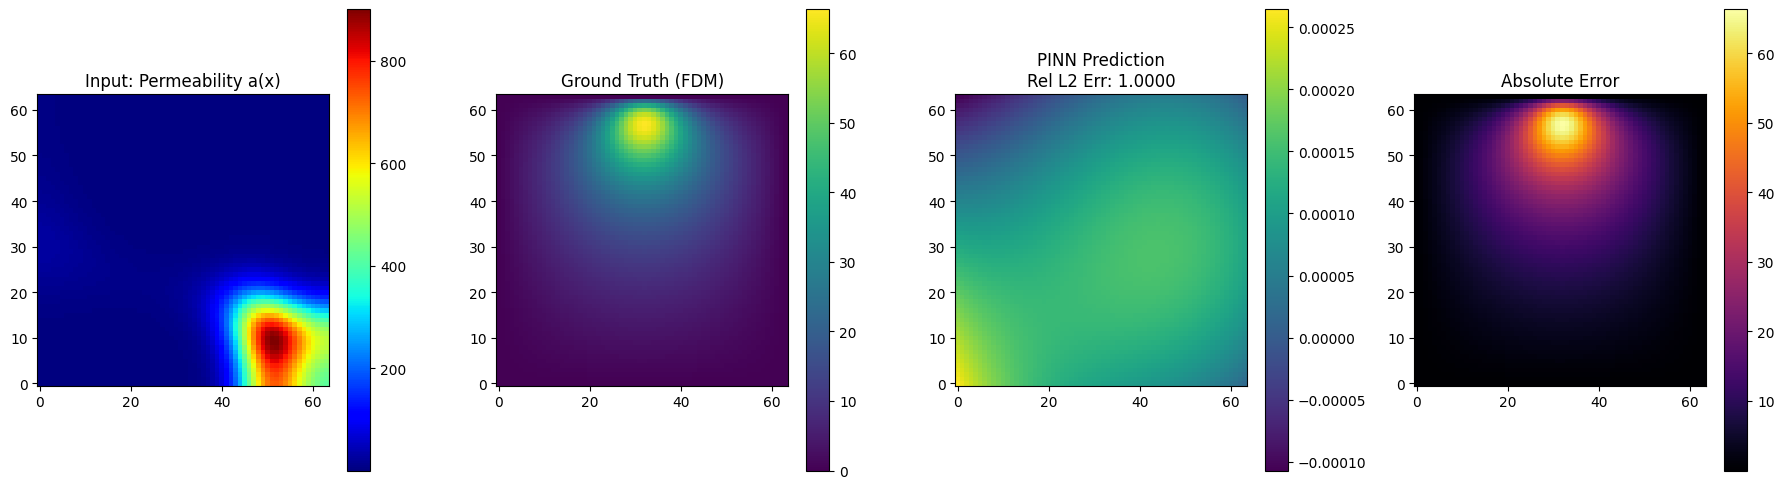

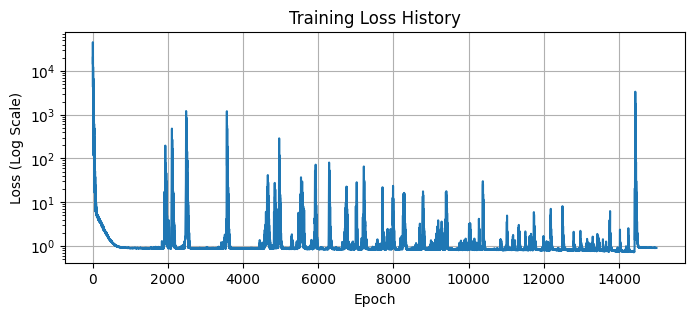

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. Global Settings
# ----------------------------------------------------------------
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 시드 고정 (재현성)
torch.manual_seed(42)
np.random.seed(42)

# ----------------------------------------------------------------
# 1. Data Generation (Classical Solver for Ground Truth)
# ----------------------------------------------------------------
def generate_darcy_instance(N=64):
    """
    고대비(High Contrast) 투과율 a(x)를 생성하고
    FDM Solver로 정답 u(x)를 계산하여 반환합니다.
    또한 PINN 학습 안정성을 위해 a의 기울기(ax, ay)를 미리 계산합니다.
    """
    print("Generating High-Contrast Permeability Field...")
    
    # 1. Permeability a(x) 생성 (Random Gaussian Field)
    xi = np.random.randn(N, N)
    # 스무딩을 통해 덩어리 패턴 생성
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0)
    # 정규화
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    # 지수 함수를 적용하여 값의 격차(Contrast)를 키움 (e^-4 ~ e^4)
    a_np = np.exp(4.0 * a_smooth) 
    
    # 2. Classical Solver (FDM)로 정답 u 계산
    # 방정식: -div(a * grad u) = 1
    h = 1.0 / (N - 1)
    num = N * N
    rhs = np.ones(num) * h**2 # f = 1
    
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    # 5-point stencil FDM Matrix 구성
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            # Boundary Condition (u=0)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                # Harmonic Average로 계수 근사 (Standard method)
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)

    # 3. [핵심] PINN 학습용 a의 기울기(Gradient) 미리 계산 (Numerical)
    # PyTorch 내부에서 자동미분하면 2차 미분 지원 문제로 에러가 남.
    # 따라서 numpy gradient로 미리 계산해서 상수처럼 넣어줌.
    grad_a = np.gradient(a_np, h) 
    ay_np = grad_a[0] # y방향 미분 (axis 0)
    ax_np = grad_a[1] # x방향 미분 (axis 1)
    
    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    
    return (to_tensor(a_np), to_tensor(ax_np), to_tensor(ay_np), to_tensor(u_np))

# ----------------------------------------------------------------
# 2. PINN Model Architecture
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # 좌표 (x, y) -> 압력 (u)
        # Tanh는 미분 가능하고 부드러워서 PINN에 적합함
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # 가중치 초기화 (Xavier)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, y):
        # x, y shape: (Batch, 1)
        return self.net(torch.cat([x, y], dim=1))

# ----------------------------------------------------------------
# 3. Loss Functions
# ----------------------------------------------------------------
def interpolate_field(field_tensor, x, y):
    """
    (x, y) 좌표에 해당하는 field 값(a, ax, ay)을 가져옴 (Bilinear Interpolation)
    field_tensor: (N, N)
    x, y: (Batch, 1) range [0, 1]
    """
    H, W = field_tensor.shape
    # grid_sample은 좌표가 [-1, 1]이어야 함. 변환 필요.
    grid_x = x * 2 - 1
    grid_y = y * 2 - 1
    grid = torch.cat([grid_x, grid_y], dim=1).unsqueeze(0).unsqueeze(0) # (1, 1, Batch, 2)
    
    # (N, N) -> (1, 1, N, N)
    img = field_tensor.view(1, 1, H, W)
    
    # align_corners=True: 가장자리를 정확히 맞춤
    val = torch.nn.functional.grid_sample(img, grid, align_corners=True, mode='bilinear')
    return val.view(-1, 1) # (Batch, 1)

def physics_loss(model, x, y, a, ax, ay):
    """
    PDE Residual 계산: -div(a * grad u) = 1
    전개하면: a * (u_xx + u_yy) + ax * u_x + ay * u_y + 1 = 0
    """
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    # 1. Neural Net Prediction
    u = model(x, y)
    
    # 2. Automatic Differentiation for u
    # 1차 미분
    grads = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_x = grads
    grads = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_y = grads
    
    # 2차 미분
    grads = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_xx = grads
    grads = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    u_yy = grads
    
    # 3. Interpolate Coefficients (a, ax, ay)
    # 이 부분은 미분 그래프를 끊어서(detach) 상수 취급 -> 에러 방지 & 안정성
    with torch.no_grad():
        a_val = interpolate_field(a, x, y)
        ax_val = interpolate_field(ax, x, y)
        ay_val = interpolate_field(ay, x, y)
        
    # 4. Residual Calculation
    # 식: a * Laplacian(u) + Grad(a) * Grad(u) + 1 = 0
    # 좌변이 0이 되어야 함.
    residual = a_val * (u_xx + u_yy) + (ax_val * u_x + ay_val * u_y) + 1.0
    
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
def train():
    # 1. 데이터 준비
    N_grid = 64
    a_field, ax_field, ay_field, u_gt = generate_darcy_instance(N=N_grid)
    
    # 2. 모델 및 옵티마이저
    model = PINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 학습 파라미터
    EPOCHS = 15000
    N_collocation = 5000  # 내부 물리 법칙 학습용 점 개수
    N_boundary = 1000     # 경계 조건 학습용 점 개수
    
    loss_history = []
    
    print(f"\n🚀 Start Training PINN for {EPOCHS} epochs...")
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        
        # --- A. Collocation Points (Physics Loss) ---
        # 매 에폭마다 랜덤 샘플링 (Stochastic) -> 일반화 성능 향상
        x_col = torch.rand(N_collocation, 1).to(device)
        y_col = torch.rand(N_collocation, 1).to(device)
        
        loss_pde = physics_loss(model, x_col, y_col, a_field, ax_field, ay_field)
        
        # --- B. Boundary Points (BC Loss) ---
        # 경계: x=0, x=1, y=0, y=1 인 점들
        # [x, 0], [x, 1], [0, y], [1, y] 생성
        rb = torch.rand(N_boundary // 4, 1).to(device)
        ones = torch.ones_like(rb)
        zeros = torch.zeros_like(rb)
        
        x_b = torch.cat([rb, rb, zeros, ones], dim=0)
        y_b = torch.cat([zeros, ones, rb, rb], dim=0)
        
        # 경계값은 무조건 0이어야 함 (Dirichlet BC)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        # --- C. Total Loss ---
        # BC Loss에 가중치(100.0)를 주어 경계 조건을 강하게 학습시킴
        loss = loss_pde + 100.0 * loss_bc
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss.item():.6f} (PDE: {loss_pde.item():.6f}, BC: {loss_bc.item():.6f}) | Time: {elapsed:.1f}s")

    print("✅ Training Complete.")
    return model, loss_history, a_field, u_gt

# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
def visualize_result(model, loss_history, a_field, u_gt):
    model.eval()
    N = u_gt.shape[0]
    
    # Grid 생성
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    # 예측
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
        
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    # 에러 계산
    abs_err = np.abs(u_gt_np - u_pred)
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    # Plotting
    plt.figure(figsize=(18, 5))
    
    # 1. Input Permeability
    plt.subplot(1, 4, 1)
    plt.title("Input: Permeability a(x)")
    plt.imshow(a_np, origin='lower', cmap='jet')
    plt.colorbar()
    
    # 2. Ground Truth
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth (FDM)")
    plt.imshow(u_gt_np, origin='lower', cmap='viridis')
    plt.colorbar()
    
    # 3. PINN Prediction
    plt.subplot(1, 4, 3)
    plt.title(f"PINN Prediction\nRel L2 Err: {rel_l2:.4f}")
    plt.imshow(u_pred, origin='lower', cmap='viridis')
    plt.colorbar()
    
    # 4. Absolute Error
    plt.subplot(1, 4, 4)
    plt.title("Absolute Error")
    plt.imshow(abs_err, origin='lower', cmap='inferno')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Loss Curve
    plt.figure(figsize=(8, 3))
    plt.plot(loss_history)
    plt.yscale('log')
    plt.title("Training Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.grid(True)
    plt.show()

# ----------------------------------------------------------------
# Main Execution
# ----------------------------------------------------------------
if __name__ == "__main__":
    trained_model, loss_hist, a_map, u_map = train()
    visualize_result(trained_model, loss_hist, a_map, u_map)

Using device: cuda
generating high-contrast darcy data...
🚀 Start Training (Log-PDE Formulation)...
Epoch 1000: Loss 33205.656250 (PDE: 3691.731201, BC: 295.139252)
Epoch 2000: Loss 24735.140625 (PDE: 4807.885742, BC: 199.272552)
Epoch 3000: Loss 20342.988281 (PDE: 5033.274902, BC: 153.097137)
Epoch 4000: Loss 16030.091797 (PDE: 2761.503418, BC: 132.685883)
Epoch 5000: Loss 14353.431641 (PDE: 3464.081543, BC: 108.893509)
Epoch 6000: Loss 12239.225586 (PDE: 3200.368408, BC: 90.388573)
Epoch 7000: Loss 10281.118164 (PDE: 2636.694092, BC: 76.444244)
Epoch 8000: Loss 8480.342773 (PDE: 2567.755615, BC: 59.125870)
Epoch 9000: Loss 7521.322266 (PDE: 2740.303223, BC: 47.810192)
Epoch 10000: Loss 4155.180664 (PDE: 963.630615, BC: 31.915497)
Epoch 11000: Loss 3625.049805 (PDE: 1586.907959, BC: 20.381418)
Epoch 12000: Loss 2043.802490 (PDE: 828.329468, BC: 12.154730)
Epoch 13000: Loss 1134.361816 (PDE: 364.551300, BC: 7.698105)
Epoch 14000: Loss 781.048950 (PDE: 278.666199, BC: 5.023827)
Epoch 15

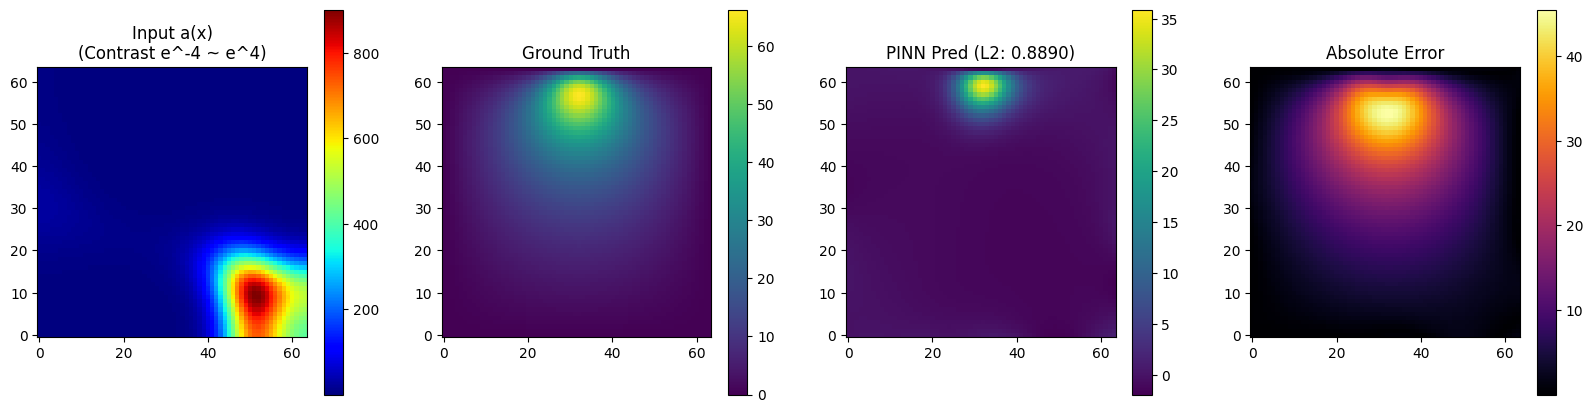

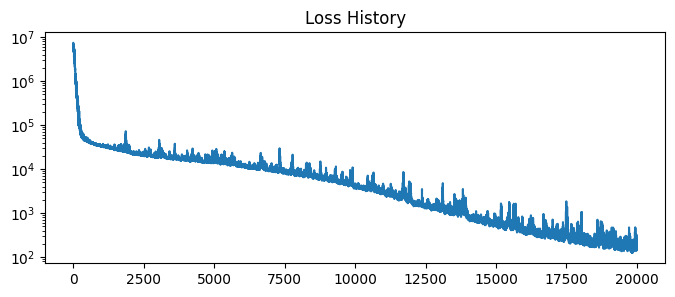

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정 및 Fourier Feature Layer
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# [Upgrade 1] Fourier Feature Embedding (고주파 성분 학습용)
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        # 랜덤한 주파수 B 행렬 생성 (고정)
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 1. 시뮬레이션 및 데이터 준비 (Log-PDE용 전처리)
# ----------------------------------------------------------------
def generate_darcy_data(N=64):
    print("generating high-contrast darcy data...")
    # [사용자 시뮬레이션 코드 로직 적용]
    h = 1.0 / (N - 1)
    
    # 1. Permeability a(x)
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0) # 패턴 크기 조절
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    # Contrast가 매우 큼 (e^-4 ~ e^4)
    beta = 4.0
    k_np = beta * a_smooth       # k = ln(a)
    a_np = np.exp(k_np)          # a = e^k
    
    # 2. Solver (Ground Truth 생성)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)
    
    # 3. [Upgrade 2] Log-Transformed Gradients 미리 계산
    # a 대신 ln(a)의 미분값을 사용하면 학습이 훨씬 안정적임
    # np.gradient returns [grad_axis_0(y), grad_axis_1(x)]
    grad_k = np.gradient(k_np, h)
    ky_np = grad_k[0] # dk/dy
    kx_np = grad_k[1] # dk/dx
    
    # PDE 우변 (1/a) 미리 계산
    inv_a_np = 1.0 / a_np

    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    return (to_tensor(kx_np), to_tensor(ky_np), to_tensor(inv_a_np), 
            to_tensor(u_np), to_tensor(a_np))

# ----------------------------------------------------------------
# 2. PINN Model (Fourier Features 적용)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Fourier Embedding -> MLP
        self.embedding = FourierEmbedding(in_features=2, out_features=64, scale=1.0)
        
        self.net = nn.Sequential(
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # 가중치 초기화
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        embedded = self.embedding(inputs)
        return self.net(embedded)

# ----------------------------------------------------------------
# 3. Log-PDE Loss Function
# ----------------------------------------------------------------
def compute_log_pde_loss(model, x, y, kx_field, ky_field, inv_a_field):
    """
    Log-Transformed Darcy Equation:
    Original: -div(a grad u) = 1
    Transformed: - (laplacian u + grad(ln a) . grad u) = 1/a
    Target: laplacian u + kx*u_x + ky*u_y + 1/a = 0
    """
    # 1. Grid Sampling (Interpolation)
    # 좌표 정규화 [0,1] -> [-1,1]
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        # 미분값들을 좌표에 맞춰 가져오기
        kx_val = torch.nn.functional.grid_sample(kx_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ky_val = torch.nn.functional.grid_sample(ky_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        inv_a_val = torch.nn.functional.grid_sample(inv_a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)

    # 2. Automatic Differentiation
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    u = model(x, y)
    
    # 1차 미분
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    # 2차 미분 (Laplacian)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 3. Residual Calculation (Log Formulation)
    # laplacian u + grad k . grad u + 1/a = 0
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
def train():
    # 데이터 준비
    kx_field, ky_field, inv_a_field, u_gt, a_field = generate_darcy_data()
    
    model = PINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # 학습률 스케줄러 (수렴 속도 향상)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.8)
    
    EPOCHS = 20000
    N_col = 4096 # 내부 점 개수
    N_b = 1024   # 경계 점 개수
    
    loss_history = []
    
    print(f"🚀 Start Training (Log-PDE Formulation)...")
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        
        # A. Physics Loss (Random Sampling)
        x_col = torch.rand(N_col, 1).to(device)
        y_col = torch.rand(N_col, 1).to(device)
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        
        # B. Boundary Loss (u=0 at boundary)
        # Random boundary points: [x,0], [x,1], [0,y], [1,y]
        rb = torch.rand(N_b // 4, 1).to(device)
        ones = torch.ones_like(rb)
        zeros = torch.zeros_like(rb)
        x_b = torch.cat([rb, rb, zeros, ones], dim=0)
        y_b = torch.cat([zeros, ones, rb, rb], dim=0)
        
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        # Total Loss
        loss = loss_pde + 100.0 * loss_bc
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}: Loss {loss.item():.6f} (PDE: {loss_pde.item():.6f}, BC: {loss_bc.item():.6f})")

    print(f"Training Done. Time: {time.time()-start_time:.1f}s")
    return model, loss_history, u_gt, a_field

# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y) # (rows:y, cols:x)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
        
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    im0 = axes[0].imshow(a_np, origin='lower', cmap='jet')
    axes[0].set_title("Input a(x)\n(Contrast e^-4 ~ e^4)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(u_gt_np, origin='lower', cmap='viridis')
    axes[1].set_title("Ground Truth")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(u_pred, origin='lower', cmap='viridis')
    axes[2].set_title(f"PINN Pred (L2: {rel_l2:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno')
    axes[3].set_title("Absolute Error")
    plt.colorbar(im3, ax=axes[3])
    
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Loss History")
    plt.show()

if __name__ == "__main__":
    trained_model, loss_hist, u_gt, a_field = train()
    visualize(trained_model, loss_hist, u_gt, a_field)

In [ ]:
# increase 2x model param size 

Using device: cuda
generating high-contrast darcy data...
🚀 Start Training (Log-PDE Formulation)...
Epoch 1000: Loss 2756688.500000 (PDE: 2756663.750000, BC: 0.248261)
Epoch 2000: Loss 393643.781250 (PDE: 390187.718750, BC: 34.560562)
Epoch 3000: Loss 192150.140625 (PDE: 188654.375000, BC: 34.957588)
Epoch 4000: Loss 42494.246094 (PDE: 39375.167969, BC: 31.190784)
Epoch 5000: Loss 87042.312500 (PDE: 84538.445312, BC: 25.038662)
Epoch 6000: Loss 150116.234375 (PDE: 148510.062500, BC: 16.061710)
Epoch 7000: Loss 125584.296875 (PDE: 124520.789062, BC: 10.635061)
Epoch 8000: Loss 235855.156250 (PDE: 235002.031250, BC: 8.531277)
Epoch 9000: Loss 29797.316406 (PDE: 29295.556641, BC: 5.017604)
Epoch 10000: Loss 20107.802734 (PDE: 19730.976562, BC: 3.768258)
Epoch 11000: Loss 8165.561035 (PDE: 7893.137695, BC: 2.724232)
Epoch 12000: Loss 15951.723633 (PDE: 15768.753906, BC: 1.829701)
Epoch 13000: Loss 6441.254883 (PDE: 6305.696777, BC: 1.355582)
Epoch 14000: Loss 3671.088135 (PDE: 3538.118652,

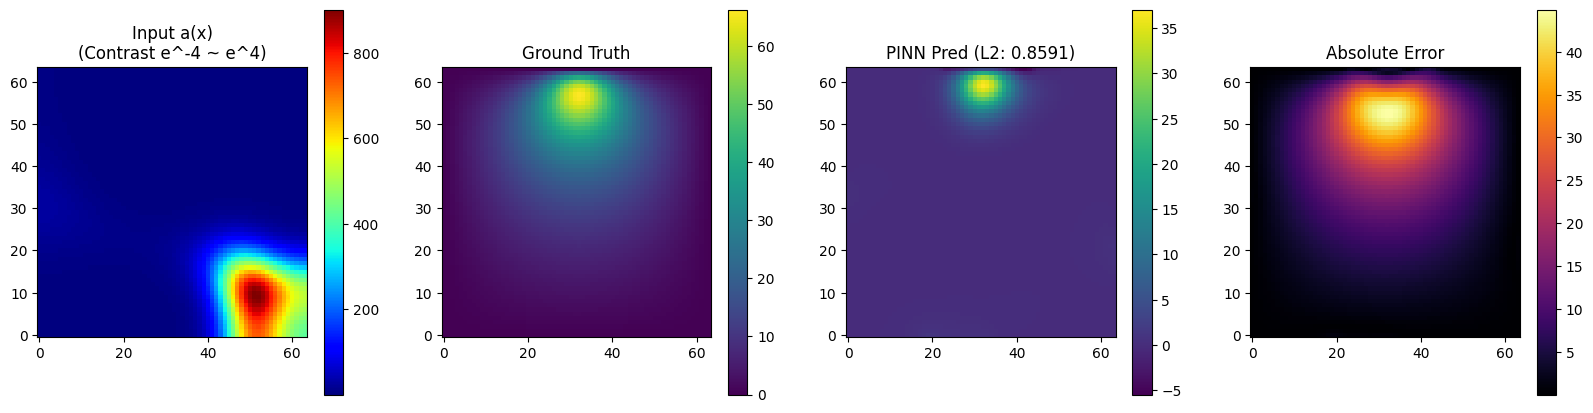

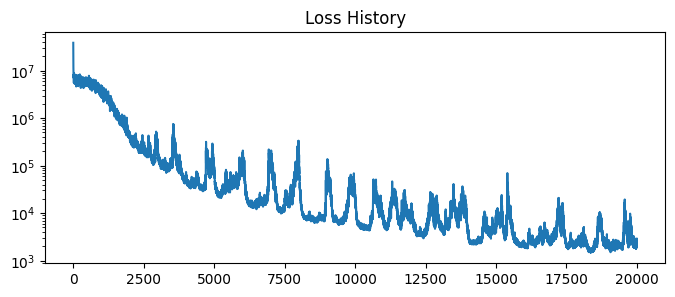

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정 및 Fourier Feature Layer
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# [Upgrade 1] Fourier Feature Embedding (고주파 성분 학습용)
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        # 랜덤한 주파수 B 행렬 생성 (고정)
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 1. 시뮬레이션 및 데이터 준비 (Log-PDE용 전처리)
# ----------------------------------------------------------------
def generate_darcy_data(N=64):
    print("generating high-contrast darcy data...")
    # [사용자 시뮬레이션 코드 로직 적용]
    h = 1.0 / (N - 1)
    
    # 1. Permeability a(x)
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0) # 패턴 크기 조절
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    # Contrast가 매우 큼 (e^-4 ~ e^4)
    beta = 4.0
    k_np = beta * a_smooth       # k = ln(a)
    a_np = np.exp(k_np)          # a = e^k
    
    # 2. Solver (Ground Truth 생성)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)
    
    # 3. [Upgrade 2] Log-Transformed Gradients 미리 계산
    # a 대신 ln(a)의 미분값을 사용하면 학습이 훨씬 안정적임
    # np.gradient returns [grad_axis_0(y), grad_axis_1(x)]
    grad_k = np.gradient(k_np, h)
    ky_np = grad_k[0] # dk/dy
    kx_np = grad_k[1] # dk/dx
    
    # PDE 우변 (1/a) 미리 계산
    inv_a_np = 1.0 / a_np

    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    return (to_tensor(kx_np), to_tensor(ky_np), to_tensor(inv_a_np), 
            to_tensor(u_np), to_tensor(a_np))

# ----------------------------------------------------------------
# 2. PINN Model (Fourier Features 적용)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # [업그레이드 1] Fourier Feature 차원 확장 (64 -> 128)
        # scale=10.0 정도로 키우면 고주파(세밀한 변화)를 더 잘 잡습니다.
        self.embedding = FourierEmbedding(in_features=2, out_features=128, scale=10.0)
        
        # [업그레이드 2] 더 넓고 깊은 MLP (64 -> 128, 3층 -> 5층)
        self.net = nn.Sequential(
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # 가중치 초기화 (필수)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        embedded = self.embedding(inputs)
        return self.net(embedded)
# ----------------------------------------------------------------
# 3. Log-PDE Loss Function
# ----------------------------------------------------------------
def compute_log_pde_loss(model, x, y, kx_field, ky_field, inv_a_field):
    """
    Log-Transformed Darcy Equation:
    Original: -div(a grad u) = 1
    Transformed: - (laplacian u + grad(ln a) . grad u) = 1/a
    Target: laplacian u + kx*u_x + ky*u_y + 1/a = 0
    """
    # 1. Grid Sampling (Interpolation)
    # 좌표 정규화 [0,1] -> [-1,1]
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        # 미분값들을 좌표에 맞춰 가져오기
        kx_val = torch.nn.functional.grid_sample(kx_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ky_val = torch.nn.functional.grid_sample(ky_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        inv_a_val = torch.nn.functional.grid_sample(inv_a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)

    # 2. Automatic Differentiation
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    u = model(x, y)
    
    # 1차 미분
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    # 2차 미분 (Laplacian)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 3. Residual Calculation (Log Formulation)
    # laplacian u + grad k . grad u + 1/a = 0
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
def train():
    # 데이터 준비
    kx_field, ky_field, inv_a_field, u_gt, a_field = generate_darcy_data()
    
    model = PINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # 학습률 스케줄러 (수렴 속도 향상)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.8)
    
    EPOCHS = 20000
    N_col = 4096 # 내부 점 개수
    N_b = 1024   # 경계 점 개수
    
    loss_history = []
    
    print(f"🚀 Start Training (Log-PDE Formulation)...")
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        
        # A. Physics Loss (Random Sampling)
        x_col = torch.rand(N_col, 1).to(device)
        y_col = torch.rand(N_col, 1).to(device)
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        
        # B. Boundary Loss (u=0 at boundary)
        # Random boundary points: [x,0], [x,1], [0,y], [1,y]
        rb = torch.rand(N_b // 4, 1).to(device)
        ones = torch.ones_like(rb)
        zeros = torch.zeros_like(rb)
        x_b = torch.cat([rb, rb, zeros, ones], dim=0)
        y_b = torch.cat([zeros, ones, rb, rb], dim=0)
        
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        # Total Loss
        loss = loss_pde + 100.0 * loss_bc
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}: Loss {loss.item():.6f} (PDE: {loss_pde.item():.6f}, BC: {loss_bc.item():.6f})")

    print(f"Training Done. Time: {time.time()-start_time:.1f}s")
    return model, loss_history, u_gt, a_field

# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y) # (rows:y, cols:x)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
        
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    im0 = axes[0].imshow(a_np, origin='lower', cmap='jet')
    axes[0].set_title("Input a(x)\n(Contrast e^-4 ~ e^4)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(u_gt_np, origin='lower', cmap='viridis')
    axes[1].set_title("Ground Truth")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(u_pred, origin='lower', cmap='viridis')
    axes[2].set_title(f"PINN Pred (L2: {rel_l2:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno')
    axes[3].set_title("Absolute Error")
    plt.colorbar(im3, ax=axes[3])
    
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Loss History")
    plt.show()

if __name__ == "__main__":
    trained_model, loss_hist, u_gt, a_field = train()
    visualize(trained_model, loss_hist, u_gt, a_field)

In [ ]:
# increase 2x iteration

Using device: cuda
generating high-contrast darcy data...
🚀 Start Training (Log-PDE Formulation)...
Epoch 1000: Loss 2756688.500000 (PDE: 2756663.750000, BC: 0.248261)
Epoch 2000: Loss 393643.781250 (PDE: 390187.718750, BC: 34.560562)
Epoch 3000: Loss 192150.140625 (PDE: 188654.375000, BC: 34.957588)
Epoch 4000: Loss 42494.246094 (PDE: 39375.167969, BC: 31.190784)
Epoch 5000: Loss 87042.312500 (PDE: 84538.445312, BC: 25.038662)
Epoch 6000: Loss 150116.234375 (PDE: 148510.062500, BC: 16.061710)
Epoch 7000: Loss 125584.296875 (PDE: 124520.789062, BC: 10.635061)
Epoch 8000: Loss 235855.156250 (PDE: 235002.031250, BC: 8.531277)
Epoch 9000: Loss 29797.316406 (PDE: 29295.556641, BC: 5.017604)
Epoch 10000: Loss 20107.802734 (PDE: 19730.976562, BC: 3.768258)
Epoch 11000: Loss 8165.561035 (PDE: 7893.137695, BC: 2.724232)
Epoch 12000: Loss 15951.723633 (PDE: 15768.753906, BC: 1.829701)
Epoch 13000: Loss 6441.254883 (PDE: 6305.696777, BC: 1.355582)
Epoch 14000: Loss 3671.088135 (PDE: 3538.118652,

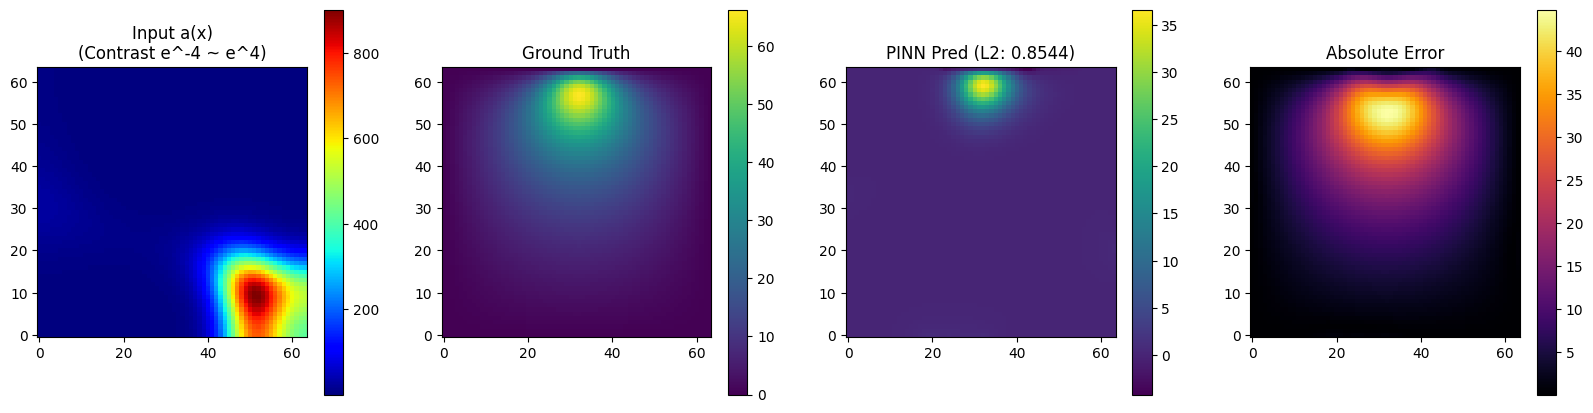

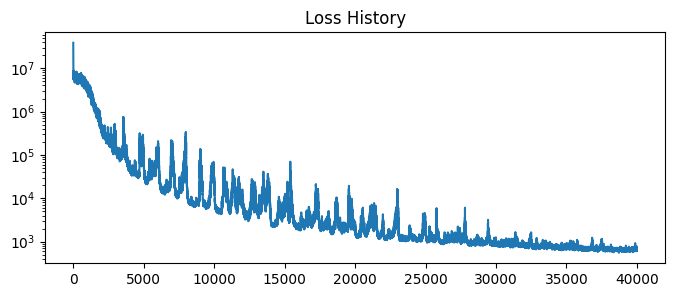

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정 및 Fourier Feature Layer
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# [Upgrade 1] Fourier Feature Embedding (고주파 성분 학습용)
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        # 랜덤한 주파수 B 행렬 생성 (고정)
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 1. 시뮬레이션 및 데이터 준비 (Log-PDE용 전처리)
# ----------------------------------------------------------------
def generate_darcy_data(N=64):
    print("generating high-contrast darcy data...")
    # [사용자 시뮬레이션 코드 로직 적용]
    h = 1.0 / (N - 1)
    
    # 1. Permeability a(x)
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0) # 패턴 크기 조절
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    # Contrast가 매우 큼 (e^-4 ~ e^4)
    beta = 4.0
    k_np = beta * a_smooth       # k = ln(a)
    a_np = np.exp(k_np)          # a = e^k
    
    # 2. Solver (Ground Truth 생성)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)
    
    # 3. [Upgrade 2] Log-Transformed Gradients 미리 계산
    # a 대신 ln(a)의 미분값을 사용하면 학습이 훨씬 안정적임
    # np.gradient returns [grad_axis_0(y), grad_axis_1(x)]
    grad_k = np.gradient(k_np, h)
    ky_np = grad_k[0] # dk/dy
    kx_np = grad_k[1] # dk/dx
    
    # PDE 우변 (1/a) 미리 계산
    inv_a_np = 1.0 / a_np

    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    return (to_tensor(kx_np), to_tensor(ky_np), to_tensor(inv_a_np), 
            to_tensor(u_np), to_tensor(a_np))

# ----------------------------------------------------------------
# 2. PINN Model (Fourier Features 적용)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # [업그레이드 1] Fourier Feature 차원 확장 (64 -> 128)
        # scale=10.0 정도로 키우면 고주파(세밀한 변화)를 더 잘 잡습니다.
        self.embedding = FourierEmbedding(in_features=2, out_features=128, scale=10.0)
        
        # [업그레이드 2] 더 넓고 깊은 MLP (64 -> 128, 3층 -> 5층)
        self.net = nn.Sequential(
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # 가중치 초기화 (필수)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        embedded = self.embedding(inputs)
        return self.net(embedded)
# ----------------------------------------------------------------
# 3. Log-PDE Loss Function
# ----------------------------------------------------------------
def compute_log_pde_loss(model, x, y, kx_field, ky_field, inv_a_field):
    """
    Log-Transformed Darcy Equation:
    Original: -div(a grad u) = 1
    Transformed: - (laplacian u + grad(ln a) . grad u) = 1/a
    Target: laplacian u + kx*u_x + ky*u_y + 1/a = 0
    """
    # 1. Grid Sampling (Interpolation)
    # 좌표 정규화 [0,1] -> [-1,1]
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        # 미분값들을 좌표에 맞춰 가져오기
        kx_val = torch.nn.functional.grid_sample(kx_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ky_val = torch.nn.functional.grid_sample(ky_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        inv_a_val = torch.nn.functional.grid_sample(inv_a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)

    # 2. Automatic Differentiation
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    u = model(x, y)
    
    # 1차 미분
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    # 2차 미분 (Laplacian)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 3. Residual Calculation (Log Formulation)
    # laplacian u + grad k . grad u + 1/a = 0
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
def train():
    # 데이터 준비
    kx_field, ky_field, inv_a_field, u_gt, a_field = generate_darcy_data()
    
    model = PINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # 학습률 스케줄러 (수렴 속도 향상)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.8)
    
    EPOCHS = 40000
    N_col = 4096 # 내부 점 개수
    N_b = 1024   # 경계 점 개수
    
    loss_history = []
    
    print(f"🚀 Start Training (Log-PDE Formulation)...")
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        
        # A. Physics Loss (Random Sampling)
        x_col = torch.rand(N_col, 1).to(device)
        y_col = torch.rand(N_col, 1).to(device)
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        
        # B. Boundary Loss (u=0 at boundary)
        # Random boundary points: [x,0], [x,1], [0,y], [1,y]
        rb = torch.rand(N_b // 4, 1).to(device)
        ones = torch.ones_like(rb)
        zeros = torch.zeros_like(rb)
        x_b = torch.cat([rb, rb, zeros, ones], dim=0)
        y_b = torch.cat([zeros, ones, rb, rb], dim=0)
        
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        # Total Loss
        loss = loss_pde + 100.0 * loss_bc
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}: Loss {loss.item():.6f} (PDE: {loss_pde.item():.6f}, BC: {loss_bc.item():.6f})")

    print(f"Training Done. Time: {time.time()-start_time:.1f}s")
    return model, loss_history, u_gt, a_field

# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y) # (rows:y, cols:x)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
        
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    im0 = axes[0].imshow(a_np, origin='lower', cmap='jet')
    axes[0].set_title("Input a(x)\n(Contrast e^-4 ~ e^4)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(u_gt_np, origin='lower', cmap='viridis')
    axes[1].set_title("Ground Truth")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(u_pred, origin='lower', cmap='viridis')
    axes[2].set_title(f"PINN Pred (L2: {rel_l2:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno')
    axes[3].set_title("Absolute Error")
    plt.colorbar(im3, ax=axes[3])
    
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Loss History")
    plt.show()

if __name__ == "__main__":
    trained_model, loss_hist, u_gt, a_field = train()
    visualize(trained_model, loss_hist, u_gt, a_field)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정 및 Fourier Feature Layer
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# [Upgrade 1] Fourier Feature Embedding (고주파 성분 학습용)
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        # 랜덤한 주파수 B 행렬 생성 (고정)
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 1. 시뮬레이션 및 데이터 준비 (Log-PDE용 전처리)
# ----------------------------------------------------------------
def generate_darcy_data(N=64):
    print("generating high-contrast darcy data...")
    # [사용자 시뮬레이션 코드 로직 적용]
    h = 1.0 / (N - 1)
    
    # 1. Permeability a(x)
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0) # 패턴 크기 조절
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    # Contrast가 매우 큼 (e^-4 ~ e^4)
    beta = 4.0
    k_np = beta * a_smooth       # k = ln(a)
    a_np = np.exp(k_np)          # a = e^k
    
    # 2. Solver (Ground Truth 생성)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)
    
    # 3. [Upgrade 2] Log-Transformed Gradients 미리 계산
    # a 대신 ln(a)의 미분값을 사용하면 학습이 훨씬 안정적임
    # np.gradient returns [grad_axis_0(y), grad_axis_1(x)]
    grad_k = np.gradient(k_np, h)
    ky_np = grad_k[0] # dk/dy
    kx_np = grad_k[1] # dk/dx
    
    # PDE 우변 (1/a) 미리 계산
    inv_a_np = 1.0 / a_np

    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    return (to_tensor(kx_np), to_tensor(ky_np), to_tensor(inv_a_np), 
            to_tensor(u_np), to_tensor(a_np))

# ----------------------------------------------------------------
# 2. PINN Model (Fourier Features 적용)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # [업그레이드 1] Fourier Feature 차원 확장 (64 -> 128)
        # scale=10.0 정도로 키우면 고주파(세밀한 변화)를 더 잘 잡습니다.
        self.embedding = FourierEmbedding(in_features=2, out_features=128, scale=10.0)
        
        # [업그레이드 2] 더 넓고 깊은 MLP (64 -> 128, 3층 -> 5층)
        self.net = nn.Sequential(
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # 가중치 초기화 (필수)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        embedded = self.embedding(inputs)
        return self.net(embedded)
# ----------------------------------------------------------------
# 3. Log-PDE Loss Function
# ----------------------------------------------------------------
def compute_log_pde_loss(model, x, y, kx_field, ky_field, inv_a_field):
    """
    Log-Transformed Darcy Equation:
    Original: -div(a grad u) = 1
    Transformed: - (laplacian u + grad(ln a) . grad u) = 1/a
    Target: laplacian u + kx*u_x + ky*u_y + 1/a = 0
    """
    # 1. Grid Sampling (Interpolation)
    # 좌표 정규화 [0,1] -> [-1,1]
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        # 미분값들을 좌표에 맞춰 가져오기
        kx_val = torch.nn.functional.grid_sample(kx_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ky_val = torch.nn.functional.grid_sample(ky_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        inv_a_val = torch.nn.functional.grid_sample(inv_a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)

    # 2. Automatic Differentiation
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    u = model(x, y)
    
    # 1차 미분
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    # 2차 미분 (Laplacian)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 3. Residual Calculation (Log Formulation)
    # laplacian u + grad k . grad u + 1/a = 0
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
def train():
    # 데이터 준비
    kx_field, ky_field, inv_a_field, u_gt, a_field = generate_darcy_data()
    
    model = PINN().to(device)
    
    # Adam Optimization (Long Run)
    print(f"\n🚀 Start Adam Optimization (40,000 Epochs)...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 학습률 스케줄러: 더 긴 호흡으로 천천히 줄임
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)
    
    EPOCHS = 40000 
    N_col = 4096
    N_b = 1024
    
    loss_history = []
    
    model.train()
    start_time = time.time()
    
    # 성능을 위해 고정된 텐서를 미리 만들어둠
    x_col = torch.rand(N_col, 1).to(device)
    y_col = torch.rand(N_col, 1).to(device)
    
    # Boundary Points
    rb = torch.rand(N_b // 4, 1).to(device)
    ones = torch.ones_like(rb)
    zeros = torch.zeros_like(rb)
    x_b = torch.cat([rb, rb, zeros, ones], dim=0)
    y_b = torch.cat([zeros, ones, rb, rb], dim=0)

    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        
        # 매 에포크마다 Collocation Points를 새로 샘플링할 수도 있지만,
        # 학습 안정성을 위해 고정하거나, 일정 주기마다 바꾸는 것이 좋습니다.
        # 여기서는 매 에포크 고정된 점을 사용합니다.
        
        # Loss 계산
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        # BC 가중치 1000.0 유지
        loss = loss_pde + 1000.0 * loss_bc
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f"[Adam] Epoch {epoch+1}/{EPOCHS}: Loss {loss.item():.5f} (BC: {loss_bc.item():.5f})")

    print(f"Training Done. Total Time: {time.time()-start_time:.1f}s")
    return model, loss_history, u_gt, a_field
# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y) # (rows:y, cols:x)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
        
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    im0 = axes[0].imshow(a_np, origin='lower', cmap='jet')
    axes[0].set_title("Input a(x)\n(Contrast e^-4 ~ e^4)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(u_gt_np, origin='lower', cmap='viridis')
    axes[1].set_title("Ground Truth")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(u_pred, origin='lower', cmap='viridis')
    axes[2].set_title(f"PINN Pred (L2: {rel_l2:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno')
    axes[3].set_title("Absolute Error")
    plt.colorbar(im3, ax=axes[3])
    
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Loss History")
    plt.show()

if __name__ == "__main__":
    trained_model, loss_hist, u_gt, a_field = train()
    visualize(trained_model, loss_hist, u_gt, a_field)

# Adam to L-BFGS

Using device: cuda
generating high-contrast darcy data...

🚀 Phase 1: Adam Optimization...
[Adam] Epoch 1000: Loss 22.10912 (BC: 0.00712)
[Adam] Epoch 2000: Loss 10.15231 (BC: 0.00670)
[Adam] Epoch 3000: Loss 2487.50049 (BC: 0.00619)
[Adam] Epoch 4000: Loss 156.83138 (BC: 0.00552)
[Adam] Epoch 5000: Loss 198.43594 (BC: 0.00502)
[Adam] Epoch 6000: Loss 4.87775 (BC: 0.00478)
[Adam] Epoch 7000: Loss 782.47949 (BC: 0.00443)
[Adam] Epoch 8000: Loss 250.02672 (BC: 0.00411)
[Adam] Epoch 9000: Loss 494.84833 (BC: 0.00383)
[Adam] Epoch 10000: Loss 58.97439 (BC: 0.00358)
[Adam] Epoch 11000: Loss 3.34862 (BC: 0.00334)
[Adam] Epoch 12000: Loss 39.92783 (BC: 0.00311)
[Adam] Epoch 13000: Loss 40.04139 (BC: 0.00291)
[Adam] Epoch 14000: Loss 24.45830 (BC: 0.00275)
[Adam] Epoch 15000: Loss 64.87789 (BC: 0.00260)

🚀 Phase 2: L-BFGS Optimization (The Finisher)...
[L-BFGS] Final Loss: 0.04322
Training Done. Total Time: 763.6s

📊 Final Relative L2 Error: 0.9999


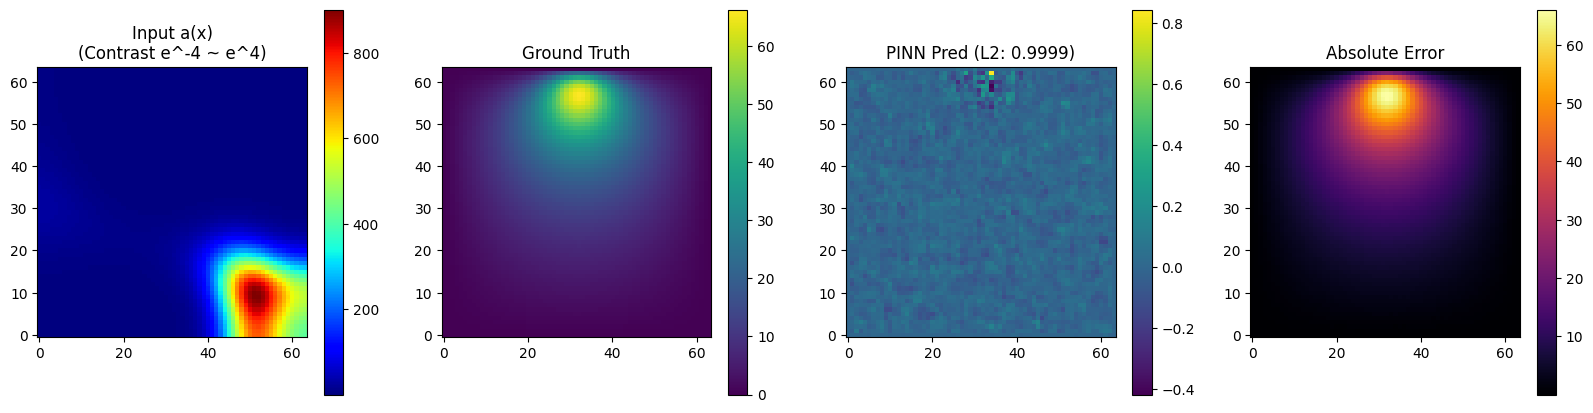

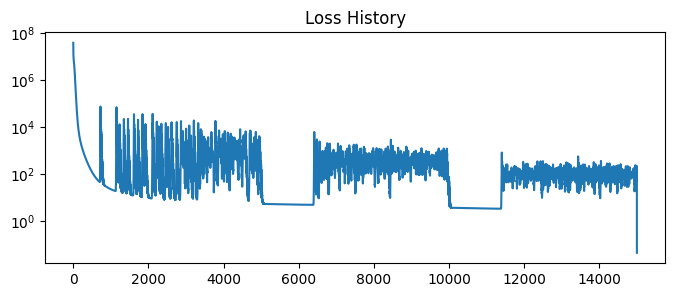

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정 및 Fourier Feature Layer
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# [Upgrade 1] Fourier Feature Embedding (고주파 성분 학습용)
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        # 랜덤한 주파수 B 행렬 생성 (고정)
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 1. 시뮬레이션 및 데이터 준비 (Log-PDE용 전처리)
# ----------------------------------------------------------------
def generate_darcy_data(N=64):
    print("generating high-contrast darcy data...")
    # [사용자 시뮬레이션 코드 로직 적용]
    h = 1.0 / (N - 1)
    
    # 1. Permeability a(x)
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0) # 패턴 크기 조절
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    # Contrast가 매우 큼 (e^-4 ~ e^4)
    beta = 4.0
    k_np = beta * a_smooth       # k = ln(a)
    a_np = np.exp(k_np)          # a = e^k
    
    # 2. Solver (Ground Truth 생성)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)
    
    # 3. [Upgrade 2] Log-Transformed Gradients 미리 계산
    # a 대신 ln(a)의 미분값을 사용하면 학습이 훨씬 안정적임
    # np.gradient returns [grad_axis_0(y), grad_axis_1(x)]
    grad_k = np.gradient(k_np, h)
    ky_np = grad_k[0] # dk/dy
    kx_np = grad_k[1] # dk/dx
    
    # PDE 우변 (1/a) 미리 계산
    inv_a_np = 1.0 / a_np

    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    return (to_tensor(kx_np), to_tensor(ky_np), to_tensor(inv_a_np), 
            to_tensor(u_np), to_tensor(a_np))

# ----------------------------------------------------------------
# 2. PINN Model (Fourier Features 적용)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # [업그레이드 1] Fourier Feature 차원 확장 (64 -> 128)
        # scale=10.0 정도로 키우면 고주파(세밀한 변화)를 더 잘 잡습니다.
        self.embedding = FourierEmbedding(in_features=2, out_features=128, scale=10.0)
        
        # [업그레이드 2] 더 넓고 깊은 MLP (64 -> 128, 3층 -> 5층)
        self.net = nn.Sequential(
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # 가중치 초기화 (필수)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        embedded = self.embedding(inputs)
        return self.net(embedded)
# ----------------------------------------------------------------
# 3. Log-PDE Loss Function
# ----------------------------------------------------------------
def compute_log_pde_loss(model, x, y, kx_field, ky_field, inv_a_field):
    """
    Log-Transformed Darcy Equation:
    Original: -div(a grad u) = 1
    Transformed: - (laplacian u + grad(ln a) . grad u) = 1/a
    Target: laplacian u + kx*u_x + ky*u_y + 1/a = 0
    """
    # 1. Grid Sampling (Interpolation)
    # 좌표 정규화 [0,1] -> [-1,1]
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        # 미분값들을 좌표에 맞춰 가져오기
        kx_val = torch.nn.functional.grid_sample(kx_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ky_val = torch.nn.functional.grid_sample(ky_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        inv_a_val = torch.nn.functional.grid_sample(inv_a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)

    # 2. Automatic Differentiation
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    u = model(x, y)
    
    # 1차 미분
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    # 2차 미분 (Laplacian)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 3. Residual Calculation (Log Formulation)
    # laplacian u + grad k . grad u + 1/a = 0
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
def train():
    # 데이터 준비
    kx_field, ky_field, inv_a_field, u_gt, a_field = generate_darcy_data()
    
    model = PINN().to(device)
    
    # -----------------------------------------------------------
    # Phase 1: Adam (Rough Optimization)
    # -----------------------------------------------------------
    print(f"\n🚀 Phase 1: Adam Optimization...")
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer_adam, step_size=5000, gamma=0.5)
    
    EPOCHS_ADAM = 15000  # Adam은 적당히 돌림
    N_col = 4096
    N_b = 1024
    
    loss_history = []
    
    model.train()
    start_time = time.time()
    
    # 고정된 학습 포인트 사용 (L-BFGS 안정성 위해 고정 추천, 여기선 매번 샘플링)
    # 성능을 위해 고정된 텐서를 미리 만들어둠
    x_col = torch.rand(N_col, 1).to(device)
    y_col = torch.rand(N_col, 1).to(device)
    
    # Boundary Points
    rb = torch.rand(N_b // 4, 1).to(device)
    ones = torch.ones_like(rb)
    zeros = torch.zeros_like(rb)
    x_b = torch.cat([rb, rb, zeros, ones], dim=0)
    y_b = torch.cat([zeros, ones, rb, rb], dim=0)

    for epoch in range(EPOCHS_ADAM):
        optimizer_adam.zero_grad()
        
        # Loss 계산
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        # BC 가중치 상향 (100 -> 1000): 경계 조건이 안 잡히면 내부도 안 잡힘
        loss = loss_pde + 1000.0 * loss_bc
        
        loss.backward()
        optimizer_adam.step()
        scheduler.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f"[Adam] Epoch {epoch+1}: Loss {loss.item():.5f} (BC: {loss_bc.item():.5f})")

    # -----------------------------------------------------------
    # Phase 2: L-BFGS (Fine-Tuning) -> 이것이 핵심!
    # -----------------------------------------------------------
    print(f"\n🚀 Phase 2: L-BFGS Optimization (The Finisher)...")
    
    # L-BFGS는 메모리를 많이 쓰지만 수렴 속도가 압도적임
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(), 
        lr=1.0, 
        max_iter=50000, 
        max_eval=50000, 
        history_size=50,
        tolerance_grad=1e-5, 
        tolerance_change=1.0 * np.finfo(float).eps,
        line_search_fn="strong_wolfe" # 필수 옵션
    )
    
    # L-BFGS용 Closure 함수 정의
    def closure():
        optimizer_lbfgs.zero_grad()
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        loss = loss_pde + 1000.0 * loss_bc # 동일한 가중치 사용
        loss.backward()
        return loss

    # 학습 실행
    optimizer_lbfgs.step(closure)
    
    # 최종 Loss 기록
    final_loss = closure().item()
    loss_history.append(final_loss)
    print(f"[L-BFGS] Final Loss: {final_loss:.5f}")

    print(f"Training Done. Total Time: {time.time()-start_time:.1f}s")
    return model, loss_history, u_gt, a_field
# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y) # (rows:y, cols:x)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
        
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    im0 = axes[0].imshow(a_np, origin='lower', cmap='jet')
    axes[0].set_title("Input a(x)\n(Contrast e^-4 ~ e^4)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(u_gt_np, origin='lower', cmap='viridis')
    axes[1].set_title("Ground Truth")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(u_pred, origin='lower', cmap='viridis')
    axes[2].set_title(f"PINN Pred (L2: {rel_l2:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno')
    axes[3].set_title("Absolute Error")
    plt.colorbar(im3, ax=axes[3])
    
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Loss History")
    plt.show()

if __name__ == "__main__":
    trained_model, loss_hist, u_gt, a_field = train()
    visualize(trained_model, loss_hist, u_gt, a_field)

Using device: cuda
generating high-contrast darcy data...

🚀 Phase 1: Adam Optimization...


/home/ubuntu/miniconda3/envs/jupyter/lib/python3.10/site-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Adam] Epoch 1000: Loss 22.10912 (BC: 0.00712)
[Adam] Epoch 2000: Loss 10.15231 (BC: 0.00670)
[Adam] Epoch 3000: Loss 2487.50049 (BC: 0.00619)
[Adam] Epoch 4000: Loss 156.83138 (BC: 0.00552)
[Adam] Epoch 5000: Loss 198.43594 (BC: 0.00502)
[Adam] Epoch 6000: Loss 4.87775 (BC: 0.00478)
[Adam] Epoch 7000: Loss 782.47949 (BC: 0.00443)
[Adam] Epoch 8000: Loss 250.02672 (BC: 0.00411)
[Adam] Epoch 9000: Loss 494.84833 (BC: 0.00383)
[Adam] Epoch 10000: Loss 58.97439 (BC: 0.00358)
[Adam] Epoch 11000: Loss 3.34862 (BC: 0.00334)
[Adam] Epoch 12000: Loss 39.92783 (BC: 0.00311)
[Adam] Epoch 13000: Loss 40.04139 (BC: 0.00291)
[Adam] Epoch 14000: Loss 24.45830 (BC: 0.00275)
[Adam] Epoch 15000: Loss 64.87789 (BC: 0.00260)

🚀 Phase 2: L-BFGS Optimization (The Finisher)...
[L-BFGS] Iter 1000: Loss 0.862035
[L-BFGS] Iter 2000: Loss 0.675406
[L-BFGS] Iter 3000: Loss 0.517677
[L-BFGS] Iter 4000: Loss 0.384189
[L-BFGS] Iter 5000: Loss 0.310748
[L-BFGS] Iter 6000: Loss 0.252906
[L-BFGS] Iter 7000: Loss 0.202

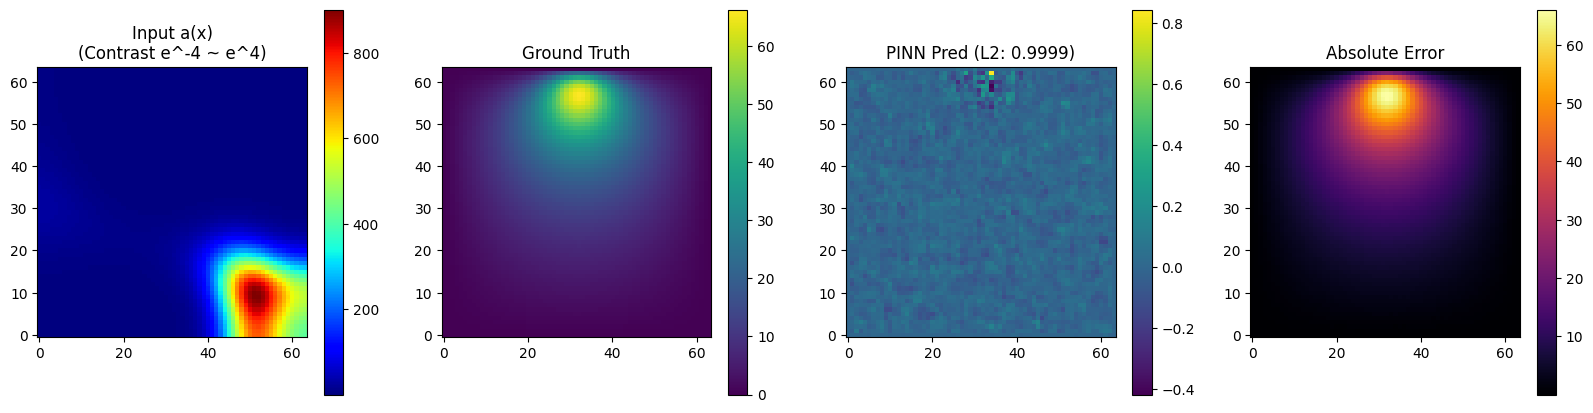

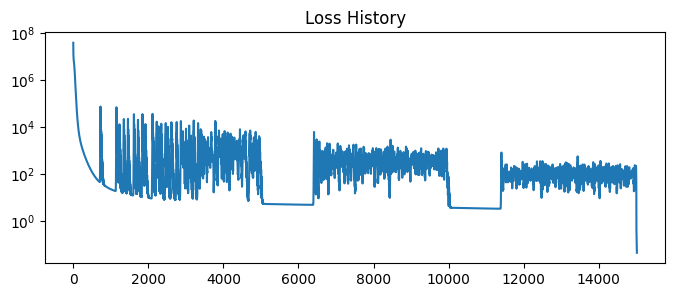

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정 및 Fourier Feature Layer
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# [Upgrade 1] Fourier Feature Embedding (고주파 성분 학습용)
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        # 랜덤한 주파수 B 행렬 생성 (고정)
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 1. 시뮬레이션 및 데이터 준비 (Log-PDE용 전처리)
# ----------------------------------------------------------------
def generate_darcy_data(N=64):
    print("generating high-contrast darcy data...")
    # [사용자 시뮬레이션 코드 로직 적용]
    h = 1.0 / (N - 1)
    
    # 1. Permeability a(x)
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0) # 패턴 크기 조절
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    # Contrast가 매우 큼 (e^-4 ~ e^4)
    beta = 4.0
    k_np = beta * a_smooth       # k = ln(a)
    a_np = np.exp(k_np)          # a = e^k
    
    # 2. Solver (Ground Truth 생성)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)
    
    # 3. [Upgrade 2] Log-Transformed Gradients 미리 계산
    # a 대신 ln(a)의 미분값을 사용하면 학습이 훨씬 안정적임
    # np.gradient returns [grad_axis_0(y), grad_axis_1(x)]
    grad_k = np.gradient(k_np, h)
    ky_np = grad_k[0] # dk/dy
    kx_np = grad_k[1] # dk/dx
    
    # PDE 우변 (1/a) 미리 계산
    inv_a_np = 1.0 / a_np

    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    return (to_tensor(kx_np), to_tensor(ky_np), to_tensor(inv_a_np), 
            to_tensor(u_np), to_tensor(a_np))

# ----------------------------------------------------------------
# 2. PINN Model (Fourier Features 적용)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # [업그레이드 1] Fourier Feature 차원 확장 (64 -> 128)
        # scale=10.0 정도로 키우면 고주파(세밀한 변화)를 더 잘 잡습니다.
        self.embedding = FourierEmbedding(in_features=2, out_features=128, scale=10.0)
        
        # [업그레이드 2] 더 넓고 깊은 MLP (64 -> 128, 3층 -> 5층)
        self.net = nn.Sequential(
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # 가중치 초기화 (필수)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        embedded = self.embedding(inputs)
        return self.net(embedded)
# ----------------------------------------------------------------
# 3. Log-PDE Loss Function
# ----------------------------------------------------------------
def compute_log_pde_loss(model, x, y, kx_field, ky_field, inv_a_field):
    """
    Log-Transformed Darcy Equation:
    Original: -div(a grad u) = 1
    Transformed: - (laplacian u + grad(ln a) . grad u) = 1/a
    Target: laplacian u + kx*u_x + ky*u_y + 1/a = 0
    """
    # 1. Grid Sampling (Interpolation)
    # 좌표 정규화 [0,1] -> [-1,1]
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        # 미분값들을 좌표에 맞춰 가져오기
        kx_val = torch.nn.functional.grid_sample(kx_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ky_val = torch.nn.functional.grid_sample(ky_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        inv_a_val = torch.nn.functional.grid_sample(inv_a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)

    # 2. Automatic Differentiation
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    u = model(x, y)
    
    # 1차 미분
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    
    # 2차 미분 (Laplacian)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 3. Residual Calculation (Log Formulation)
    # laplacian u + grad k . grad u + 1/a = 0
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 4. Training Loop
# ----------------------------------------------------------------
def train():
    # 데이터 준비
    kx_field, ky_field, inv_a_field, u_gt, a_field = generate_darcy_data()
    
    model = PINN().to(device)
    
    # -----------------------------------------------------------
    # Phase 1: Adam (Rough Optimization)
    # -----------------------------------------------------------
    print(f"\n🚀 Phase 1: Adam Optimization...")
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer_adam, step_size=5000, gamma=0.5)
    
    EPOCHS_ADAM = 15000  # Adam은 적당히 돌림
    N_col = 4096
    N_b = 1024
    
    loss_history = []
    
    model.train()
    start_time = time.time()
    
    # 고정된 학습 포인트 사용 (L-BFGS 안정성 위해 고정 추천)
    x_col = torch.rand(N_col, 1).to(device)
    y_col = torch.rand(N_col, 1).to(device)
    
    # Boundary Points
    rb = torch.rand(N_b // 4, 1).to(device)
    ones = torch.ones_like(rb)
    zeros = torch.zeros_like(rb)
    x_b = torch.cat([rb, rb, zeros, ones], dim=0)
    y_b = torch.cat([zeros, ones, rb, rb], dim=0)

    for epoch in range(EPOCHS_ADAM):
        optimizer_adam.zero_grad()
        
        # Loss 계산
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        # BC 가중치 상향 (100 -> 1000): 경계 조건이 안 잡히면 내부도 안 잡힘
        loss = loss_pde + 1000.0 * loss_bc
        
        loss.backward()
        optimizer_adam.step()
        scheduler.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f"[Adam] Epoch {epoch+1}: Loss {loss.item():.5f} (BC: {loss_bc.item():.5f})")

    # -----------------------------------------------------------
    # Phase 2: L-BFGS (Fine-Tuning) -> Logging Fix Applied!
    # -----------------------------------------------------------
    print(f"\n🚀 Phase 2: L-BFGS Optimization (The Finisher)...")
    
    # L-BFGS는 메모리를 많이 쓰지만 수렴 속도가 압도적임
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(), 
        lr=1.0, 
        max_iter=50000, 
        max_eval=50000, 
        history_size=50,
        tolerance_grad=1e-7, 
        tolerance_change=1.0 * np.finfo(float).eps,
        line_search_fn="strong_wolfe" # 필수 옵션
    )
    
    # Iteration counter for logging inside closure
    lbfgs_iter_count = 0
    
    # L-BFGS용 Closure 함수 정의 (Logging 추가됨)
    def closure():
        nonlocal lbfgs_iter_count
        optimizer_lbfgs.zero_grad()
        
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        loss = loss_pde + 1000.0 * loss_bc 
        
        loss.backward()
        
        # [Logging] 내부 반복문에서 출력
        lbfgs_iter_count += 1
        if lbfgs_iter_count % 1000 == 0:
            print(f"[L-BFGS] Iter {lbfgs_iter_count}: Loss {loss.item():.6f}")
            loss_history.append(loss.item()) # 그래프를 위해 기록
            
        return loss

    # 학습 실행
    optimizer_lbfgs.step(closure)
    
    # 최종 Loss 기록
    final_loss = closure().item()
    loss_history.append(final_loss)
    print(f"[L-BFGS] Final Loss: {final_loss:.5f}")

    print(f"Training Done. Total Time: {time.time()-start_time:.1f}s")
    return model, loss_history, u_gt, a_field

    
# ----------------------------------------------------------------
# 5. Visualization
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y) # (rows:y, cols:x)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
        
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    im0 = axes[0].imshow(a_np, origin='lower', cmap='jet')
    axes[0].set_title("Input a(x)\n(Contrast e^-4 ~ e^4)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(u_gt_np, origin='lower', cmap='viridis')
    axes[1].set_title("Ground Truth")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(u_pred, origin='lower', cmap='viridis')
    axes[2].set_title(f"PINN Pred (L2: {rel_l2:.4f})")
    plt.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno')
    axes[3].set_title("Absolute Error")
    plt.colorbar(im3, ax=axes[3])
    
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Loss History")
    plt.show()

if __name__ == "__main__":
    trained_model, loss_hist, u_gt, a_field = train()
    visualize(trained_model, loss_hist, u_gt, a_field)

# SiLU , reduce LR

Using device: cuda
Generating High-Contrast Permeability & Ground Truth...

🚀 Phase 1: Adam Optimization (Safe Mode)...
[Adam] Epoch 1000: Loss 1416.53613 (BC: 1.30166)
[Adam] Epoch 2000: Loss 438.92316 (BC: 1.00458)
[Adam] Epoch 3000: Loss 239.41724 (BC: 0.80667)
[Adam] Epoch 4000: Loss 168.63965 (BC: 0.65120)
[Adam] Epoch 5000: Loss 167.84776 (BC: 0.55661)
[Adam] Epoch 6000: Loss 90.71127 (BC: 0.46961)
[Adam] Epoch 7000: Loss 1218.06140 (BC: 0.40625)
[Adam] Epoch 8000: Loss 60.80072 (BC: 0.36535)
[Adam] Epoch 9000: Loss 56.67678 (BC: 0.32553)
[Adam] Epoch 10000: Loss 83.48936 (BC: 0.29320)
[Adam] Epoch 11000: Loss 164.43225 (BC: 0.26778)
[Adam] Epoch 12000: Loss 42.30007 (BC: 0.24741)
[Adam] Epoch 13000: Loss 169.00352 (BC: 0.22256)
[Adam] Epoch 14000: Loss 31.78385 (BC: 0.20372)
[Adam] Epoch 15000: Loss 203.82190 (BC: 0.18715)

🚀 Phase 2: L-BFGS Optimization (The Finisher)...
[L-BFGS] Iter 1000: Loss 9.382411
[L-BFGS] Iter 2000: Loss 4.864861
[L-BFGS] Iter 3000: Loss 2.557228
[L-BFG

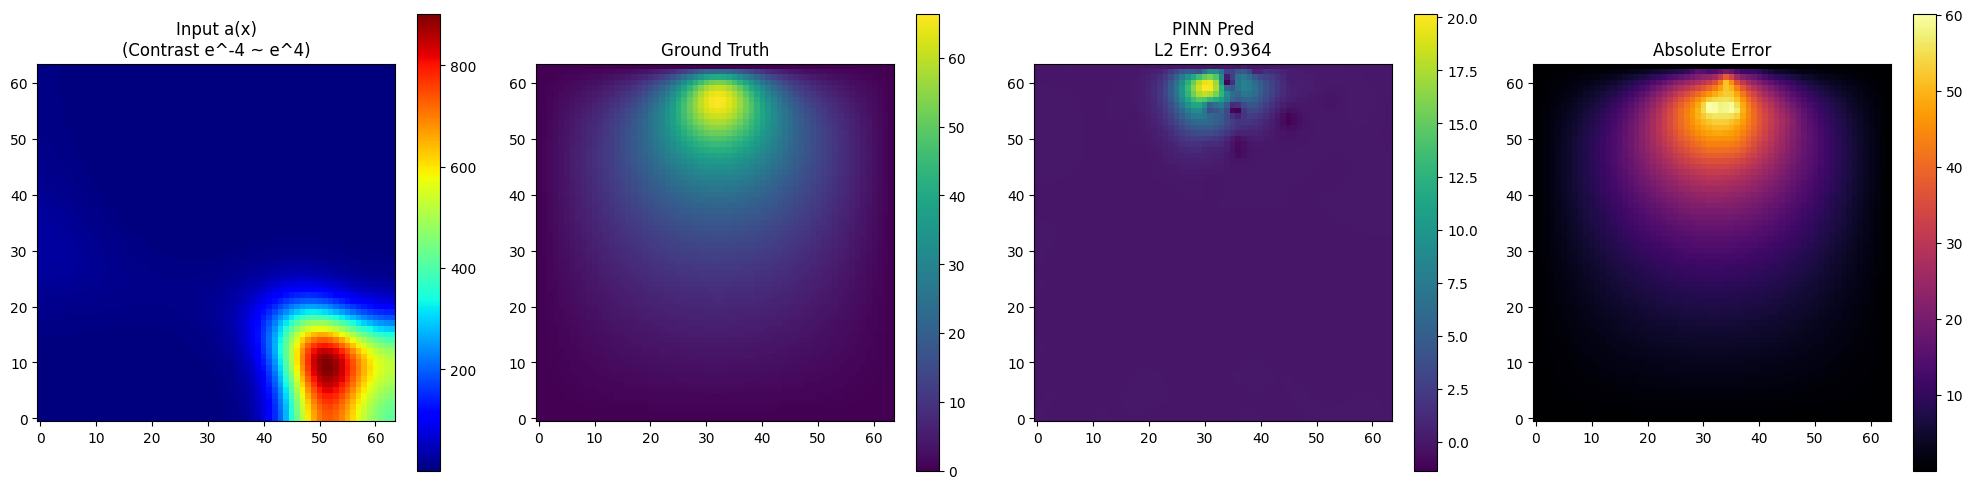

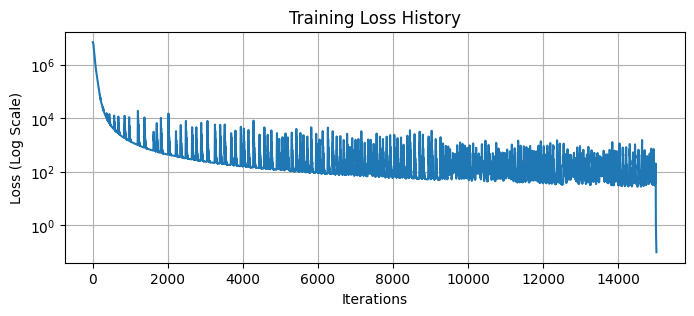

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. Global Settings
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# ----------------------------------------------------------------
# 1. Fourier Feature Embedding
# ----------------------------------------------------------------
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=5.0):
        super().__init__()
        # [Safety 1] Scale을 10.0에서 5.0으로 낮춤 (폭발 방지)
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 2. Data Generation (Simulation + Pre-computation)
# ----------------------------------------------------------------
def generate_darcy_data(N=64):
    print("Generating High-Contrast Permeability & Ground Truth...")
    h = 1.0 / (N - 1)
    
    # 1. Permeability a(x) 생성
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0)
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    
    # High Contrast (e^-4 ~ e^4)
    beta = 4.0
    k_np = beta * a_smooth       # k = ln(a)
    a_np = np.exp(k_np)          # a = e^k
    
    # 2. FDM Solver로 정답(Ground Truth) 계산
    num = N * N
    rhs = np.ones(num) * h**2 # f = 1
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            # Boundary Condition (u=0)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)
    
    # 3. Log-PDE용 Gradient 미리 계산 (안정성 핵심)
    # np.gradient returns [grad_y, grad_x]
    grad_k = np.gradient(k_np, h)
    ky_np = grad_k[0] 
    kx_np = grad_k[1] 
    inv_a_np = 1.0 / a_np

    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    return (to_tensor(kx_np), to_tensor(ky_np), to_tensor(inv_a_np), 
            to_tensor(u_np), to_tensor(a_np))

# ----------------------------------------------------------------
# 3. PINN Model (Stable Architecture)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # Embedding: 2 -> 128
        self.embedding = FourierEmbedding(in_features=2, out_features=128, scale=5.0)
        
        # [Safety 2] Activation: Tanh -> SiLU (Swish)
        # Gradient Vanishing/Explosion에 훨씬 강함
        self.net = nn.Sequential(
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 1)
        )
        
        # Xavier Normal Init
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        return self.net(self.embedding(inputs))

# ----------------------------------------------------------------
# 4. Log-PDE Loss Function
# ----------------------------------------------------------------
def compute_log_pde_loss(model, x, y, kx_field, ky_field, inv_a_field):
    """
    Solves: Laplacian(u) + Grad(ln a) * Grad(u) + 1/a = 0
    """
    # 1. Coefficients Sampling (Interpolation)
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        kx_val = torch.nn.functional.grid_sample(kx_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ky_val = torch.nn.functional.grid_sample(ky_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        inv_a_val = torch.nn.functional.grid_sample(inv_a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)

    # 2. Auto-diff
    x.requires_grad_(True)
    y.requires_grad_(True)
    u = model(x, y)
    
    # 1st derivatives
    grads = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_x = grads
    grads = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_y = grads
    
    # 2nd derivatives
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 3. Residual
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 5. Training Loop (Adam + L-BFGS)
# ----------------------------------------------------------------
def train():
    # 데이터 준비
    kx_field, ky_field, inv_a_field, u_gt, a_field = generate_darcy_data()
    
    model = PINN().to(device)
    
    # Collocation Points (L-BFGS 안정성을 위해 고정된 점 사용)
    N_col = 5000
    N_b = 1000
    x_col = torch.rand(N_col, 1).to(device)
    y_col = torch.rand(N_col, 1).to(device)
    
    # Boundary Points
    rb = torch.rand(N_b // 4, 1).to(device)
    ones = torch.ones_like(rb)
    zeros = torch.zeros_like(rb)
    x_b = torch.cat([rb, rb, zeros, ones], dim=0)
    y_b = torch.cat([zeros, ones, rb, rb], dim=0)

    loss_history = []
    
    # -----------------------------------------------------------
    # Phase 1: Adam (Stabilized Warm-up)
    # -----------------------------------------------------------
    print(f"\n🚀 Phase 1: Adam Optimization (Safe Mode)...")
    # [Safety 3] LR = 0.0005 (천천히 안전하게)
    optimizer_adam = optim.Adam(model.parameters(), lr=0.0005)
    EPOCHS_ADAM = 15000
    
    model.train()
    start_time = time.time()
    
    for epoch in range(EPOCHS_ADAM):
        optimizer_adam.zero_grad()
        
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        # [Safety 4] BC Weight 100.0 (과도한 제약 완화)
        loss = loss_pde + 100.0 * loss_bc
        
        loss.backward()
        optimizer_adam.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(f"[Adam] Epoch {epoch+1}: Loss {loss.item():.5f} (BC: {loss_bc.item():.5f})")

    # -----------------------------------------------------------
    # Phase 2: L-BFGS (Fine-Tuning)
    # -----------------------------------------------------------
    print(f"\n🚀 Phase 2: L-BFGS Optimization (The Finisher)...")
    
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(), 
        lr=1.0, 
        max_iter=50000, 
        max_eval=50000, 
        history_size=50,
        tolerance_grad=1e-7, 
        tolerance_change=1.0 * np.finfo(float).eps,
        line_search_fn="strong_wolfe"
    )
    
    lbfgs_iter_count = 0
    
    def closure():
        nonlocal lbfgs_iter_count
        optimizer_lbfgs.zero_grad()
        
        loss_pde = compute_log_pde_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        loss = loss_pde + 100.0 * loss_bc # 동일한 가중치
        
        loss.backward()
        
        lbfgs_iter_count += 1
        if lbfgs_iter_count % 1000 == 0:
            print(f"[L-BFGS] Iter {lbfgs_iter_count}: Loss {loss.item():.6f}")
            loss_history.append(loss.item())
            
        return loss

    optimizer_lbfgs.step(closure)
    
    final_loss = closure().item()
    loss_history.append(final_loss)
    print(f"[L-BFGS] Final Loss: {final_loss:.6f}")
    print(f"Total Time: {time.time()-start_time:.1f}s")
    
    return model, loss_history, u_gt, a_field

# ----------------------------------------------------------------
# 6. Visualization
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
    
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    # Error Metrics
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    im0 = axes[0].imshow(a_np, origin='lower', cmap='jet')
    axes[0].set_title("Input a(x)\n(Contrast e^-4 ~ e^4)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(u_gt_np, origin='lower', cmap='viridis')
    axes[1].set_title("Ground Truth")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(u_pred, origin='lower', cmap='viridis')
    axes[2].set_title(f"PINN Pred\nL2 Err: {rel_l2:.4f}")
    plt.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno')
    axes[3].set_title("Absolute Error")
    plt.colorbar(im3, ax=axes[3])
    
    plt.tight_layout()
    plt.show()
    
    # Loss History
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Training Loss History")
    plt.xlabel("Iterations")
    plt.ylabel("Loss (Log Scale)")
    plt.grid(True)
    plt.show()

# ----------------------------------------------------------------
# Main Execution
# ----------------------------------------------------------------
if __name__ == "__main__":
    trained_model, loss_hist, u_gt, a_field = train()
    visualize(trained_model, loss_hist, u_gt, a_field)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# ----------------------------------------------------------------
# 1. Fourier Embedding (고주파 대응)
# ----------------------------------------------------------------
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 2. 데이터 준비 (Curriculum Learning을 위한 Base 생성)
# ----------------------------------------------------------------
def prepare_curriculum_data(N=64):
    print("Preparing Base Data for Curriculum Learning...")
    h = 1.0 / (N - 1)
    
    # 1. Base Smooth Field 생성 (정규화된 a_smooth)
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0)
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    
    # 2. Base Gradient 미리 계산 (나중에 beta만 곱하면 됨)
    # grad_smooth = [dy, dx]
    grad_smooth = np.gradient(a_smooth, h)
    sy_np = grad_smooth[0] # y방향 미분 기본값
    sx_np = grad_smooth[1] # x방향 미분 기본값
    
    # 3. Validation용 Ground Truth (Beta=4.0 최종 난이도)
    beta_final = 4.0
    a_final_np = np.exp(beta_final * a_smooth)
    
    # FDM Solver로 최종 정답 미리 계산
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_final_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_gt_np = spla.spsolve(A, rhs).reshape(N, N)

    # Tensor 변환
    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    
    return (to_tensor(a_smooth), to_tensor(sx_np), to_tensor(sy_np), 
            to_tensor(u_gt_np), to_tensor(a_final_np))

# ----------------------------------------------------------------
# 3. PINN Model (Robust)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Fourier Scale 5.0 (안정적)
        self.embedding = FourierEmbedding(in_features=2, out_features=128, scale=5.0)
        # SiLU Activation
        self.net = nn.Sequential(
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 1)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        return self.net(self.embedding(torch.cat([x, y], dim=1)))

# ----------------------------------------------------------------
# 4. Physics Loss (Curriculum 지원)
# ----------------------------------------------------------------
def compute_loss(model, x, y, a_smooth, sx, sy, beta):
    """
    beta: 현재 난이도 (0.0 -> 4.0)
    """
    # 1. Dynamic Coefficients Calculation
    # 현재 beta에 맞춰 물리 계수 생성
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        
        # Base Field Sampling
        a_smooth_val = torch.nn.functional.grid_sample(a_smooth.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        sx_val = torch.nn.functional.grid_sample(sx.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        sy_val = torch.nn.functional.grid_sample(sy.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        
        # Scaling
        # k = beta * a_smooth
        # grad_k = beta * grad_smooth
        kx_val = beta * sx_val
        ky_val = beta * sy_val
        # inv_a = 1 / exp(beta * a_smooth)
        inv_a_val = 1.0 / torch.exp(beta * a_smooth_val)

    # 2. Auto-diff
    x.requires_grad_(True); y.requires_grad_(True)
    u = model(x, y)
    
    grads = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_x = grads
    grads = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_y = grads
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # 3. Residual
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 5. Training with Curriculum Strategy
# ----------------------------------------------------------------
def train():
    # 데이터 로드
    a_smooth, sx, sy, u_gt, a_final = prepare_curriculum_data()
    model = PINN().to(device)
    
    # --- Phase 1: Adam with Curriculum (Easy -> Hard) ---
    print("\n🚀 Phase 1: Adam with Curriculum (Beta 0.0 -> 4.0)...")
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    
    EPOCHS_ADAM = 20000
    N_col = 4096
    N_b = 1024
    
    # Fixed points for stability
    x_col = torch.rand(N_col, 1).to(device)
    y_col = torch.rand(N_col, 1).to(device)
    rb = torch.rand(N_b // 4, 1).to(device)
    ones = torch.ones_like(rb); zeros = torch.zeros_like(rb)
    x_b = torch.cat([rb, rb, zeros, ones], dim=0)
    y_b = torch.cat([zeros, ones, rb, rb], dim=0)
    
    loss_history = []
    model.train()
    start_time = time.time()
    
    for epoch in range(EPOCHS_ADAM):
        optimizer_adam.zero_grad()
        
        # [핵심] Curriculum Beta Schedule
        # 처음 50% 구간동안 Beta를 0에서 4.0까지 선형 증가
        progress = min(1.0, epoch / (EPOCHS_ADAM * 0.8)) 
        current_beta = 4.0 * progress
        
        # Loss 계산
        loss_pde = compute_loss(model, x_col, y_col, a_smooth, sx, sy, current_beta)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        
        loss = loss_pde + 100.0 * loss_bc
        
        loss.backward()
        optimizer_adam.step()
        
        loss_history.append(loss.item())
        if (epoch + 1) % 1000 == 0:
            print(f"[Adam] Epoch {epoch+1}: Loss {loss.item():.5f} | Beta: {current_beta:.2f} | BC: {loss_bc.item():.5f}")

    # --- Phase 2: L-BFGS (Final Polishing at Beta=4.0) ---
    print("\n🚀 Phase 2: L-BFGS Optimization (Fixed Beta=4.0)...")
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(), lr=1.0, 
        max_iter=50000, max_eval=50000, 
        history_size=50, tolerance_grad=1e-7, 
        tolerance_change=1.0 * np.finfo(float).eps,
        line_search_fn="strong_wolfe"
    )
    
    lbfgs_iter = 0
    def closure():
        nonlocal lbfgs_iter
        optimizer_lbfgs.zero_grad()
        # Beta 고정 (4.0)
        loss_pde = compute_loss(model, x_col, y_col, a_smooth, sx, sy, beta=4.0)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        loss = loss_pde + 100.0 * loss_bc
        loss.backward()
        
        lbfgs_iter += 1
        if lbfgs_iter % 1000 == 0:
            print(f"[L-BFGS] Iter {lbfgs_iter}: Loss {loss.item():.6f}")
            loss_history.append(loss.item())
        return loss

    optimizer_lbfgs.step(closure)
    
    print(f"Total Time: {time.time()-start_time:.1f}s")
    return model, loss_history, u_gt, a_final

# ----------------------------------------------------------------
# 6. Visualization
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
    
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    # Scale Adjustment (Optional visualization trick)
    # PINN might learn a scaled version, but let's check raw L2 first
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(a_np, origin='lower', cmap='jet'); axes[0].set_title("Input a(x)")
    axes[1].imshow(u_gt_np, origin='lower', cmap='viridis'); axes[1].set_title("Ground Truth")
    axes[2].imshow(u_pred, origin='lower', cmap='viridis'); axes[2].set_title(f"PINN Pred (L2: {rel_l2:.4f})")
    axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno'); axes[3].set_title("Absolute Error")
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Loss History (Curriculum -> L-BFGS)")
    plt.show()

if __name__ == "__main__":
    model, loss_hist, u_gt, a_final = train()
    visualize(model, loss_hist, u_gt, a_final)

# PINO TTO

Using device: cuda

🚀 Phase 1: Pre-training FNO (Supervised)...
[Pre-train] Epoch 100: MSE Loss 150.329620
[Pre-train] Epoch 200: MSE Loss 86.390671
[Pre-train] Epoch 300: MSE Loss 45.570370
[Pre-train] Epoch 400: MSE Loss 26.107853
[Pre-train] Epoch 500: MSE Loss 18.513027
[Pre-train] Epoch 600: MSE Loss 13.118873
[Pre-train] Epoch 700: MSE Loss 10.944494
[Pre-train] Epoch 800: MSE Loss 9.157963
[Pre-train] Epoch 900: MSE Loss 8.360185
[Pre-train] Epoch 1000: MSE Loss 7.619205
[Pre-train] Epoch 1100: MSE Loss 7.259702
[Pre-train] Epoch 1200: MSE Loss 6.906660
[Pre-train] Epoch 1300: MSE Loss 6.727595
[Pre-train] Epoch 1400: MSE Loss 6.546122
[Pre-train] Epoch 1500: MSE Loss 6.452276
[Pre-train] Epoch 1600: MSE Loss 6.355999
[Pre-train] Epoch 1700: MSE Loss 6.305426
[Pre-train] Epoch 1800: MSE Loss 6.252977
[Pre-train] Epoch 1900: MSE Loss 6.225428
[Pre-train] Epoch 2000: MSE Loss 6.197103
[Pre-train] Epoch 2100: MSE Loss 6.182031
[Pre-train] Epoch 2200: MSE Loss 6.166582
[Pre-train] E

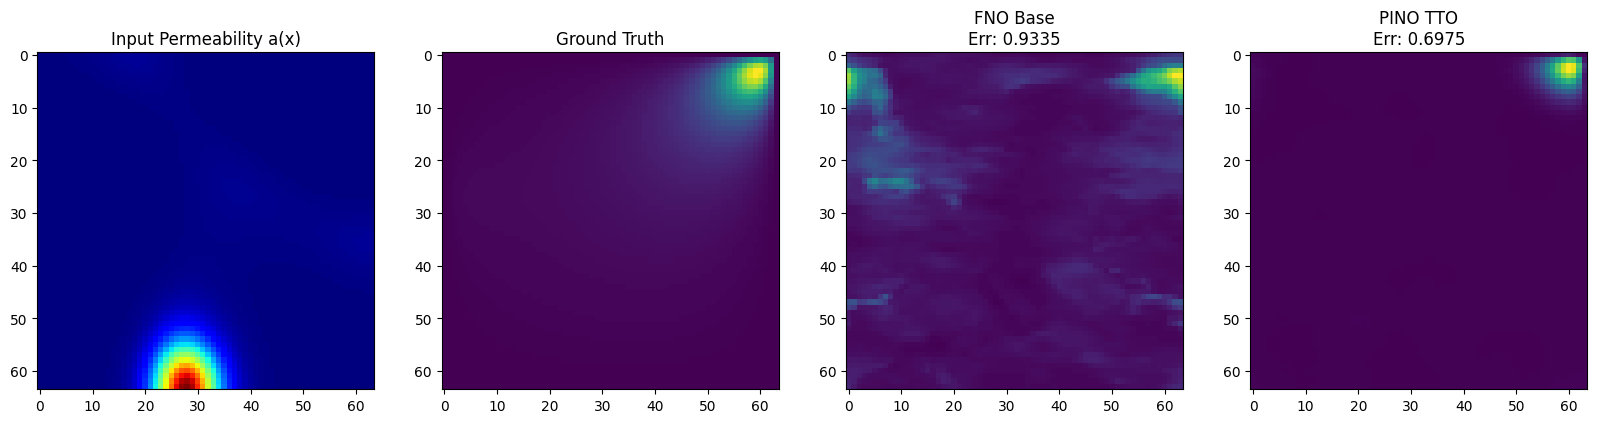

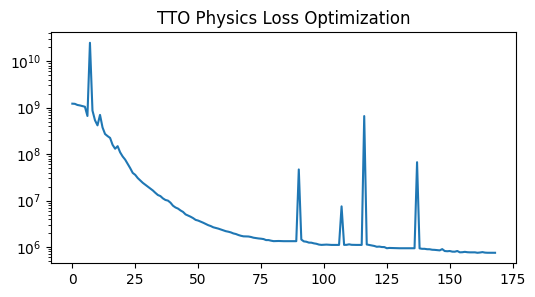

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# ----------------------------------------------------------------
# 1. Grid 기반 미분 필터 (Finite Difference for Images)
# ----------------------------------------------------------------
class GridDerivatives(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.h = h
        # Central Difference Kernels
        # dx: [[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]]
        self.kx = torch.tensor([[[[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]]]], device=device) / h
        self.ky = torch.tensor([[[[0, -0.5, 0], [0, 0, 0], [0, 0.5, 0]]]], device=device) / h
        
        # Laplacian Kernels (5-point stencil)
        # lap: [[0, 1, 0], [1, -4, 1], [0, 1, 0]]
        self.klap = torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], device=device) / (h**2)

    def grad(self, u):
        ux = F.conv2d(u, self.kx, padding=1)
        uy = F.conv2d(u, self.ky, padding=1)
        return ux, uy

    def laplacian(self, u):
        return F.conv2d(u, self.klap, padding=1)

# ----------------------------------------------------------------
# 2. FNO Architecture (The Operator)
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
            
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width
        
        # Input: (a, x, y) -> 3 channels
        self.fc0 = nn.Linear(3, self.width) 
        
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x: (Batch, 1, 64, 64) -> Permeability a
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x); x2 = self.w0(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv1(x); x2 = self.w1(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv2(x); x2 = self.w2(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv3(x); x2 = self.w3(x); x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = F.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2) # (Batch, 1, H, W)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

# ----------------------------------------------------------------
# 3. 데이터 생성 (Batch Generator)
# ----------------------------------------------------------------
def generate_batch(batch_size=20, N=64):
    h = 1.0 / (N - 1)
    a_list, u_list = [], []
    
    for _ in range(batch_size):
        # High Contrast a(x)
        xi = np.random.randn(N, N)
        a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0)
        a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
        # Beta=4.0 (e^-4 ~ e^4)
        a_np = np.exp(4.0 * a_smooth)
        
        # Solver
        num = N * N
        rhs = np.ones(num) * h**2
        idx = lambda r, c: r*N + c
        row, col, data = [], [], []
        
        for i in range(N):
            for j in range(N):
                curr = idx(i, j)
                if i==0 or i==N-1 or j==0 or j==N-1:
                    row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
                else:
                    ac = a_np[i,j]
                    row.append(curr); col.append(curr); data.append(4*ac)
                    row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                    row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                    row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                    row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                    
        A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
        u_np = spla.spsolve(A, rhs).reshape(N, N)
        
        a_list.append(a_np); u_list.append(u_np)
        
    a_tensor = torch.tensor(np.array(a_list), dtype=torch.float32).unsqueeze(1).to(device) # (B, 1, H, W)
    u_tensor = torch.tensor(np.array(u_list), dtype=torch.float32).unsqueeze(1).to(device)
    
    return a_tensor, u_tensor

# ----------------------------------------------------------------
# 4. Phase 1: Pre-training (Supervised FNO)
# ----------------------------------------------------------------
def pretrain_fno(model, epochs=1000):
    print(f"\n🚀 Phase 1: Pre-training FNO (Supervised)...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
    
    # 50개의 샘플로 학습 (Small Data Regime)
    train_a, train_u = generate_batch(batch_size=50)
    
    model.train()
    for ep in range(epochs):
        optimizer.zero_grad()
        pred = model(train_a)
        loss = F.mse_loss(pred, train_u)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if (ep+1) % 100 == 0:
            print(f"[Pre-train] Epoch {ep+1}: MSE Loss {loss.item():.6f}")
            
    print("✅ Pre-training Complete.")
    return model

# ----------------------------------------------------------------
# 5. Phase 2: PINO Test-Time Optimization
# ----------------------------------------------------------------
def pino_tto(model, test_a, test_u_gt):
    print(f"\n🚀 Phase 2: Test-Time Optimization (Physics-Loss only)...")
    
    # 모델 복사 (TTO는 특정 샘플에 대해서만 튜닝하므로 원본 보존 권장)
    # 여기선 바로 튜닝합니다.
    model.train()
    
    # Optimizer: L-BFGS for high precision
    optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=200, history_size=50, line_search_fn="strong_wolfe")
    
    # Physics Utils
    h = 1.0 / 63.0 # N=64 -> h=1/63
    diff_layer = GridDerivatives(h)
    
    # Log-PDE Preparation
    # a -> ln(a)
    log_a = torch.log(test_a) # (1, 1, 64, 64)
    inv_a = 1.0 / test_a
    
    # Pre-compute grad(ln a) using filters
    d_log_a_x, d_log_a_y = diff_layer.grad(log_a)
    
    loss_hist = []
    
    def closure():
        optimizer.zero_grad()
        u_pred = model(test_a)
        
        # 1. Boundary Loss (Hard Constraint or Penalty)
        # Grid 가장자리: 0
        loss_bc = torch.mean(u_pred[..., 0, :]**2) + \
                  torch.mean(u_pred[..., -1, :]**2) + \
                  torch.mean(u_pred[..., :, 0]**2) + \
                  torch.mean(u_pred[..., :, -1]**2)
        
        # 2. Physics Loss (Log-PDE on Grid)
        # Eq: Laplacian(u) + Grad(ln a).Grad(u) + 1/a = 0
        u_xx_yy = diff_layer.laplacian(u_pred)
        u_x, u_y = diff_layer.grad(u_pred)
        
        # Inner Domain Slicing (Padding으로 인해 외곽 1픽셀은 미분 부정확)
        res = u_xx_yy + (d_log_a_x * u_x) + (d_log_a_y * u_y) + inv_a
        
        # 경계 제외하고 내부 잔차만 계산
        loss_pde = torch.mean(res[..., 1:-1, 1:-1]**2)
        
        loss = loss_pde + 1000.0 * loss_bc
        loss.backward()
        
        loss_hist.append(loss.item())
        return loss

    optimizer.step(closure)
    print(f"✅ TTO Complete. Final Physics Loss: {loss_hist[-1]:.6f}")
    
    return model, loss_hist

# ----------------------------------------------------------------
# Main Execution
# ----------------------------------------------------------------
# 1. 모델 생성
fno = FNO2d(modes=12, width=32).to(device)

# 2. Pre-training (데이터 기반)
fno = pretrain_fno(fno, epochs=5000)

# 3. 새로운 테스트 케이스 생성 (High Contrast)
test_a, test_u_gt = generate_batch(batch_size=1)

# 4. FNO 예측 (Before TTO)
fno.eval()
with torch.no_grad():
    pred_init = fno(test_a)
    l2_init = torch.norm(pred_init - test_u_gt) / torch.norm(test_u_gt)
print(f"\n[Result] FNO Initial Error: {l2_init.item():.4f}")

# 5. PINO TTO 수행
fno, loss_hist = pino_tto(fno, test_a, test_u_gt)

# 6. 최종 예측 (After TTO)
fno.eval()
with torch.no_grad():
    pred_final = fno(test_a)
    l2_final = torch.norm(pred_final - test_u_gt) / torch.norm(test_u_gt)
print(f"[Result] PINO TTO Error:     {l2_final.item():.4f}")

# 7. 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
a_plot = test_a.cpu().numpy()[0,0]
u_gt_plot = test_u_gt.cpu().numpy()[0,0]
u_init_plot = pred_init.cpu().numpy()[0,0]
u_final_plot = pred_final.cpu().numpy()[0,0]

axes[0].imshow(a_plot, cmap='jet'); axes[0].set_title("Input Permeability a(x)")
axes[1].imshow(u_gt_plot, cmap='viridis'); axes[1].set_title("Ground Truth")
axes[2].imshow(u_init_plot, cmap='viridis'); axes[2].set_title(f"FNO Base\nErr: {l2_init:.4f}")
axes[3].imshow(u_final_plot, cmap='viridis'); axes[3].set_title(f"PINO TTO\nErr: {l2_final:.4f}")
plt.show()

plt.figure(figsize=(6,3))
plt.plot(loss_hist)
plt.yscale('log')
plt.title("TTO Physics Loss Optimization")
plt.show()

In [ ]:
# phase PINO

Using device: cuda
Generating 2000 samples...
   ... 100/2000 completed
   ... 200/2000 completed
   ... 300/2000 completed
   ... 400/2000 completed
   ... 500/2000 completed
   ... 600/2000 completed
   ... 700/2000 completed
   ... 800/2000 completed
   ... 900/2000 completed
   ... 1000/2000 completed
   ... 1100/2000 completed
   ... 1200/2000 completed
   ... 1300/2000 completed
   ... 1400/2000 completed
   ... 1500/2000 completed
   ... 1600/2000 completed
   ... 1700/2000 completed
   ... 1800/2000 completed
   ... 1900/2000 completed
   ... 2000/2000 completed
Generating 50 samples...

Data Prepared: Train torch.Size([2000, 1, 64, 64]), Test torch.Size([50, 1, 64, 64])

🚀 Starting Training...
--- [Phase 1] Supervised Pretraining (600 epochs) ---
Epoch 10: L2 Loss = 0.724411
Epoch 20: L2 Loss = 0.647445
Epoch 30: L2 Loss = 0.567929
Epoch 40: L2 Loss = 0.532985
Epoch 50: L2 Loss = 0.445674
Epoch 60: L2 Loss = 0.370860
Epoch 70: L2 Loss = 0.342302
Epoch 80: L2 Loss = 0.317892
Ep

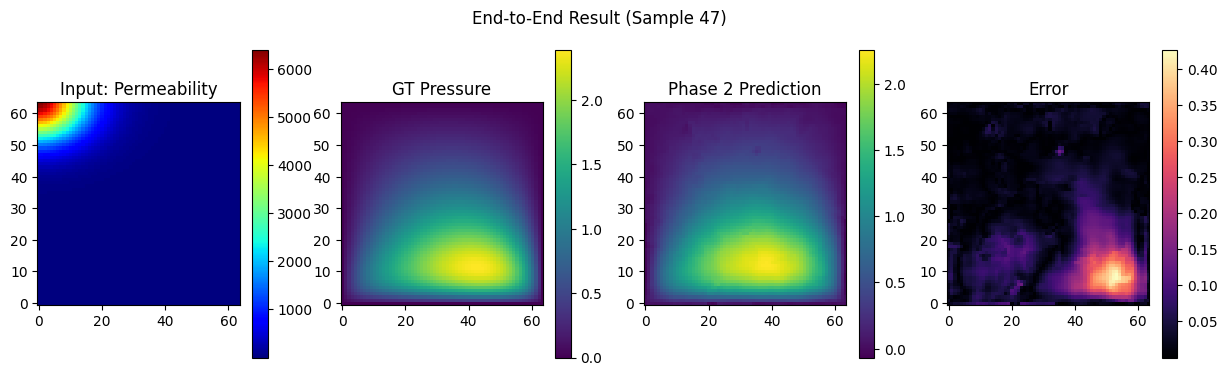

In [8]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.ndimage
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# ----------------------------------------------------------------
# [0] Global Settings
# ----------------------------------------------------------------
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# [Step 1] Classical FDM Solver (Data Generator)
# ----------------------------------------------------------------
class DarcySolver:
    def __init__(self, N=64):
        self.N = N
        self.h = 1.0 / (N - 1)
        self.x = np.linspace(0, 1, N)
        self.y = np.linspace(0, 1, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)

    def generate_random_permeability(self, alpha=3.0, beta=4.0):
        xi = np.random.randn(self.N, self.N)
        real_alpha = np.random.uniform(2.0, 4.0) 
        sigma = self.N / real_alpha
        a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=sigma)
        
        # 정규화 후 스케일링 (Contrast 극대화)
        a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
        a = np.exp(beta * a_smooth) 
        return a

    def solve(self, a_field):
        """
        Finite Difference Method (5-point stencil)
        -div(a * grad u) = 1
        """
        N = self.N
        h = self.h
        num_unknowns = N * N
        idx = lambda i, j: i * N + j
        
        row, col, data = [], [], []
        rhs = np.ones(num_unknowns) * h**2 # f=1
        
        for i in range(N):
            for j in range(N):
                curr = idx(i, j)
                
                # 경계 조건 (Dirichlet u=0)
                if i == 0 or i == N-1 or j == 0 or j == N-1:
                    row.append(curr); col.append(curr); data.append(1.0)
                    rhs[curr] = 0.0
                    continue
                
                # 내부 점
                a_c = a_field[i, j]
                row.append(curr); col.append(curr); data.append(4 * a_c)
                row.append(curr); col.append(idx(i-1, j)); data.append(-a_c)
                row.append(curr); col.append(idx(i+1, j)); data.append(-a_c)
                row.append(curr); col.append(idx(i, j-1)); data.append(-a_c)
                row.append(curr); col.append(idx(i, j+1)); data.append(-a_c)
                
        A = sp.coo_matrix((data, (row, col)), shape=(num_unknowns, num_unknowns)).tocsc()
        u = spla.spsolve(A, rhs)
        return u.reshape(N, N)

def generate_dataset(num_samples, N=64):
    solver = DarcySolver(N)
    data_a = []
    data_u = []
    
    print(f"Generating {num_samples} samples...")
    for i in range(num_samples):
        a = solver.generate_random_permeability()
        u = solver.solve(a)
        data_a.append(a)
        data_u.append(u)
        if (i + 1) % 100 == 0:
            print(f"   ... {i + 1}/{num_samples} completed")
            
    # (Batch, Channel=1, H, W)
    return np.array(data_a)[:, np.newaxis, :, :], np.array(data_u)[:, np.newaxis, :, :]

# ----------------------------------------------------------------
# [Step 2] Prepare Data
# ----------------------------------------------------------------
# 학습용 1000개, 테스트용 50개 생성
N_GRID = 64
train_a, train_u = generate_dataset(2000, N=N_GRID)
test_a, test_u = generate_dataset(50, N=N_GRID)

# Tensor 변환
x_train = torch.tensor(train_a, dtype=torch.float32)
y_train = torch.tensor(train_u, dtype=torch.float32)
x_test = torch.tensor(test_a, dtype=torch.float32)
y_test = torch.tensor(test_u, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=False)

print(f"\nData Prepared: Train {x_train.shape}, Test {x_test.shape}")

# ----------------------------------------------------------------
# [Step 3] Model Definition: FNO (Fourier Neural Operator)
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input: (a, x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x); x2 = self.w0(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv1(x); x2 = self.w1(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv2(x); x2 = self.w2(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv3(x); x2 = self.w3(x); x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = F.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

# ----------------------------------------------------------------
# [Step 4] Physics Loss & Training Logic
# ----------------------------------------------------------------
def compute_pde_residual(u, a):
    """
    Computes PDE residual: -div(a grad u) = 1  =>  div(a grad u) + 1 = 0
    """
    h = 1.0 / (u.shape[-1] - 1)
    
    # Central Difference Filters
    filter_x = torch.tensor([[[[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]]]], device=u.device) / h
    filter_y = torch.tensor([[[[0, -0.5, 0], [0, 0, 0], [0, 0.5, 0]]]], device=u.device) / h
    
    ux = F.conv2d(u, filter_x, padding=1)
    uy = F.conv2d(u, filter_y, padding=1)
    
    qx = a * ux
    qy = a * uy
    
    du_xx = F.conv2d(qx, filter_x, padding=1)
    du_yy = F.conv2d(qy, filter_y, padding=1)
    
    div_flux = du_xx + du_yy
    
    # Ignore boundaries
    residual = div_flux[:, :, 2:-2, 2:-2] + 1.0 
    return residual

def relative_l2_loss(pred, true):
    diff = pred - true
    batch_size = diff.shape[0]
    loss = torch.norm(diff.view(batch_size, -1), p=2, dim=1) / torch.norm(true.view(batch_size, -1), p=2, dim=1)
    return loss.mean()

# Init Model
model = FNO2d(modes=12, width=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# ----------------------------------------------------------------
# [Step 5] Training Execution
# ----------------------------------------------------------------
epochs_phase1 = 600  # Fast Pretraining
epochs_phase2 = 300  # Physics Finetuning

print("\n🚀 Starting Training...")

# --- Phase 1: Data-Driven ---
print(f"--- [Phase 1] Supervised Pretraining ({epochs_phase1} epochs) ---")
start_time = time.time()
for epoch in range(epochs_phase1):
    model.train()
    total_loss = 0
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model(x_b)
        loss = relative_l2_loss(out, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: L2 Loss = {total_loss/len(train_loader):.6f}")

# --- Phase 2: Physics-Informed (Amortized Optimization) ---
print(f"\n--- [Phase 2] Physics-Informed Fine-tuning ({epochs_phase2} epochs) ---")
lambda_phy = 0.05 

for epoch in range(epochs_phase2):
    model.train()
    total_data_loss = 0
    total_phy_loss = 0
    
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model(x_b)
        
        # Data Loss + Physics Loss
        l_data = relative_l2_loss(out, y_b)
        residual = compute_pde_residual(out, x_b)
        l_phy = torch.mean(residual**2)
        
        loss = l_data + lambda_phy * l_phy
        loss.backward()
        optimizer.step()
        
        total_data_loss += l_data.item()
        total_phy_loss += l_phy.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Data Loss = {total_data_loss/len(train_loader):.6f}, Phy Loss = {total_phy_loss/len(train_loader):.6f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# [Step 6] Inference & Visual Verification
# ----------------------------------------------------------------
model.eval()

# 1. Inference Speed
x_sample = x_test[:1].to(device)
torch.cuda.synchronize() if torch.cuda.is_available() else None
t0 = time.time()
with torch.no_grad():
    _ = model(x_sample)
torch.cuda.synchronize() if torch.cuda.is_available() else None
dt = time.time() - t0
print(f"\n⚡ Inference Time: {dt*1000:.4f} ms")

# 2. Test Set Error
total_err = 0
with torch.no_grad():
    for x_b, y_b in test_loader:
        out = model(x_b.to(device))
        total_err += relative_l2_loss(out, y_b.to(device)).item()
print(f"Final Test Relative L2 Error: {total_err/len(test_loader):.4f}")

# 3. Visualization
idx = np.random.randint(0, len(x_test))
x_in = x_test[idx:idx+1].to(device)
y_gt = y_test[idx:idx+1].to(device)

with torch.no_grad():
    y_pred = model(x_in)

# CPU 변환
a_np = x_in.squeeze().cpu().numpy()
u_gt_np = y_gt.squeeze().cpu().numpy()
u_pred_np = y_pred.squeeze().cpu().numpy()
err_np = np.abs(u_gt_np - u_pred_np)

plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1); plt.title("Input: Permeability"); plt.imshow(a_np, cmap='jet', origin='lower'); plt.colorbar()
plt.subplot(1, 4, 2); plt.title("GT Pressure"); plt.imshow(u_gt_np, cmap='viridis', origin='lower'); plt.colorbar()
plt.subplot(1, 4, 3); plt.title("Phase 2 Prediction"); plt.imshow(u_pred_np, cmap='viridis', origin='lower'); plt.colorbar()
plt.subplot(1, 4, 4); plt.title("Error"); plt.imshow(err_np, cmap='magma', origin='lower'); plt.colorbar()
plt.suptitle(f"End-to-End Result (Sample {idx})")
plt.show()

Using device: cuda
Generating 2000 samples...
Generating 2 samples...

🚀 Phase 1: Pre-training FNO (Supervised, 300 Epochs)...
Epoch 50: Normalized MSE Loss = 0.081729
Epoch 100: Normalized MSE Loss = 0.009549
Epoch 150: Normalized MSE Loss = 0.002158
Epoch 200: Normalized MSE Loss = 0.000542
Epoch 250: Normalized MSE Loss = 0.000398
Epoch 300: Normalized MSE Loss = 0.000292
Epoch 350: Normalized MSE Loss = 0.000253
Epoch 400: Normalized MSE Loss = 0.000248
Epoch 450: Normalized MSE Loss = 0.000207
Epoch 500: Normalized MSE Loss = 0.000193
Epoch 550: Normalized MSE Loss = 0.000188
Epoch 600: Normalized MSE Loss = 0.000185
Epoch 650: Normalized MSE Loss = 0.000185
Epoch 700: Normalized MSE Loss = 0.000184
Epoch 750: Normalized MSE Loss = 0.000186
Epoch 800: Normalized MSE Loss = 0.000184
✅ Phase 1 Complete.

🚀 Phase 2: Running PINN TTO (Fine-tuning)...
   Starting TTO for 5 steps (L-BFGS)...
   TTO Done. Final Physics Loss: 4841.428223
--------------------------------------------------


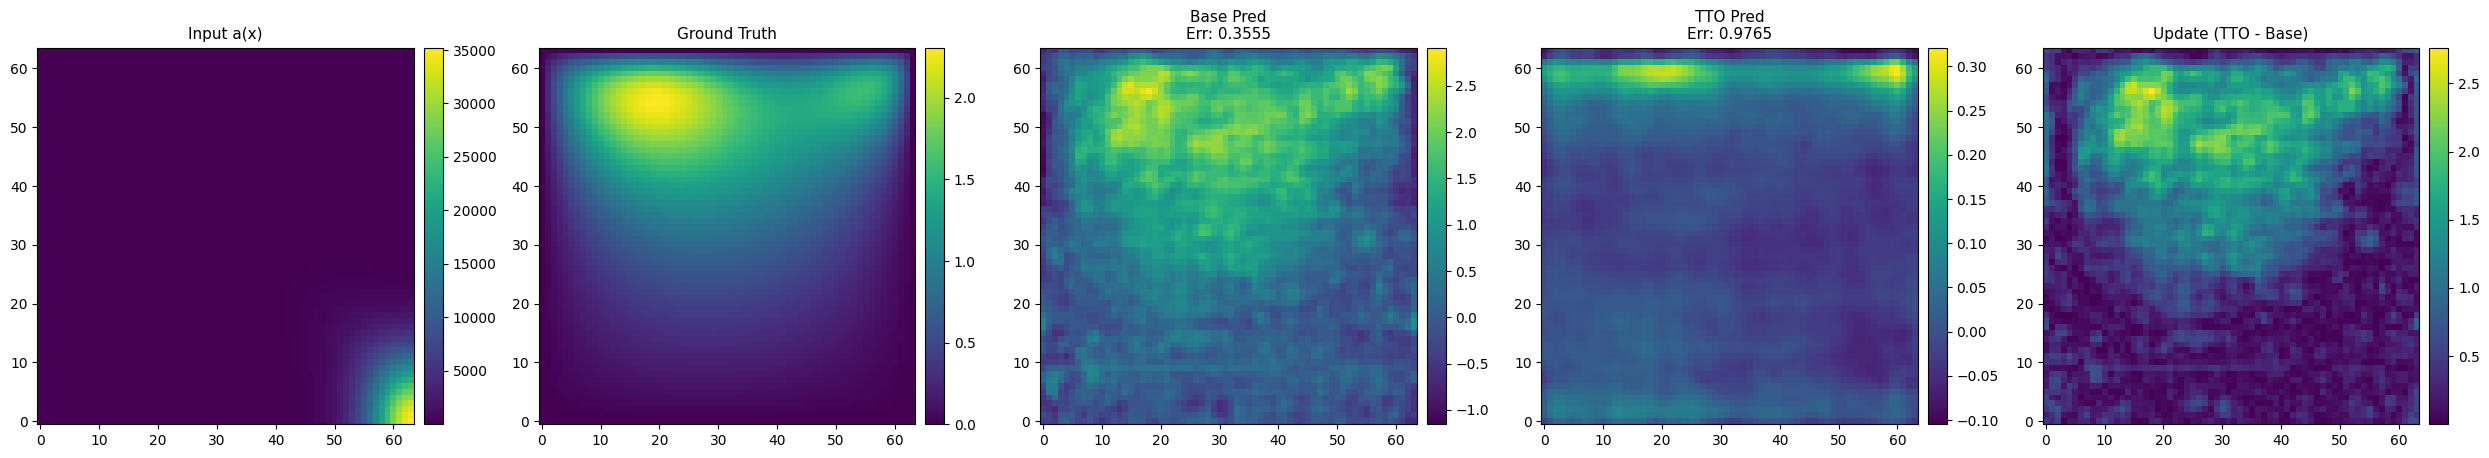

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import copy

# ----------------------------------------------------------------
# 0. Global Settings
# ----------------------------------------------------------------
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# 1. Data Generation (Darcy Flow Solver)
# ----------------------------------------------------------------
class DarcySolver:
    def __init__(self, N=64):
        self.N = N
        self.h = 1.0 / (N - 1)
        self.x = np.linspace(0, 1, N)
        self.y = np.linspace(0, 1, N)
    
    def generate_random_permeability(self, beta=4.0): # High Contrast
        xi = np.random.randn(self.N, self.N)
        a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=self.N/4.0)
        a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
        return np.exp(beta * a_smooth)

    def solve(self, a_field):
        N = self.N; h = self.h; num = N*N
        row, col, data, rhs = [], [], [], np.ones(num)*h**2
        idx = lambda i, j: i*N + j
        
        for i in range(N):
            for j in range(N):
                curr = idx(i, j)
                if i==0 or i==N-1 or j==0 or j==N-1:
                    row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
                else:
                    ac = a_field[i,j]
                    row.append(curr); col.append(curr); data.append(4*ac)
                    row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                    row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                    row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                    row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                    
        A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
        u = spla.spsolve(A, rhs)
        return u.reshape(N, N)

def generate_dataset(num_samples, N=64):
    solver = DarcySolver(N)
    data_a, data_u = [], []
    print(f"Generating {num_samples} samples...")
    for i in range(num_samples):
        a = solver.generate_random_permeability()
        u = solver.solve(a)
        data_a.append(a); data_u.append(u)
    return np.array(data_a)[:, np.newaxis, :, :], np.array(data_u)[:, np.newaxis, :, :]

# Generate Data
# Training: 1000 samples, Test: 2 samples
train_a, train_u = generate_dataset(2000, N=64)
test_a, test_u = generate_dataset(2, N=64) 

x_train = torch.tensor(train_a, dtype=torch.float32).to(device)
y_train = torch.tensor(train_u, dtype=torch.float32).to(device)
x_test = torch.tensor(test_a, dtype=torch.float32).to(device)
y_test = torch.tensor(test_u, dtype=torch.float32).to(device)

# ----------------------------------------------------------------
# 2. Normalization & Preprocessing (Log-Scaling)
# ----------------------------------------------------------------
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=1e-5):
        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps
    def encode(self, x): return (x - self.mean) / (self.std + self.eps)
    def decode(self, x): return (x * (self.std + self.eps)) + self.mean
    def cuda(self): self.mean = self.mean.cuda(); self.std = self.std.cuda(); return self

# Log-Scale Input Preprocessing
x_train_log = torch.log(x_train)
x_test_log = torch.log(x_test)

x_normalizer = UnitGaussianNormalizer(x_train_log)
y_normalizer = UnitGaussianNormalizer(y_train)

x_train_norm = x_normalizer.encode(x_train_log)
y_train_norm = y_normalizer.encode(y_train)
x_test_norm = x_normalizer.encode(x_test_log)

x_normalizer.cuda(); y_normalizer.cuda()

# ----------------------------------------------------------------
# 3. FNO Model Definition
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels; self.out_channels = out_channels
        self.modes1 = modes1; self.modes2 = modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        return torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes; self.modes2 = modes; self.width = width
        self.fc0 = nn.Linear(3, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1); self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1); self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128); self.fc2 = nn.Linear(128, 1)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1); x = self.fc0(x); x = x.permute(0, 3, 1, 2)
        x1 = self.conv0(x); x2 = self.w0(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv1(x); x2 = self.w1(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv2(x); x2 = self.w2(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv3(x); x2 = self.w3(x); x = x1 + x2
        x = x.permute(0, 2, 3, 1); x = self.fc1(x); x = F.gelu(x); x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

# ----------------------------------------------------------------
# 4. Physics Loss (Log-PDE Formulation)
# ----------------------------------------------------------------
def compute_physics_loss(u, a):
    """
    Log-Formulation PDE: Laplacian(u) + Grad(ln a) * Grad(u) + 1/a = 0
    Inputs must be in physical scale (un-normalized).
    """
    h = 1.0 / (u.shape[-1] - 1)
    
    # Finite Difference Kernels
    kx = torch.tensor([[[[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]]]], device=u.device) / h
    ky = torch.tensor([[[[0, -0.5, 0], [0, 0, 0], [0, 0.5, 0]]]], device=u.device) / h
    klap = torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], device=u.device) / (h**2)
    
    # 1. Prepare Log Coefficients (Safe Log)
    log_a = torch.log(a + 1e-6)
    inv_a = 1.0 / (a + 1e-6)
    
    # 2. Compute Derivatives
    d_loga_x = F.conv2d(log_a, kx, padding=1)
    d_loga_y = F.conv2d(log_a, ky, padding=1)
    du_x = F.conv2d(u, kx, padding=1)
    du_y = F.conv2d(u, ky, padding=1)
    du_xx_yy = F.conv2d(u, klap, padding=1)
    
    # 3. Residual
    res = du_xx_yy + (d_loga_x * du_x + d_loga_y * du_y) + inv_a
    
    # Loss (Interior only to avoid boundary padding artifacts)
    return torch.mean(res[:, :, 2:-2, 2:-2]**2)

# ----------------------------------------------------------------
# 5. Phase 1: Pre-training (Supervised)
# ----------------------------------------------------------------
model = FNO2d(modes=16, width=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

print("\n🚀 Phase 1: Pre-training FNO (Supervised, 300 Epochs)...")
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_norm, y_train_norm), batch_size=32, shuffle=True
)

for epoch in range(800):
    model.train()
    mse_total = 0
    for x_b, y_b in train_loader:
        optimizer.zero_grad()
        pred_norm = model(x_b)
        loss = F.mse_loss(pred_norm, y_b)
        loss.backward()
        optimizer.step()
        mse_total += loss.item()
    scheduler.step()
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}: Normalized MSE Loss = {mse_total/len(train_loader):.6f}")

print("✅ Phase 1 Complete.")

# ----------------------------------------------------------------
# 6. Phase 2: Test-Time Optimization (TTO) - CORRECTED
# ----------------------------------------------------------------
def run_tto(model, x_input_norm, x_input_phys, steps=5):
    """
    Fine-tune the model for a SINGLE test instance using Physics Loss.
    Corrected to handle gradients properly.
    """
    # [Fix 1] Deepcopy the model
    model_tto = copy.deepcopy(model)
    model_tto.train() 
    
    # [Fix 2] Explicitly enable gradients for all parameters in the copy
    for param in model_tto.parameters():
        param.requires_grad = True
        
    # [Fix 3] Detach inputs to ensure they are treated as static constants
    x_in = x_input_norm.detach().clone()
    x_phys = x_input_phys.detach().clone()
    
    # Optimizer: L-BFGS is best for this precision work
    optimizer_tto = optim.LBFGS(
        model_tto.parameters(), 
        lr=1.0, 
        max_iter=40, 
        history_size=20, 
        line_search_fn="strong_wolfe"
    )
    
    losses = []
    print(f"   Starting TTO for {steps} steps (L-BFGS)...")
    
    for i in range(steps):
        def closure():
            optimizer_tto.zero_grad()
            
            # Forward Pass (Normalized Domain)
            y_pred_norm = model_tto(x_in)
            
            # Denormalize to Physical Domain
            y_pred_phys = y_normalizer.decode(y_pred_norm)
            
            # Physics Loss
            loss_phy = compute_physics_loss(y_pred_phys, x_phys)
            
            # Boundary Loss (Hard Constraint: Boundary should be 0)
            loss_bc = torch.mean(y_pred_phys[..., 0, :]**2) + \
                      torch.mean(y_pred_phys[..., -1, :]**2) + \
                      torch.mean(y_pred_phys[..., :, 0]**2) + \
                      torch.mean(y_pred_phys[..., :, -1]**2)
            
            loss = loss_phy + 1000.0 * loss_bc
            
            if loss.requires_grad:
                loss.backward()
            
            return loss

        optimizer_tto.step(closure)
        
        # Logging
        with torch.no_grad():
            curr_loss = closure().item()
            losses.append(curr_loss)
            
    print(f"   TTO Done. Final Physics Loss: {losses[-1]:.6f}")
    return model_tto

# Select a test sample
test_idx = 0
x_in_norm = x_test_norm[test_idx:test_idx+1]
x_in_phys = x_test[test_idx:test_idx+1]
y_gt_phys = y_test[test_idx:test_idx+1]

# Run TTO
print("\n🚀 Phase 2: Running PINN TTO (Fine-tuning)...")
model_tto = run_tto(model, x_in_norm, x_in_phys, steps=5)

# ----------------------------------------------------------------
# 7. Evaluation & Visualization
# ----------------------------------------------------------------
model.eval(); model_tto.eval()

with torch.no_grad():
    # Base FNO Prediction
    pred_base_norm = model(x_in_norm)
    pred_base = y_normalizer.decode(pred_base_norm)
    
    # TTO Prediction
    pred_tto_norm = model_tto(x_in_norm)
    pred_tto = y_normalizer.decode(pred_tto_norm)

# Metrics
err_base = torch.norm(pred_base - y_gt_phys) / torch.norm(y_gt_phys)
err_tto = torch.norm(pred_tto - y_gt_phys) / torch.norm(y_gt_phys)

print("-" * 50)
print(f"📊 Result Summary")
print(f"   Base FNO Error: {err_base.item():.6f}")
print(f"   TTO FNO Error:  {err_tto.item():.6f}")
print("-" * 50)

# Visualization
u_gt = y_gt_phys.cpu().numpy()[0, 0]
u_base = pred_base.cpu().numpy()[0, 0]
u_tto = pred_tto.cpu().numpy()[0, 0]

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

def plot_cbar(ax, data, title):
    im = ax.imshow(data, origin='lower', cmap='viridis')
    ax.set_title(title, fontsize=11)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)

plot_cbar(axes[0], x_in_phys.cpu().numpy()[0,0], "Input a(x)")
plot_cbar(axes[1], u_gt, "Ground Truth")
plot_cbar(axes[2], u_base, f"Base Pred\nErr: {err_base:.4f}")
plot_cbar(axes[3], u_tto, f"TTO Pred\nErr: {err_tto:.4f}")
plot_cbar(axes[4], np.abs(u_tto - u_base), "Update (TTO - Base)") 

plt.tight_layout()
plt.show()

Using device: cuda
Generating 1000 samples...
Generating 50 samples...

🚀 Phase 1: Pre-training (500 Epochs)...
Epoch 50: L2 Loss = 0.533526
Epoch 100: L2 Loss = 0.357540
Epoch 150: L2 Loss = 0.227532
Epoch 200: L2 Loss = 0.182538
Epoch 250: L2 Loss = 0.150869
Epoch 300: L2 Loss = 0.136996
Epoch 350: L2 Loss = 0.131211
Epoch 400: L2 Loss = 0.128731
Epoch 450: L2 Loss = 0.128251
Epoch 500: L2 Loss = 0.125719

🚀 Phase 2: Physics Fine-tuning (200 Epochs)...
Epoch 20: Data Loss=0.453963, Phy Loss=54514925.992188
Epoch 40: Data Loss=0.530332, Phy Loss=54047861.602539
Epoch 60: Data Loss=0.573189, Phy Loss=53706655.505859
Epoch 80: Data Loss=0.603377, Phy Loss=53418531.763672
Epoch 100: Data Loss=0.631304, Phy Loss=53130736.457031
Epoch 120: Data Loss=0.652020, Phy Loss=52909773.437500
Epoch 140: Data Loss=0.668691, Phy Loss=52666900.175781
Epoch 160: Data Loss=0.684613, Phy Loss=53159845.828125
Epoch 180: Data Loss=0.701227, Phy Loss=52212428.496094
Epoch 200: Data Loss=0.714125, Phy Loss=5

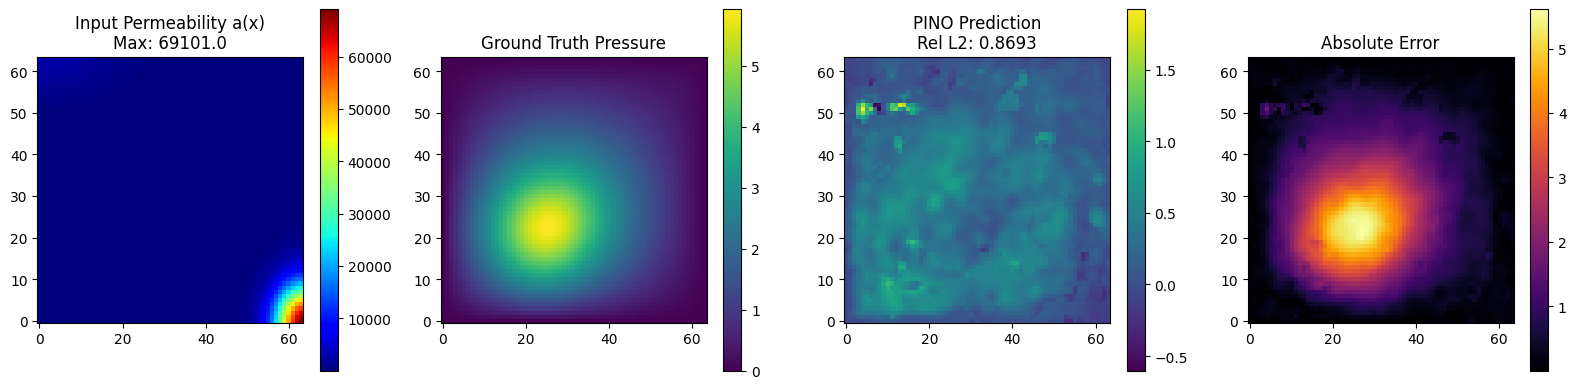

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. Global Settings
# ----------------------------------------------------------------
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# [Step 1] Data Generation (동일)
# ----------------------------------------------------------------
# ... (DarcySolver 및 generate_dataset 코드는 위와 동일하므로 생략, 바로 데이터 생성) ...
class DarcySolver:
    def __init__(self, N=64):
        self.N = N; self.h = 1.0 / (N - 1)
        self.x = np.linspace(0, 1, N); self.y = np.linspace(0, 1, N)
    
    def generate_random_permeability(self, beta=4.0):
        xi = np.random.randn(self.N, self.N)
        a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=self.N/3.0) # sigma 조정
        a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
        return np.exp(beta * a_smooth)

    def solve(self, a_field):
        N = self.N; h = self.h; num = N*N
        row, col, data, rhs = [], [], [], np.ones(num)*h**2
        idx = lambda i, j: i*N + j
        for i in range(N):
            for j in range(N):
                curr = idx(i, j)
                if i==0 or i==N-1 or j==0 or j==N-1:
                    row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
                else:
                    ac = a_field[i,j]
                    row.append(curr); col.append(curr); data.append(4*ac)
                    row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                    row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                    row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                    row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
        A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
        u = spla.spsolve(A, rhs)
        return u.reshape(N, N)

def generate_dataset(num_samples, N=64):
    solver = DarcySolver(N)
    data_a, data_u = [], []
    print(f"Generating {num_samples} samples...")
    for i in range(num_samples):
        a = solver.generate_random_permeability()
        u = solver.solve(a)
        data_a.append(a); data_u.append(u)
    return np.array(data_a)[:, np.newaxis, :, :], np.array(data_u)[:, np.newaxis, :, :]

# 데이터 생성 (빠른 테스트를 위해 개수 조절 가능)
train_a, train_u = generate_dataset(1000, N=64) # 1000개
test_a, test_u = generate_dataset(50, N=64)

x_train = torch.tensor(train_a, dtype=torch.float32)
y_train = torch.tensor(train_u, dtype=torch.float32)
x_test = torch.tensor(test_a, dtype=torch.float32)
y_test = torch.tensor(test_u, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=False)

# ----------------------------------------------------------------
# [Step 2] Model Definition (FNO) - 동일
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels; self.out_channels = out_channels
        self.modes1 = modes1; self.modes2 = modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        return torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes; self.modes2 = modes; self.width = width
        self.fc0 = nn.Linear(3, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1); self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1); self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128); self.fc2 = nn.Linear(128, 1)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1); x = self.fc0(x); x = x.permute(0, 3, 1, 2)
        x1 = self.conv0(x); x2 = self.w0(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv1(x); x2 = self.w1(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv2(x); x2 = self.w2(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv3(x); x2 = self.w3(x); x = x1 + x2
        x = x.permute(0, 2, 3, 1); x = self.fc1(x); x = F.gelu(x); x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

# ----------------------------------------------------------------
# [Step 4] (중요) Log-PDE Residual Calculation (수정됨!)
# ----------------------------------------------------------------
def compute_log_pde_residual(u, a):
    """
    Log-Formulation for High Contrast Darcy Flow
    Equation: Laplacian(u) + Grad(ln a) * Grad(u) + 1/a = 0
    """
    h = 1.0 / (u.shape[-1] - 1)
    
    # Filters
    # [1, 1, 3, 3] 형태의 커널 준비
    kx = torch.tensor([[[[0, 0, 0], [-0.5, 0, 0.5], [0, 0, 0]]]], device=u.device) / h
    ky = torch.tensor([[[[0, -0.5, 0], [0, 0, 0], [0, 0.5, 0]]]], device=u.device) / h
    klap = torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], device=u.device) / (h**2)
    
    # 1. Prepare Log-Transformed Coefficients
    # a는 항상 양수이므로 log 안전
    log_a = torch.log(a) 
    inv_a = 1.0 / a
    
    # 2. Compute Gradients
    # Grad(ln a)
    d_loga_x = F.conv2d(log_a, kx, padding=1)
    d_loga_y = F.conv2d(log_a, ky, padding=1)
    
    # Grad(u)
    du_x = F.conv2d(u, kx, padding=1)
    du_y = F.conv2d(u, ky, padding=1)
    
    # Laplacian(u)
    du_xx_yy = F.conv2d(u, klap, padding=1)
    
    # 3. Compute Residual
    # Res = Lap(u) + (d_loga_x * du_x + d_loga_y * du_y) + 1/a
    residual = du_xx_yy + (d_loga_x * du_x + d_loga_y * du_y) + inv_a
    
    # 경계 제외 (Boundary padding issue)
    return residual[:, :, 2:-2, 2:-2]

def relative_l2_loss(pred, true):
    diff = pred - true
    loss = torch.norm(diff.view(diff.shape[0], -1), p=2, dim=1) / torch.norm(true.view(true.shape[0], -1), p=2, dim=1)
    return loss.mean()

# ----------------------------------------------------------------
# [Step 5] Training (Phase 1 & 2)
# ----------------------------------------------------------------
model = FNO2d(modes=12, width=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Phase 1: Data-Driven (Supervised)
print("\n🚀 Phase 1: Pre-training (500 Epochs)...")
for epoch in range(500):
    model.train()
    total_loss = 0
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model(x_b)
        loss = relative_l2_loss(out, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}: L2 Loss = {total_loss/len(train_loader):.6f}")

# Phase 2: Physics-Informed (Log-PDE)
print("\n🚀 Phase 2: Physics Fine-tuning (200 Epochs)...")
# Physics Weight를 낮춰서 시작 (균형 맞추기)
lambda_phy = 0.001 

for epoch in range(200):
    model.train()
    total_data = 0
    total_phy = 0
    
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model(x_b)
        
        # 1. Data Loss
        l_data = relative_l2_loss(out, y_b)
        
        # 2. Log-PDE Loss (안정적)
        res = compute_log_pde_residual(out, x_b)
        l_phy = torch.mean(res**2)
        
        # Combined
        loss = l_data + lambda_phy * l_phy
        loss.backward()
        optimizer.step()
        
        total_data += l_data.item()
        total_phy += l_phy.item()
        
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: Data Loss={total_data/len(train_loader):.6f}, Phy Loss={total_phy/len(train_loader):.6f}")

print("✅ Training Complete.")

# ----------------------------------------------------------------
# [Step 6] Visualization (Corrected)
# ----------------------------------------------------------------
model.eval()
idx = 0
x_in = x_test[idx:idx+1].to(device)
y_gt = y_test[idx:idx+1].to(device)

with torch.no_grad():
    y_pred = model(x_in)
    err = relative_l2_loss(y_pred, y_gt)

print(f"\n📊 Final Test Error (Sample {idx}): {err.item():.4f}")

# Plotting
a_np = x_in.squeeze().cpu().numpy()
u_gt_np = y_gt.squeeze().cpu().numpy()
u_pred_np = y_pred.squeeze().cpu().numpy()
err_np = np.abs(u_gt_np - u_pred_np)

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title(f"Input Permeability a(x)\nMax: {a_np.max():.1f}")
plt.imshow(a_np, cmap='jet', origin='lower')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.title("Ground Truth Pressure")
plt.imshow(u_gt_np, cmap='viridis', origin='lower')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.title(f"PINO Prediction\nRel L2: {err.item():.4f}")
plt.imshow(u_pred_np, cmap='viridis', origin='lower')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.title("Absolute Error")
plt.imshow(err_np, cmap='inferno', origin='lower')
plt.colorbar()

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.ndimage
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# ----------------------------------------------------------------
# [0] Global Settings
# ----------------------------------------------------------------
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# [Step 1] Classical FDM Solver (Data Generator)
# ----------------------------------------------------------------
class DarcySolver:
    def __init__(self, N=64):
        self.N = N
        self.h = 1.0 / (N - 1)
        self.x = np.linspace(0, 1, N)
        self.y = np.linspace(0, 1, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)

    def generate_random_permeability(self, alpha=3.0, beta=4.0):
        xi = np.random.randn(self.N, self.N)
        real_alpha = np.random.uniform(2.0, 4.0) 
        sigma = self.N / real_alpha
        a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=sigma)
        
        # 정규화 후 스케일링
        a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
        a = np.exp(beta * a_smooth) 
        return a

    def solve(self, a_field):
        """
        Solver solves: A * u = h^2 * 1
        Implementation: Simplified Laplacian (-a * Laplacian u = 1)
        """
        N = self.N
        h = self.h
        num_unknowns = N * N
        idx = lambda i, j: i * N + j
        
        row, col, data = [], [], []
        rhs = np.ones(num_unknowns) * h**2 # Scale factor included here
        
        for i in range(N):
            for j in range(N):
                curr = idx(i, j)
                
                # 경계 조건 (Dirichlet u=0)
                if i == 0 or i == N-1 or j == 0 or j == N-1:
                    row.append(curr); col.append(curr); data.append(1.0)
                    rhs[curr] = 0.0
                    continue
                
                # 내부 점: 4*u_c - u_l - u_r - u_u - u_d
                a_c = a_field[i, j]
                row.append(curr); col.append(curr); data.append(4 * a_c)
                row.append(curr); col.append(idx(i-1, j)); data.append(-a_c)
                row.append(curr); col.append(idx(i+1, j)); data.append(-a_c)
                row.append(curr); col.append(idx(i, j-1)); data.append(-a_c)
                row.append(curr); col.append(idx(i, j+1)); data.append(-a_c)
                
        A = sp.coo_matrix((data, (row, col)), shape=(num_unknowns, num_unknowns)).tocsc()
        u = spla.spsolve(A, rhs)
        return u.reshape(N, N)

def generate_dataset(num_samples, N=64):
    solver = DarcySolver(N)
    data_a = []
    data_u = []
    
    print(f"Generating {num_samples} samples...")
    for i in range(num_samples):
        a = solver.generate_random_permeability()
        u = solver.solve(a)
        data_a.append(a)
        data_u.append(u)
        if (i + 1) % 500 == 0:
            print(f"   ... {i + 1}/{num_samples} completed")
            
    return np.array(data_a)[:, np.newaxis, :, :], np.array(data_u)[:, np.newaxis, :, :]

# ----------------------------------------------------------------
# [Step 2] Prepare Data
# ----------------------------------------------------------------
# 학습 시간 단축을 위해 샘플 수 조정 (필요시 늘리세요)
N_GRID = 64
train_a, train_u = generate_dataset(2000, N=N_GRID)
test_a, test_u = generate_dataset(50, N=N_GRID)

x_train = torch.tensor(train_a, dtype=torch.float32)
y_train = torch.tensor(train_u, dtype=torch.float32)
x_test = torch.tensor(test_a, dtype=torch.float32)
y_test = torch.tensor(test_u, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=False)

print(f"Data Loaded: Train {x_train.shape}")

# ----------------------------------------------------------------
# [Step 3] Model Definition: FNO
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x); x2 = self.w0(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv1(x); x2 = self.w1(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv2(x); x2 = self.w2(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv3(x); x2 = self.w3(x); x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = F.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

# ----------------------------------------------------------------
# [Step 4] Corrected Physics Loss Function
# ----------------------------------------------------------------
def compute_consistent_residual(u, a):
    """
    [Critical Fix]
    Solver가 푼 방정식은 A * u = h^2 * 1 입니다.
    1/h^2로 나누면 값이 너무 커지므로, A * u - h^2 = 0 을 최소화합니다.
    """
    N = u.shape[-1]
    h = 1.0 / (N - 1)
    
    # Kernel corresponding to standard Laplacian: [0, -1, 0], [-1, 4, -1], [0, -1, 0]
    # Solver Logic: 4*u_c - u_l - u_r - u_u - u_d
    kernel = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]], device=u.device)
    
    # 1. Compute 'Discrete Laplacian part' of Au
    # shape: (Batch, 1, H, W)
    au_laplacian = F.conv2d(u, kernel, padding=1)
    
    # 2. Multiply by 'a' (Solver logic: a_c * (4u_c - neighbors))
    # This matches the row in the sparse matrix
    Au = a * au_laplacian
    
    # 3. Target value (RHS)
    # Solver logic: rhs = h^2
    target = (h ** 2)
    
    # Residual = Au - RHS
    # Crop boundaries because BCs are handled differently
    residual = Au[:, :, 1:-1, 1:-1] - target
    
    return residual

def relative_l2_loss(pred, true):
    diff = pred - true
    batch_size = diff.shape[0]
    loss = torch.norm(diff.view(batch_size, -1), p=2, dim=1) / torch.norm(true.view(batch_size, -1), p=2, dim=1)
    return loss.mean()

# Init Model
model = FNO2d(modes=12, width=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# ----------------------------------------------------------------
# [Step 5] Training Execution
# ----------------------------------------------------------------
epochs_phase1 = 500  # Data-Driven
epochs_phase2 = 200  # Physics-Informed

print("\n🚀 Starting Training...")

# --- Phase 1: Data-Driven ---
print(f"--- [Phase 1] Supervised Pretraining ({epochs_phase1} epochs) ---")
for epoch in range(epochs_phase1):
    model.train()
    total_loss = 0
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model(x_b)
        loss = relative_l2_loss(out, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: L2 Loss = {total_loss/len(train_loader):.6f}")

# --- Phase 2: Physics-Informed Fine-tuning ---
print(f"\n--- [Phase 2] Physics-Informed Fine-tuning ({epochs_phase2} epochs) ---")
# Scaling Check:
# Data Loss ~= 0.1
# Phy Residual ~= 1e-4 (due to h^2 scaling)
# Multiplier should be large now, e.g., 1000.0, to make Phy Loss visible (~0.1)
lambda_phy = 5000.0 

# Phase 2용 새로운 Optimizer (낮은 LR)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)

for epoch in range(epochs_phase2):
    model.train()
    total_data_loss = 0
    total_phy_loss = 0
    
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer_ft.zero_grad()
        out = model(x_b)
        
        # 1. Data Loss
        l_data = relative_l2_loss(out, y_b)
        
        # 2. Physics Loss (Corrected)
        residual = compute_consistent_residual(out, x_b)
        l_phy_raw = torch.mean(residual**2)
        
        # Total Loss
        loss = l_data + (lambda_phy * l_phy_raw)
        
        loss.backward()
        optimizer_ft.step()
        
        total_data_loss += l_data.item()
        total_phy_loss += (lambda_phy * l_phy_raw).item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Data Loss={total_data_loss/len(train_loader):.4f}, Phy Loss (Weighted)={total_phy_loss/len(train_loader):.4f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# [Step 6] Inference & Verification
# ----------------------------------------------------------------
model.eval()

# Speed Test
x_sample = x_test[:1].to(device)
torch.cuda.synchronize() if torch.cuda.is_available() else None
t0 = time.time()
with torch.no_grad():
    _ = model(x_sample)
torch.cuda.synchronize() if torch.cuda.is_available() else None
print(f"\n⚡ Inference Time: {(time.time() - t0)*1000:.4f} ms")

# Visualization
idx = np.random.randint(0, len(x_test))
x_in = x_test[idx:idx+1].to(device)
y_gt = y_test[idx:idx+1].to(device)
with torch.no_grad():
    y_pred = model(x_in)

a_np = x_in.squeeze().cpu().numpy()
u_gt_np = y_gt.squeeze().cpu().numpy()
u_pred_np = y_pred.squeeze().cpu().numpy()
err_np = np.abs(u_gt_np - u_pred_np)

plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1); plt.title("Permeability (a)"); plt.imshow(a_np, cmap='jet', origin='lower')
plt.subplot(1, 4, 2); plt.title("GT Pressure (u)"); plt.imshow(u_gt_np, cmap='viridis', origin='lower')
plt.subplot(1, 4, 3); plt.title("FNO Prediction"); plt.imshow(u_pred_np, cmap='viridis', origin='lower')
plt.subplot(1, 4, 4); plt.title("Error"); plt.imshow(err_np, cmap='magma', origin='lower'); plt.colorbar()
plt.show()

Using device: cuda
Generating 2000 samples...
   ... 500/2000 completed
   ... 1000/2000 completed
   ... 1500/2000 completed
   ... 2000/2000 completed
Generating 50 samples...
Data Loaded: Train torch.Size([2000, 1, 64, 64])

🚀 Starting Training...
--- [Phase 1] Supervised Pretraining (500 epochs) ---
Epoch 10: L2 Loss = 0.739612
Epoch 20: L2 Loss = 0.678530
Epoch 30: L2 Loss = 0.556925
Epoch 40: L2 Loss = 0.487453
Epoch 50: L2 Loss = 0.434621
Epoch 60: L2 Loss = 0.399446
Epoch 70: L2 Loss = 0.360478
Epoch 80: L2 Loss = 0.326394
Epoch 90: L2 Loss = 0.293708
Epoch 100: L2 Loss = 0.272810
Epoch 110: L2 Loss = 0.246600
Epoch 120: L2 Loss = 0.229850
Epoch 130: L2 Loss = 0.217669
Epoch 140: L2 Loss = 0.211063
Epoch 150: L2 Loss = 0.201181
Epoch 160: L2 Loss = 0.181401
Epoch 170: L2 Loss = 0.178981
Epoch 180: L2 Loss = 0.164238
Epoch 190: L2 Loss = 0.161577
Epoch 200: L2 Loss = 0.256826
Epoch 210: L2 Loss = 0.167598
Epoch 220: L2 Loss = 0.149793
Epoch 230: L2 Loss = 0.141465
Epoch 240: L2 

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.LongTensor) should be the same

Using device: cuda
Generating 2000 samples...
   ... 500/2000 completed
   ... 1000/2000 completed
   ... 1500/2000 completed
   ... 2000/2000 completed
Generating 50 samples...
Data Preprocessing Complete.
Input Stats (Norm): Mean=0.0000, Std=1.0000
Target Stats (Norm): Mean=-0.0000, Std=1.0000

🚀 Starting Training...
--- [Phase 1] Supervised Pretraining (500 epochs) ---
Epoch 50: L2 Loss (Norm) = 0.036582
Epoch 100: L2 Loss (Norm) = 0.034054
Epoch 150: L2 Loss (Norm) = 0.027715
Epoch 200: L2 Loss (Norm) = 0.025535
Epoch 250: L2 Loss (Norm) = 0.021933
Epoch 300: L2 Loss (Norm) = 0.024303
Epoch 350: L2 Loss (Norm) = 0.023522
Epoch 400: L2 Loss (Norm) = 0.018987
Epoch 450: L2 Loss (Norm) = 0.018564
Epoch 500: L2 Loss (Norm) = 0.020106

--- [Phase 2] Physics-Informed Fine-tuning (200 epochs) ---
Epoch 10: Data Loss=0.6531, Phy Loss=15267088.2282
Epoch 20: Data Loss=0.6548, Phy Loss=12454595.2241
Epoch 30: Data Loss=0.6577, Phy Loss=17104351.8549
Epoch 40: Data Loss=0.6640, Phy Loss=66344

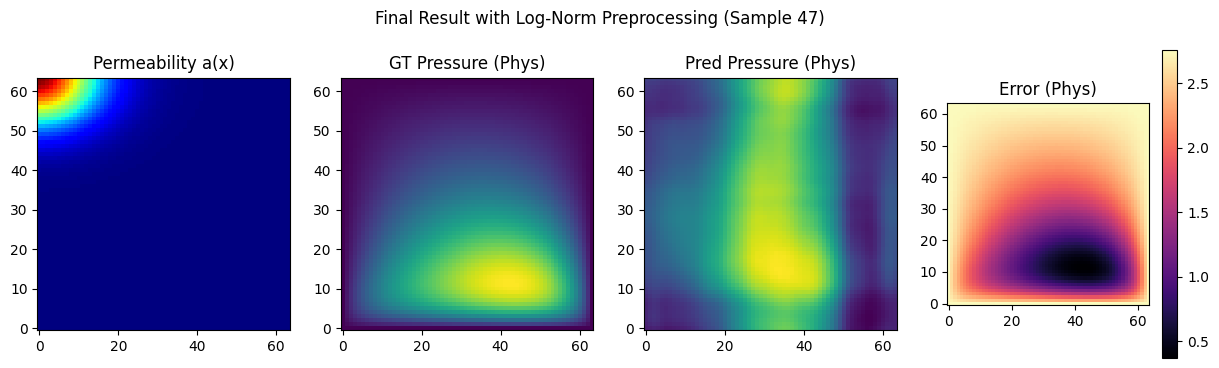

In [10]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.ndimage
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# ----------------------------------------------------------------
# [0] Global Settings
# ----------------------------------------------------------------
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------------------
# [Step 1] Classical FDM Solver (Data Generator)
# ----------------------------------------------------------------
class DarcySolver:
    def __init__(self, N=64):
        self.N = N
        self.h = 1.0 / (N - 1)
        self.x = np.linspace(0, 1, N)
        self.y = np.linspace(0, 1, N)
        self.X, self.Y = np.meshgrid(self.x, self.y)

    def generate_random_permeability(self, alpha=3.0, beta=4.0):
        xi = np.random.randn(self.N, self.N)
        real_alpha = np.random.uniform(2.0, 4.0) 
        sigma = self.N / real_alpha
        a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=sigma)
        
        # 정규화 후 스케일링
        a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
        a = np.exp(beta * a_smooth) 
        return a

    def solve(self, a_field):
        """ A * u = h^2 * 1 """
        N = self.N
        h = self.h
        num_unknowns = N * N
        idx = lambda i, j: i * N + j
        
        row, col, data = [], [], []
        rhs = np.ones(num_unknowns) * h**2 
        
        for i in range(N):
            for j in range(N):
                curr = idx(i, j)
                if i == 0 or i == N-1 or j == 0 or j == N-1:
                    row.append(curr); col.append(curr); data.append(1.0)
                    rhs[curr] = 0.0
                    continue
                
                a_c = a_field[i, j]
                row.append(curr); col.append(curr); data.append(4 * a_c)
                row.append(curr); col.append(idx(i-1, j)); data.append(-a_c)
                row.append(curr); col.append(idx(i+1, j)); data.append(-a_c)
                row.append(curr); col.append(idx(i, j-1)); data.append(-a_c)
                row.append(curr); col.append(idx(i, j+1)); data.append(-a_c)
                
        A = sp.coo_matrix((data, (row, col)), shape=(num_unknowns, num_unknowns)).tocsc()
        u = spla.spsolve(A, rhs)
        return u.reshape(N, N)

def generate_dataset(num_samples, N=64):
    solver = DarcySolver(N)
    data_a = []
    data_u = []
    
    print(f"Generating {num_samples} samples...")
    for i in range(num_samples):
        a = solver.generate_random_permeability()
        u = solver.solve(a)
        data_a.append(a)
        data_u.append(u)
        if (i + 1) % 500 == 0:
            print(f"   ... {i + 1}/{num_samples} completed")
            
    return np.array(data_a)[:, np.newaxis, :, :], np.array(data_u)[:, np.newaxis, :, :]

# ----------------------------------------------------------------
# [Step 2] Data Preprocessing (Log Scale & Normalization)
# ----------------------------------------------------------------
class Normalizer:
    def __init__(self, data):
        self.mean = torch.mean(data)
        self.std = torch.std(data)
        self.eps = 1e-6

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return x * (self.std + self.eps) + self.mean

    def cuda(self):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self

# 1. 데이터 생성
N_GRID = 64
train_a_raw, train_u_raw = generate_dataset(2000, N=N_GRID)
test_a_raw, test_u_raw = generate_dataset(50, N=N_GRID)

# 2. Log Scaling for Input (Permeability a)
# a는 지수적으로 생성되므로 log를 취하면 Gaussian 분포에 가까워져 학습이 훨씬 잘 됨
train_a_log = np.log(train_a_raw)
test_a_log = np.log(test_a_raw)

# 3. Tensor 변환
x_train = torch.tensor(train_a_log, dtype=torch.float32)
y_train = torch.tensor(train_u_raw, dtype=torch.float32)
x_test = torch.tensor(test_a_log, dtype=torch.float32)
y_test = torch.tensor(test_u_raw, dtype=torch.float32)

# 4. Normalization (Gaussian)
# 학습 데이터의 통계치로 Normalizer 생성
x_normalizer = Normalizer(x_train)
y_normalizer = Normalizer(y_train)

x_train = x_normalizer.encode(x_train)
y_train = y_normalizer.encode(y_train)

x_test = x_normalizer.encode(x_test)
y_test = y_normalizer.encode(y_test)

# Normalizer를 GPU로 이동 (학습 중 Denormalization 위해 필요)
x_normalizer.cuda()
y_normalizer.cuda()

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=False)

print(f"Data Preprocessing Complete.")
print(f"Input Stats (Norm): Mean={x_train.mean():.4f}, Std={x_train.std():.4f}")
print(f"Target Stats (Norm): Mean={y_train.mean():.4f}, Std={y_train.std():.4f}")

# ----------------------------------------------------------------
# [Step 3] Model Definition: FNO
# ----------------------------------------------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes
        self.modes2 = modes
        self.width = width
        self.fc0 = nn.Linear(3, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x1 = self.conv0(x); x2 = self.w0(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv1(x); x2 = self.w1(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv2(x); x2 = self.w2(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv3(x); x2 = self.w3(x); x = x1 + x2
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = F.gelu(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

# ----------------------------------------------------------------
# [Step 4] Physics Loss (with Denormalization Logic & FIX)
# ----------------------------------------------------------------
def compute_consistent_residual(u_phys, a_phys):
    """
    물리 Loss는 반드시 '물리적 단위(Physical Unit)'에서 계산되어야 합니다.
    따라서 모델 출력을 Denormalize 한 값을 입력으로 받습니다.
    """
    N = u_phys.shape[-1]
    h = 1.0 / (N - 1)
    
    # [FIX] Kernel creation: dtype=torch.float32 명시하여 LongTensor 에러 방지
    kernel = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]], 
                          dtype=torch.float32, device=u_phys.device)
    
    # 1. Laplacian of u
    au_laplacian = F.conv2d(u_phys, kernel, padding=1)
    
    # 2. Multiply by permeability a
    Au = a_phys * au_laplacian
    
    # 3. Target (h^2)
    target = (h ** 2)
    
    # Residual = Au - h^2
    residual = Au[:, :, 1:-1, 1:-1] - target
    return residual

def relative_l2_loss(pred, true):
    diff = pred - true
    batch_size = diff.shape[0]
    loss = torch.norm(diff.view(batch_size, -1), p=2, dim=1) / torch.norm(true.view(batch_size, -1), p=2, dim=1)
    return loss.mean()

# Init Model
model = FNO2d(modes=12, width=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# ----------------------------------------------------------------
# [Step 5] Training Execution
# ----------------------------------------------------------------
epochs_phase1 = 500  # Data-Driven
epochs_phase2 = 200  # Physics-Informed

print("\n🚀 Starting Training...")

# --- Phase 1: Data-Driven ---
print(f"--- [Phase 1] Supervised Pretraining ({epochs_phase1} epochs) ---")
for epoch in range(epochs_phase1):
    model.train()
    total_loss = 0
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model(x_b)
        # Normalized Space에서 바로 L2 Loss 계산
        loss = relative_l2_loss(out, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}: L2 Loss (Norm) = {total_loss/len(train_loader):.6f}")

# --- Phase 2: Physics-Informed Fine-tuning ---
print(f"\n--- [Phase 2] Physics-Informed Fine-tuning ({epochs_phase2} epochs) ---")
# Phy Loss가 물리 단위에서 계산되므로 값이 매우 작습니다 (h^2 ~ 0.0002).
# 따라서 Lambda를 크게 잡아서 보정합니다.
lambda_phy = 20000.0 

optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)

for epoch in range(epochs_phase2):
    model.train()
    total_data_loss = 0
    total_phy_loss = 0
    
    for x_b, y_b in train_loader:
        x_b, y_b = x_b.to(device), y_b.to(device)
        optimizer_ft.zero_grad()
        out = model(x_b) # out is Normalized u
        
        # 1. Data Loss (in Normalized Space)
        l_data = relative_l2_loss(out, y_b)
        
        # 2. Physics Loss (in Physical Space)
        # [중요] Loss 계산을 위해 Denormalization 수행
        u_phys = y_normalizer.decode(out)
        
        # Input x_b는 (log(a) - mean)/std 상태임 -> a_phys로 복원
        # 복원 순서: Normalize 해제 -> exp 취하기
        log_a_phys = x_normalizer.decode(x_b)
        a_phys = torch.exp(log_a_phys) 
        
        residual = compute_consistent_residual(u_phys, a_phys)
        l_phy_raw = torch.mean(residual**2)
        
        # Total Loss
        loss = l_data + (lambda_phy * l_phy_raw)
        
        loss.backward()
        optimizer_ft.step()
        
        total_data_loss += l_data.item()
        total_phy_loss += (lambda_phy * l_phy_raw).item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Data Loss={total_data_loss/len(train_loader):.4f}, Phy Loss={total_phy_loss/len(train_loader):.4f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# [Step 6] Inference & Verification
# ----------------------------------------------------------------
model.eval()

# Speed Test
x_sample = x_test[:1].to(device)
torch.cuda.synchronize() if torch.cuda.is_available() else None
t0 = time.time()
with torch.no_grad():
    _ = model(x_sample)
torch.cuda.synchronize() if torch.cuda.is_available() else None
print(f"\n⚡ Inference Time: {(time.time() - t0)*1000:.4f} ms")

# Visualization
idx = np.random.randint(0, len(x_test))
x_in = x_test[idx:idx+1].to(device)
y_gt = y_test[idx:idx+1].to(device)

with torch.no_grad():
    y_pred_norm = model(x_in)

# Denormalize for Visualization
x_log_phys = x_normalizer.decode(x_in)
a_phys = torch.exp(x_log_phys) # Log scale 복원
u_gt_phys = y_normalizer.decode(y_gt)
u_pred_phys = y_normalizer.decode(y_pred_norm)

# CPU 변환
a_np = a_phys.squeeze().cpu().numpy()
u_gt_np = u_gt_phys.squeeze().cpu().numpy()
u_pred_np = u_pred_phys.squeeze().cpu().numpy()
err_np = np.abs(u_gt_np - u_pred_np)

plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1); plt.title("Permeability a(x)"); plt.imshow(a_np, cmap='jet', origin='lower')
plt.subplot(1, 4, 2); plt.title("GT Pressure (Phys)"); plt.imshow(u_gt_np, cmap='viridis', origin='lower')
plt.subplot(1, 4, 3); plt.title("Pred Pressure (Phys)"); plt.imshow(u_pred_np, cmap='viridis', origin='lower')
plt.subplot(1, 4, 4); plt.title("Error (Phys)"); plt.imshow(err_np, cmap='magma', origin='lower'); plt.colorbar()
plt.suptitle(f"Final Result with Log-Norm Preprocessing (Sample {idx})")
plt.show()

In [6]:
import time

# 모델 초기화
modes = 12
width = 32
model = FNO2d(modes, width).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs_phase1 = 5000 # Data-driven only
epochs_phase2 = 1000  # + Physics-informed (Your TTO concept)

print("\n🚀 Starting Training...")

# ----------------------------------------------------------------
# [Phase 1] Data-Driven Pretraining (Supervised)
# ----------------------------------------------------------------
print(f"--- [Phase 1] Data-Driven Pretraining ({epochs_phase1} epochs) ---")
train_loss_history = []

start_time = time.time()
for epoch in range(epochs_phase1):
    model.train()
    total_loss = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out = model(x_batch)
        
        # Pure Data Loss (MSE or Rel L2)
        loss = relative_l2_loss(out, y_batch)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    scheduler.step()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.6f}")

phase1_time = time.time() - start_time
print(f"Phase 1 Complete. Time: {phase1_time:.2f}s")

# ----------------------------------------------------------------
# [Phase 2] Physics-Informed Fine-tuning (Equivalent to Amortized TTO)
# ----------------------------------------------------------------
print(f"\n--- [Phase 2] Physics-Informed Fine-tuning ({epochs_phase2} epochs) ---")
print("--> Adding PDE Residual Loss to bake physics into weights")

lambda_phy = 0.1 # Weight for physics loss

for epoch in range(epochs_phase2):
    model.train()
    total_data_loss = 0
    total_phy_loss = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out = model(x_batch)
        
        # 1. Data Loss
        l_data = relative_l2_loss(out, y_batch)
        
        # 2. Physics Loss (PDE Residual)
        # TTO에서 하던 최적화를 여기서 수행
        residual = compute_pde_residual(out, x_batch)
        l_phy = torch.mean(residual**2)
        
        # Total Loss
        loss = l_data + lambda_phy * l_phy
        
        loss.backward()
        optimizer.step()
        
        total_data_loss += l_data.item()
        total_phy_loss += l_phy.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Data Loss = {total_data_loss/len(train_loader):.6f}, Phy Loss = {total_phy_loss/len(train_loader):.6f}")

print("✅ Training Complete!")

# ----------------------------------------------------------------
# [Evaluation] Inference Speed & Accuracy Check
# ----------------------------------------------------------------
model.eval()

# 1. Inference Speed Check (Single Batch)
test_sample_a = x_test_tensor[:1].to(device) # Shape (1, 1, 64, 64)
torch.cuda.synchronize() if torch.cuda.is_available() else None
t0 = time.time()

with torch.no_grad():
    pred_u = model(test_sample_a)

torch.cuda.synchronize() if torch.cuda.is_available() else None
inference_time = time.time() - t0

print(f"\n⚡ Inference Time (Forward Pass): {inference_time*1000:.4f} ms")
print(f"   (vs Classical Solver which takes ~200-500 ms)")

# 2. Visual Comparison
idx = 0
gt_u = y_test_tensor[idx].to(device)
pred_u = model(x_test_tensor[idx:idx+1].to(device)).squeeze()
gt_u = gt_u.squeeze()
error_map = torch.abs(gt_u - pred_u)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Ground Truth (Solver)")
plt.imshow(gt_u.cpu().numpy(), origin='lower', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Prediction (Phase 2 Model)")
plt.imshow(pred_u.cpu().detach().numpy(), origin='lower', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Absolute Error")
plt.imshow(error_map.cpu().detach().numpy(), origin='lower', cmap='magma')
plt.colorbar()
plt.suptitle(f"Inference Result (Speed: {inference_time*1000:.2f} ms)", y=1.05)
plt.show()

# Test Set 전체 Error
model.eval()
with torch.no_grad():
    preds = model(x_test_tensor.to(device))
    test_err = relative_l2_loss(preds, y_test_tensor.to(device))
print(f"\nFinal Test Relative L2 Error: {test_err.item():.4f}")


🚀 Starting Training...
--- [Phase 1] Data-Driven Pretraining (5000 epochs) ---


NameError: name 'train_loader' is not defined

In [ ]:
# adam 5000 + L-BFGS 15000

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage 
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

# ----------------------------------------------------------------
# 0. 설정
# ----------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

# ----------------------------------------------------------------
# 1. Fourier Embedding (고주파 성분 학습 필수)
# ----------------------------------------------------------------
class FourierEmbedding(nn.Module):
    def __init__(self, in_features, out_features, scale=10.0):
        super().__init__()
        self.B = nn.Parameter(torch.randn(in_features, out_features // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ----------------------------------------------------------------
# 2. 데이터 생성 (Log-PDE용 Gradient 미리 계산)
# ----------------------------------------------------------------
def generate_darcy_data(N=64):
    print("Generating High-Contrast Permeability & Ground Truth...")
    h = 1.0 / (N - 1)
    
    # a(x) 생성
    xi = np.random.randn(N, N)
    a_smooth = scipy.ndimage.gaussian_filter(xi, sigma=N/5.0)
    a_smooth = (a_smooth - np.mean(a_smooth)) / np.std(a_smooth)
    
    beta = 4.0
    k_np = beta * a_smooth       # k = ln(a)
    a_np = np.exp(k_np)          # a = e^k
    
    # Ground Truth 계산 (FDM Solver)
    num = N * N
    rhs = np.ones(num) * h**2
    idx = lambda r, c: r*N + c
    row, col, data = [], [], []
    
    for i in range(N):
        for j in range(N):
            curr = idx(i, j)
            if i==0 or i==N-1 or j==0 or j==N-1:
                row.append(curr); col.append(curr); data.append(1.0); rhs[curr]=0.0
            else:
                ac = a_np[i,j]
                row.append(curr); col.append(curr); data.append(4*ac)
                row.append(curr); col.append(idx(i-1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i+1,j)); data.append(-ac)
                row.append(curr); col.append(idx(i,j-1)); data.append(-ac)
                row.append(curr); col.append(idx(i,j+1)); data.append(-ac)
                
    A = sp.coo_matrix((data, (row, col)), shape=(num, num)).tocsc()
    u_np = spla.spsolve(A, rhs).reshape(N, N)
    
    # Gradient 미리 계산 (중요!)
    grad_k = np.gradient(k_np, h)
    ky_np = grad_k[0] 
    kx_np = grad_k[1] 
    inv_a_np = 1.0 / a_np

    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).to(device)
    return (to_tensor(kx_np), to_tensor(ky_np), to_tensor(inv_a_np), 
            to_tensor(u_np), to_tensor(a_np))

# ----------------------------------------------------------------
# 3. PINN 모델 (Robust Architecture)
# ----------------------------------------------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.embedding = FourierEmbedding(in_features=2, out_features=128, scale=10.0)
        
        self.net = nn.Sequential(
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(), # Depth 5
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        return self.net(self.embedding(inputs))

# ----------------------------------------------------------------
# 4. Log-PDE Loss
# ----------------------------------------------------------------
def compute_loss(model, x, y, kx_field, ky_field, inv_a_field):
    # Grid Sampling
    with torch.no_grad():
        grid = torch.cat([x, y], dim=1).unsqueeze(0).unsqueeze(0) * 2 - 1
        kx_val = torch.nn.functional.grid_sample(kx_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        ky_val = torch.nn.functional.grid_sample(ky_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)
        inv_a_val = torch.nn.functional.grid_sample(inv_a_field.view(1, 1, 64, 64), grid, align_corners=True).view(-1, 1)

    x.requires_grad_(True)
    y.requires_grad_(True)
    u = model(x, y)
    
    # Derivatives
    grads = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_x = grads
    grads = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_y = grads
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # Residual: Laplacian u + Grad(ln a) . Grad u + 1/a = 0
    residual = (u_xx + u_yy) + (kx_val * u_x + ky_val * u_y) + inv_a_val
    return torch.mean(residual**2)

# ----------------------------------------------------------------
# 5. [핵심] Two-Stage Training (Adam + L-BFGS)
# ----------------------------------------------------------------
def train():
    kx_field, ky_field, inv_a_field, u_gt, a_field = generate_darcy_data()
    model = PINN().to(device)
    
    # 학습 데이터 (Collocation Points) - L-BFGS를 위해 고정된 점 사용 권장
    N_col = 5000
    N_b = 1000
    x_col = torch.rand(N_col, 1).to(device)
    y_col = torch.rand(N_col, 1).to(device)
    
    # Boundary Points
    rb = torch.rand(N_b // 4, 1).to(device)
    ones = torch.ones_like(rb)
    zeros = torch.zeros_like(rb)
    x_b = torch.cat([rb, rb, zeros, ones], dim=0)
    y_b = torch.cat([zeros, ones, rb, rb], dim=0)

    loss_history = []
    
    # --- Phase 1: Adam (Rough Optimization) ---
    print("\n🚀 Phase 1: Adam Optimization (warm-up)...")
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    EPOCHS_ADAM = 5000 # Adam은 적당히만 돌림
    
    model.train()
    start_time = time.time()
    
    for epoch in range(EPOCHS_ADAM):
        optimizer_adam.zero_grad()
        
        # Loss
        loss_pde = compute_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        loss = loss_pde + 100.0 * loss_bc
        
        loss.backward()
        optimizer_adam.step()
        
        loss_history.append(loss.item())
        if (epoch + 1) % 1000 == 0:
            print(f"[Adam] Epoch {epoch+1}: Loss {loss.item():.5f} (BC: {loss_bc.item():.5f})")

    # --- Phase 2: L-BFGS (Fine-Tuning) ---
    print("\n🚀 Phase 2: L-BFGS Optimization (The Finisher)...")
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(), 
        lr=1.0, 
        max_iter=50000, 
        max_eval=50000, 
        history_size=50,
        tolerance_grad=1e-7, 
        tolerance_change=1.0 * np.finfo(float).eps,
        line_search_fn="strong_wolfe"
    )
    
    def closure():
        optimizer_lbfgs.zero_grad()
        loss_pde = compute_loss(model, x_col, y_col, kx_field, ky_field, inv_a_field)
        u_b_pred = model(x_b, y_b)
        loss_bc = torch.mean(u_b_pred**2)
        loss = loss_pde + 100.0 * loss_bc
        loss.backward()
        return loss

    optimizer_lbfgs.step(closure)
    
    # 최종 Loss 확인
    final_loss = closure().item()
    loss_history.append(final_loss)
    print(f"[L-BFGS] Final Loss: {final_loss:.6f}")
    print(f"Total Time: {time.time()-start_time:.1f}s")
    
    return model, loss_history, u_gt, a_field

# ----------------------------------------------------------------
# 6. 결과 확인
# ----------------------------------------------------------------
def visualize(model, loss_hist, u_gt, a_field):
    model.eval()
    N = 64
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    
    x_in = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    
    with torch.no_grad():
        u_pred = model(x_in, y_in).view(N, N).cpu().numpy()
    
    u_gt_np = u_gt.cpu().numpy()
    a_np = a_field.cpu().numpy()
    
    rel_l2 = np.linalg.norm(u_gt_np - u_pred) / np.linalg.norm(u_gt_np)
    print(f"\n📊 Final Relative L2 Error: {rel_l2:.4f}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    im0 = axes[0].imshow(a_np, origin='lower', cmap='jet')
    axes[0].set_title("Input a(x)")
    plt.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(u_gt_np, origin='lower', cmap='viridis')
    axes[1].set_title("Ground Truth")
    plt.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(u_pred, origin='lower', cmap='viridis')
    axes[2].set_title(f"PINN Prediction\nL2 Err: {rel_l2:.4f}")
    plt.colorbar(im2, ax=axes[2])
    
    im3 = axes[3].imshow(np.abs(u_gt_np - u_pred), origin='lower', cmap='inferno')
    axes[3].set_title("Absolute Error")
    plt.colorbar(im3, ax=axes[3])
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.plot(loss_hist)
    plt.yscale('log')
    plt.title("Training Loss (Adam -> L-BFGS)")
    plt.show()

if __name__ == "__main__":
    model, loss_hist, u_gt, a_field = train()
    visualize(model, loss_hist, u_gt, a_field)